# Lightning density 


## imports

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import xarray 
import xesmf as xe
import cartopy.crs as ccrs
from datetime import datetime
import pandas as pd

from math import radians, cos, sin, asin, sqrt


import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from shapely import geometry
from textwrap import wrap

import shapely.geometry
import pyproj
#import colormap
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.patches import Polygon
from shapely.geometry import Point, Polygon
from matplotlib.collections import PatchCollection
import matplotlib.patches as mpatches
from matplotlib import ticker


from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt


## functions

### calc_latlon

In [ ]:
def calc_latlon(ds):
    # The math for this function was taken from 
    # https://makersportal.com/blog/2018/11/25/goes-r-satellite-latitude-and-longitude-grid-projection-algorithm
    x = ds.x
    y = ds.y
    goes_imager_projection = ds.goes_imager_projection
    
    x,y = np.meshgrid(x,y)
    
    r_eq = goes_imager_projection.attrs["semi_major_axis"]
    r_pol = goes_imager_projection.attrs["semi_minor_axis"]
    l_0 = goes_imager_projection.attrs["longitude_of_projection_origin"] * (np.pi/180)
    h_sat = goes_imager_projection.attrs["perspective_point_height"]
    H = r_eq + h_sat
    
    a = np.sin(x)**2 + (np.cos(x)**2 * (np.cos(y)**2 + (r_eq**2 / r_pol**2) * np.sin(y)**2))
    b = -2 * H * np.cos(x) * np.cos(y)
    c = H**2 - r_eq**2
    
    r_s = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)
    
    s_x = r_s * np.cos(x) * np.cos(y)
    s_y = -r_s * np.sin(x)
    s_z = r_s * np.cos(x) * np.sin(y)
    lat = np.arctan((r_eq**2 / r_pol**2) * (s_z / np.sqrt((H-s_x)**2 +s_y**2))) * (180/np.pi)
    lon = (l_0 - np.arctan(s_y / (H-s_x))) * (180/np.pi)
    
    ds = ds.assign_coords({
        "lat":(["y","x"],lat),
        "lon":(["y","x"],lon)
        
    })
    ds.lat.attrs["units"] = "degrees_north"
    ds.lon.attrs["units"] = "degrees_east"
    return ds

### dist

In [ ]:
def dist(lat1, long1, lat2, long2):
    """
Replicating the same formula as mentioned in Wiki
    """
    # convert decimal degrees to radians 
    lat1, long1, lat2, long2 = map(radians, [lat1, long1, lat2, long2])
    # haversine formula 
    dlon = long2 - long1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371* c
    return km

## data 

In [ ]:
file_names_unsorted_pyrocb = []

path = '/data2/edworak/data/PyroCb/MCMIPF1/'
file = os.listdir(path)

for f in file: 
    file_names_unsorted_pyrocb.append(f)
file_names_pyrocb = sorted(file_names_unsorted_pyrocb)

goes_data_pyrocb = []

for i in range(10, 11):
    path = '/data2/edworak/data/PyroCb/MCMIPF1/'
    FILE = path + file_names_pyrocb[i]
    goes_data_pyrocb = xarray.open_dataset(FILE)
    ds_latlon = calc_latlon(goes_data_pyrocb)
ds_latlon

In [ ]:
# goes_data_pyrocb = xarray.open_dataset('/data2/edworak/data/BT_allpyrocbs/202118105/OR_ABI-L2-MCMIPF-M6_G16_s20211810500209_e20211810509528_c20211810510019.nc')
goes_data_pyrocb = xarray.open_dataset('/data2/edworak/data/BT/202118202/OR_ABI-L2-MCMIPF-M6_G17_s20211820200319_e20211820209392_c20211820209545.nc')
ds_latlon = calc_latlon(goes_data_pyrocb)

lat_min, lat_max = 50, 65
lon_min, lon_max = -130, -115
lat_condition = (ds_latlon.lat >= lat_min) & (ds_latlon.lat <= lat_max)
lon_condition = (ds_latlon.lon >= lon_min) & (ds_latlon.lon <= lon_max)
ds_selected = ds_latlon.where((lat_condition) & (lon_condition), drop=True)

variables = ["t", "lat", "lon", "CMI_C14"]
ds_short = ds_selected[variables]
ds_short

# regrid

In [ ]:
# one degree latitude is 111 km - 1 km = 0.00899820035 deg 
# one degree longitude is 68 km - 1 km = 0.01401869158 deg for south end, 0.0213371266 for north end 

lat_vals =np.arange(50, 66, 1)
lon_vals =np.arange(-130, -114, 1)

resolution_lon = np.abs([1 / (111.32 * np.cos(np.deg2rad(lon))) for lon in lon_vals])

ds_out_lat = []
ds_out_lon = []

for i in range(0, len(lon_vals)-1):
    ds_lat = np.arange(lat_vals[i], lat_vals[i+1], 0.00899820035)
    ds_out_lat.append(ds_lat)
    ds_lon = np.arange(lon_vals[i], lon_vals[i+1], resolution_lon[i])
    ds_out_lon.append(ds_lon)

ds_out_lon_flat = [item for sublist in ds_out_lon for item in sublist]
ds_out_lat_flat = [item for sublist in ds_out_lat for item in sublist]
ds_out = xarray.Dataset(
     {"lat": (["lat"], ds_out_lat_flat, {"units": "degrees_north"}),
     "lon": (["lon"], ds_out_lon_flat, {"units": "degrees_east"}) } )
ds_out


In [ ]:
regridder = xe.Regridder(ds_short, ds_out, "bilinear")
dr_out = regridder(ds_short["CMI_C14"], keep_attrs=True)
dr_out

In [ ]:
ax = plt.axes(projection=ccrs.PlateCarree())
dr_out.plot.pcolormesh(ax=ax, vmin=230, vmax=300)
ax.coastlines()

# Parallax 

## BT

### event 2 : hours 23 - 4

In [ ]:
"""goes_data_pyrocb = []
lat_min, lat_max = 50, 65
lon_min, lon_max = -130, -115
variables = ["t", "lat", "lon", "CMI_C14"]
path = '/data2/edworak/data/PyroCb/MCMIPF1/'


for i in range(12, len(file_names_pyrocb)):
    FILE = path + file_names_pyrocb[i]
    print(FILE)
    goes_data_pyrocb = xarray.open_dataset(FILE)
    ds_latlon = calc_latlon(goes_data_pyrocb)

    lat_condition = (ds_latlon.lat >= lat_min) & (ds_latlon.lat <= lat_max)
    lon_condition = (ds_latlon.lon >= lon_min) & (ds_latlon.lon <= lon_max)
    ds_selected = ds_latlon.where((lat_condition) & (lon_condition), drop=True)
    ds_short = ds_selected[variables]
    ds_regrid = regridder(ds_short["CMI_C14"], keep_attrs=True)
    
    goes_data = ds_regrid - 273.15
    goes_data.attrs["units"] = "celsius"
    
    # Convert the xarray dataarray to a pandas dataframe
    df = goes_data.to_dataframe()
    scan_start = datetime.strptime(ds_latlon.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')
    
    df['Date'] = pd.to_datetime(df['t'])
    df['year'] = df['Date'].dt.year
    df['month'] = df['Date'].dt.month
    df['day'] = df['Date'].dt.day
    df['hour'] = df['Date'].dt.hour
    df['minute'] = df['Date'].dt.minute
    df['second'] = df['Date'].dt.second

    bt_hourly_df = df.loc[:, ("year","month","day", "hour", "minute", "second", "CMI_C14")] # "lat", "lon",
    
    bt_hourly_df.dropna(inplace = True)
    
    if i == 0: 
        bt_df = bt_hourly_df
    if i > 0: 
        bt_df = pd.concat([bt_df, bt_hourly_df], axis =0)
    
    """

In [ ]:
# bt_df.to_csv("/data2/edworak/data/regrid_mcmipf.nc")
bt_regrid_1 = pd.read_csv("/data2/edworak/data/regrid_mcmipf.nc")
bt_regrid_1 = bt_regrid_1.loc[(bt_regrid_1.CMI_C14 > -273) & (bt_regrid_1.CMI_C14 <= -20)]
print(np.unique(bt_regrid_1.hour))
bt_regrid_1

### event 2: hour 22

In [ ]:
folder_names_unsorted_b = []
path = '/data2/edworak/data/BT_allpyrocbs/'
folder = os.listdir(path)

for f in folder: 
    folder_names_unsorted_b.append(f)
folder_names_b = sorted(folder_names_unsorted_b)
folder_names_b = folder_names_b[:-1]
folder_names_b

file_names_unsorted_b = []

for i in range(len(folder_names_b)): 
    file = os.listdir(path + folder_names_b[i])
    file_names_unsorted_b.append(file)
file_names_b = sorted(file_names_unsorted_b)
file_names_b[17]

In [ ]:
"""path = '/data2/edworak/data/BT_allpyrocbs/'
goes_data_pyrocb = []
lat_min, lat_max = 50, 65
lon_min, lon_max = -130, -115
variables = ["t", "lat", "lon", "CMI_C14"]


for i in range(17, 18):
    for j in range(0, 6):
        FILE = path + folder_names_b[i] + '/' + file_names_b[i][j]
        print(FILE)
        ds_latlon = calc_latlon(xarray.open_dataset(FILE))

        #select by lat/lon region
        lat_condition = (ds_latlon.lat >= lat_min) & (ds_latlon.lat <= lat_max)
        lon_condition = (ds_latlon.lon >= lon_min) & (ds_latlon.lon <= lon_max)
        ds_selected = ds_latlon.where((lat_condition) & (lon_condition), drop=True)
        ds_short = ds_selected[variables]
        ds_regrid = regridder(ds_short["CMI_C14"], keep_attrs=True)

        goes_data_b = ds_regrid - 273.15
        goes_data_b.attrs["units"] = "celsius"

        # Convert the xarray dataarray to a pandas dataframe
        df = goes_data_b.to_dataframe()
        scan_start = datetime.strptime(ds_latlon.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')

        df['Date'] = pd.to_datetime(df['t'])
        df['year'] = df['Date'].dt.year
        df['month'] = df['Date'].dt.month
        df['day'] = df['Date'].dt.day
        df['hour'] = df['Date'].dt.hour
        df['minute'] = df['Date'].dt.minute
        df['second'] = df['Date'].dt.second

        bt_hourly_df_b = df.loc[:, ("year","month","day", "hour", "minute", "second", "CMI_C14")]
        bt_hourly_df_b.dropna(inplace = True)

        if j == 0: 
            bt_df_b = bt_hourly_df_b
        else: 
            bt_df_b = pd.concat([bt_df_b, bt_hourly_df_b], axis =0)
            
            """

## lightning

In [ ]:
data = pd.read_csv("/data2/edworak/data/2021_2022_acdegiklmnoprstuvzACEGKLMNRST4_sc.txt", names = ["a", "c", "Date", "e", "lon", "i", "peak-current", "lat", "m", "n", "o", "polarity", "range", "signal", "time", "u", "v", "z", "A", "C", "E", "C or G", "mag_current", "lat2", "m2", "time_nano", "R", "S", "T", "latlon"], delim_whitespace = True, skiprows = 0)
data2 = pd.read_csv("/data2/edworak/data/2021_2022_acdegiklmnoprstuvzACEGKLMNRST4_sc.txt", names = ["Date", "lon","peak-current", "lat", "multi", "polarity", "range", "Time", "C or G" ], delim_whitespace = True, skiprows = 0, usecols = [3,5,7,9,10,13,14,17,24])
data2[["year", "month", "day"]] = data2["Date"].str.split("-", expand = True)
data2[["hour", "minute", "second"]] = data2["Time"].str.split(":", expand = True)
data2['year'] = data2['year'].astype('int')
data2['month'] = data2['month'].astype('int')
data2['day'] = data2['day'].astype('int')
data2['hour'] = data2['hour'].astype('int')
data2['minute'] = data2['minute'].astype('int')
data_split2 = data2[["year", "month", "day", "hour", "minute", "second", "lat", "lon", "peak-current", "C or G", "multi", "polarity", "range"]]

data_split2

In [ ]:
data_30 = data_split2.loc[(data_split2["day"] == 30) & (data_split2["hour"] >= 22) & (data_split2.lon >= -123) & (data_split2.lon <= -119) & (data_split2.lat >= 51) & (data_split2.lat <= 53)]
data_1 = data_split2.loc[(data_split2["day"] == 1) & (data_split2["hour"]<= 3) & (data_split2.lon >= -123) & (data_split2.lon <= -119) & (data_split2.lat >= 51) & (data_split2.lat <= 53)]
frames = [data_30, data_1]
data_event2= pd.concat(frames)
data_event2


## cloud top height

In [ ]:
folder_names_unsorted_cth = []
path_cth = '/data2/edworak/data/cloud_top_height/'
folder_cth = os.listdir(path_cth)

for f in folder_cth: 
    folder_names_unsorted_cth.append(str(path_cth) + str(f))
folder_names_cth = sorted(folder_names_unsorted_cth)

folder_names_cth = folder_names_cth[:-2]


file_names_unsorted_cth = []

for i in range(len(folder_names_cth)): 
    file_cth = os.listdir(folder_names_cth[i])
    for f in file_cth: 
        file_names_unsorted_cth.append(str(folder_names_cth[i]) + "/" + str(f))
fullpath_cth = sorted(file_names_unsorted_cth)
fullpath_cth_pyrocb = fullpath_cth[521:557]
fullpath_cth_pyrocb

In [ ]:
"""for i in range(len(fullpath_cth_pyrocb)):
    FILE = fullpath_cth_pyrocb[i] 
    ds_latlon = calc_latlon(xarray.open_dataset(FILE))

    #select by lat/lon region
    lat_min, lat_max = 51, 53
    lon_min, lon_max = -123, -119
    lat_condition = (ds_latlon.lat >= lat_min) & (ds_latlon.lat <= lat_max)
    lon_condition = (ds_latlon.lon >= lon_min) & (ds_latlon.lon <= lon_max)
    selected_region = ds_latlon.where((lat_condition) & (lon_condition), drop=True)
    
    #select CMI_C14 channel anc convert into celsius
    max_cth = selected_region['maximum_cloud_top_height'][:]
    max_cth.attrs["units"] = "m"

#     mean_cth = selected_region['mean_cloud_top_height'][:]
#     mean_cth.attrs["units"] = "m"
    
    # Convert the xarray dataarray to a pandas dataframe
    df =  max_cth.to_dataframe()
    scan_start = datetime.strptime(ds_latlon.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')
    
    df['Date'] = pd.to_datetime(df['t'])
    df['year'] = df['Date'].dt.year
    df['month'] = df['Date'].dt.month
    df['day'] = df['Date'].dt.day
    df['hour'] = df['Date'].dt.hour
    df['minute'] = df['Date'].dt.minute
    df['second'] = df['Date'].dt.second

    cth_hourly_df_pyrocb = df.loc[:, ("year","month","day", "hour", "minute", "second", "lat", "lon", "maximum_cloud_top_height")]
    cth_hourly_df_pyrocb.dropna(inplace = True)
    
    if i == 0: 
        cth_df_pyrocb = cth_hourly_df_pyrocb
    if i > 0: 
        cth_df_pyrocb = pd.concat([cth_df_pyrocb, cth_hourly_df_pyrocb], axis =0)

"""

In [ ]:
df_cth_pyrocb = pd.read_csv('/data2/edworak/data/regrid_max_cth_event2.nc', usecols = [2, 3, 4, 5, 6, 7, 8, 9, 10])
df_cth_pyrocb

In [ ]:
parallax = xarray.open_dataset("/data2/edworak/data/cloud_top_height/geostationary_parallax.nc")
# df = parallax.to_dataframe()
parallax_testing = pd.read_csv("/data2/edworak/data/parallax_testing.nc")
parallax_testing.longitude = parallax_testing.longitude - 137
parallax_df = parallax_testing.loc[(parallax_testing.latitude >= 51) & (parallax_testing.latitude <= 53) & (parallax_testing.longitude >= -123) & (parallax_testing.longitude <= -119)]
parallax_df

## combine

### combine bt and cth

In [ ]:
"""cth_bt_pyrocb = []

hours = [22, 23, 0, 1, 2, 3]
mins = range(0, 60, 10)

def find_nearest_max(lat, long):
    distances = cth_pyrocb_time.apply(lambda row: dist(lat, long, row['lat'], row['lon']), axis=1)
    return cth_pyrocb_time.loc[distances.idxmin(), 'maximum_cloud_top_height']


for i in range(len(hours)): 
    for j in range(len(mins)): 
        print(i)
        cth_pyrocb_time = df_cth_pyrocb.loc[(df_cth_pyrocb.hour == hours[i]) & (df_cth_pyrocb.minute >= mins[j]) & (df_cth_pyrocb.minute <= mins[j] + 9)]
        br_temp_pyrocb_time = bt_regrid_event2.loc[(bt_regrid_event2.hour == hours[i])& (bt_regrid_event2.minute >= mins[j]) & (bt_regrid_event2.minute <= mins[j] + 9)] 
        
        if (len(cth_pyrocb_time) >0) & (len(br_temp_pyrocb_time) >0): 
            
            br_temp_pyrocb_time['maximum_cloud_top_height'] = br_temp_pyrocb_time.apply(
                lambda row: find_nearest_max(row['lat'], row['lon']), axis=1)
            
            br_temp_pyrocb_time = pd.merge(br_temp_pyrocb_time, cth_pyrocb_time[['maximum_cloud_top_height', 'lat','lon']],on='maximum_cloud_top_height', how='left')

            # Rename the new columns as both the columns has same name, and python gets confused 
            br_temp_pyrocb_time = br_temp_pyrocb_time.rename(columns = {'lat_x':'bt_lat','lon_x':'bt_lon',
                                                                  'lat_y':'cth_lat','lon_y':'cth_lon'})

            br_temp_pyrocb_time['distance(km)'] = [dist(br_temp_pyrocb_time.bt_lon[i],br_temp_pyrocb_time.bt_lat[i],
                                                 br_temp_pyrocb_time.cth_lon[i], br_temp_pyrocb_time.cth_lat[i]) 
                                                 for i in range(len(br_temp_pyrocb_time))]
            br_temp_pyrocb_time['distance(km)'] = br_temp_pyrocb_time['distance(km)'].round(decimals=3)

            if len(cth_bt_pyrocb) == 0: 
                cth_bt_pyrocb = br_temp_pyrocb_time
            else: 
                cth_bt_pyrocb = pd.concat([cth_bt_pyrocb, br_temp_pyrocb_time], axis =0)
            cth_bt_pyrocb
            """

In [ ]:
# df = cth_bt_pyrocb
# df = df.sort_values('distance(km)', ascending=True)
# df = df.drop_duplicates(subset=['year', 'month', 'day', 'hour', 'minute', 
#                                                       "CMI_C14", "bt_lat", "bt_lon"], keep='first')
cth_bt_event2 = pd.read_csv("/data2/edworak/data/cth_bt_pyrocb_event2.nc", usecols = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])
cth_bt_event2



### combine bt, cth, parallax

In [ ]:
def find_nearest_lon(lat, long):
    distances = parallax_df.apply(lambda row: dist(lat, long, row['latitude'], row['longitude']), axis=1)
    return parallax_df.loc[distances.idxmin(), "parallax_longitude"]

def find_nearest_lat(lat, long):
    distances = parallax_df.apply(lambda row: dist(lat, long, row['latitude'], row['longitude']), axis=1)
    return parallax_df.loc[distances.idxmin(),"parallax_latitude"]

cth_bt_event2["parallax_longitude"] = cth_bt_event2.apply(lambda row: find_nearest_lon(row['bt_lat'], row['bt_lon']), axis=1)
cth_bt_event2["parallax_latitude"] = cth_bt_event2.apply(lambda row: find_nearest_lat(row['bt_lat'], row['bt_lon']), axis=1)
cth_bt_event2 = pd.merge(cth_bt_event2, parallax_df[["parallax_longitude", "parallax_latitude", 'latitude','longitude']],on=["parallax_longitude", "parallax_latitude"], how='left')

cth_bt_event2['distance_plx'] = [dist(cth_bt_event2.bt_lon[i],cth_bt_event2.bt_lat[i],
                                     cth_bt_event2.longitude[i],cth_bt_event2.latitude[i]) 
                                     for i in range(len(cth_bt_event2))]
cth_bt_event2['distance_plx'] = cth_bt_event2['distance_plx'].round(decimals=3)

cth_bt_event2

In [ ]:
print(cth_bt_event2.columns)

df2 = cth_bt_event2[['year', 'month', 'day', 'hour', 'minute', 'bt_lat', 'bt_lon', 'CMI_C14',
       'maximum_cloud_top_height', 'cth_lat', 'cth_lon', 'distance(km)',
       'parallax_longitude', 'parallax_latitude', 'latitude', 'longitude', 'distance_plx']].copy()
df2
cth_bt_plx_event2 = df2.drop_duplicates(keep='first')
cth_bt_plx_event2


In [ ]:
cth_bt_plx_event2["tlat"] = cth_bt_plx_event2.bt_lat - cth_bt_plx_event2.parallax_latitude * cth_bt_plx_event2.maximum_cloud_top_height
cth_bt_plx_event2["tlon"] = cth_bt_plx_event2.bt_lon - cth_bt_plx_event2.parallax_longitude * cth_bt_plx_event2.maximum_cloud_top_height

correct_bt_event2 = cth_bt_plx_event2[['year', 'month', 'day', 'hour', 'minute',  "bt_lat", "bt_lon", "tlat", "tlon", 'CMI_C14']]
correct_bt_event2


### add lightning

In [ ]:
"""# lightning_event2
# correct_bt_event2


lightning_df_event2 = []
# get it all into one 
# then limit it by time 
hours = [22, 23, 0, 1, 2, 3]
mins = range(0, 60, 5)

def find_nearest_event2(lat, long):
    distances = correct_bt_event2_time.apply(lambda row: dist(lat, long, row['tlat'], row['tlon']), axis=1)
    return correct_bt_event2_time.loc[distances.idxmin(), "CMI_C14"]

for i in range(len(hours)): 
    print(i)
    for j in range(len(mins)): 
        data_event2_time = data_event2.loc[(data_event2.hour == hours[i]) & (data_event2.minute >= mins[j]) & (data_event2.minute <= mins[j] + 9)]
        correct_bt_event2_time = correct_bt_event2.loc[(correct_bt_event2.hour == hours[i])& (correct_bt_event2.minute >= mins[j]) & (correct_bt_event2.minute <= mins[j] + 9)] 
        
        if (len(data_event2_time) >0) & (len(correct_bt_event2_time) >0): 
            
            data_event2_time['CMI_C14'] = data_event2_time.apply(
                lambda row: find_nearest_event2(row['lat'], row['lon']), axis=1)

            data_event2_time = pd.merge(data_event2_time, correct_bt_event2_time[['CMI_C14','tlat','tlon', 'bt_lat', 'bt_lon']],on='CMI_C14', how='left')


            # Rename the new columns as both the columns has same name, and python gets confused 
            data_event2_time = data_event2_time.rename(columns = {'lat_x':'l_lat','lon_x':'l_lon',
                                                                  'lat_y':'tlat','lon_y':'tlon'})

            data_event2_time['distance(km)'] = [dist(data_event2_time.lon[i],data_event2_time.lat[i],
                                                 data_event2_time.tlon[i],data_event2_time.tlat[i]) 
                                                 for i in range(len(data_event2_time))]
            data_event2_time['distance(km)'] = data_event2_time['distance(km)'].round(decimals=3)

            if len(lightning_df_event2) == 0: 
                lightning_df_event2 = data_event2_time
            else: 
                lightning_df_event2 = pd.concat([lightning_df_event2, data_event2_time], axis =0)
            lightning_df_event2
"""

## corrected

In [ ]:
"""# correct_pyrocb = pd.read_csv("/data2/edworak/data/plxcorrected_bt_lightning.nc", usecols = [1, 2, 3, 4, 5, 7, 8, 9, 10, 12, 14, 15, 16, 17])
# correct_pyrocb = correct_pyrocb.sort_values('distance(km)', ascending=True)
# correct_pyrocb = correct_pyrocb.drop_duplicates(subset=['day', 'hour', 'minute', 'lat', 'lon', 'peak-current',
#                    'C or G', 'polarity'], keep='first') 
# df = correct_pyrocb.sort_index()
# df.to_csv('/data2/edworak/data/regridded_corrected_event2.nc')
correct_event2 = pd.read_csv('/data2/edworak/data/regridded_corrected_event2.nc', usecols = [1, 2, 3, 4, 5, 7, 8, 9, 10, 12, 14, 15, 16, 17, 18, 19])

correct_event2 = correct_event2.loc[(correct_event2.CMI_C14 <= -50)]
correct_event2

"""

In [ ]:
"""# grouped_event2 = correct_event2.groupby(['bt_lat', 'bt_lon', 'hour', 'C or G'])["peak-current"].count()
# grouped_event2.to_csv('/data2/edworak/data/regridded_grouped_event2.nc')

grouped_event2 = pd.read_csv('/data2/edworak/data/regridded_grouped_event2.nc')
grouped_event2

grouped_pyrocb4 = grouped_event2.loc[(grouped_event2.bt_lon >= -121.5) & (grouped_event2["C or G"] == "G")]
grouped_pyrocb4 = grouped_pyrocb4.sort_values('hour', ascending=True)
grouped_pyrocb4 = grouped_pyrocb4.rename(columns={'peak-current': 'lightning-count'})
grouped_pyrocb4"""

# Not Using

## Testing  5 km grid 

In [ ]:
"""# one degree latitude is 111 km - 1 km = 0.00899820035 deg 
# one degree longitude is 68 km - 1 km = 0.01401869158 deg for sout5h end, 0.0213371266 for north end 

lat_vals =np.arange(50, 66, 1)
lon_vals =np.arange(-130, -114, 1)

resolution_lon = np.abs([1 / (111.32 * np.cos(np.deg2rad(lon))) for lon in lon_vals])

ds_out5_lat = []
ds_out5_lon = []

for i in range(0, len(lon_vals)-1):
    ds_lat = np.arange(lat_vals[i], lat_vals[i+1], 5 * 0.00899820035)
    ds_out5_lat.append(ds_lat)
    ds_lon = np.arange(lon_vals[i], lon_vals[i+1], 5 * resolution_lon[i])
    ds_out5_lon.append(ds_lon)

ds_out5_lon_flat = [item for sublist in ds_out5_lon for item in sublist]
ds_out5_lat_flat = [item for sublist in ds_out5_lat for item in sublist]
ds_out5 = xarray.Dataset(
     {"lat": (["lat"], ds_out5_lat_flat, {"units": "degrees_north"}),
     "lon": (["lon"], ds_out5_lon_flat, {"units": "degrees_east"}) } )
ds_out5
"""

In [ ]:
"""regridder = xe.Regridder(ds_short, ds_out5, "bilinear")
dr_out5 = regridder(ds_short["CMI_C14"], keep_attrs=True)
dr_out5 = dr_out - 273

# Use the mask to select the values within the range
dr_out5sel = dr_out5.where((dr_out5 > -273) & (dr_out5 <= -50))


dr_out5sel = dr_out5sel.where((dr_out5sel.lon >= -121.5) & (dr_out5sel.lon <= -120)
                          & (dr_out5sel.lat >= 51) & (dr_out5sel.lat <= 53))


dr_out5sel"""

In [ ]:
"""# turn 1 km grid into dataframe 
# data_bt5 = dr_out5.to_dataframe()
# data_bt5.to_csv("/data2/edworak/data/kmgridtest5.csv")

data_bt5= pd.read_csv("/data2/edworak/data/kmgridtest5.csv", usecols = [0, 1, 5])
data_bt5 = data_bt5.loc[(data_bt5.CMI_C14 > 0) & (data_bt5.lat >= 51) & (data_bt5.lat <= 53) & (data_bt5.lon >= -121.5) & (data_bt5.lon <= -120)]
data_bt5

data_30 = data_split2.loc[(data_split2["day"] == 1) & (data_split2["hour"] == 2) & (data_split2.lon >= -121.5) & (data_split2.lon <= -120) & (data_split2.lat >= 51) & (data_split2.lat <= 53)]
data_bt5"""

In [ ]:
"""# turn 1 km grid into dataframe 
data_bt5= pd.read_csv("/data2/edworak/data/kmgridtest5.csv", usecols = [0, 1, 5])
data_bt5 = data_bt5.loc[(data_bt5.CMI_C14 > 0) & (data_bt5.lat >= 51) & (data_bt5.lat <= 53) & 
                      (data_bt5.lon >= -121.5) & (data_bt5.lon <= -120)]

# assign lightning to grid by lat lon
data_1 = data_split2.loc[(data_split2["day"] == 1) & (data_split2["hour"] == 2) & 
                          (data_split2.lon >= -121.5) & (data_split2.lon <= -120) & (data_split2.lat >= 51) & (data_split2.lat <= 53)]

lightning_df_5km = []

def find_nearest_5km(lat, long):
    distances = data_bt5.apply(lambda row: dist(lat, long, row['lat'], row['lon']), axis=1)
    return data_bt5.loc[distances.idxmin(), "CMI_C14"]


data_1['CMI_C14'] = data_1.apply(
    lambda row: find_nearest_5km(row['lat'], row['lon']), axis=1)

data_1 = pd.merge(data_1, data_bt5[['CMI_C14','lat','lon']],on='CMI_C14', how='left')


# Rename the new columns as both the columns has same name, and python gets confused 
data_1 = data_1.rename(columns = {'lat_x':'l_lat','lon_x':'l_lon',
                                                      'lat_y':'b_lat','lon_y':'b_lon'})

data_1['distance(km)'] = [dist(data_1.l_lon[i],data_1.l_lat[i],
                                     data_1.b_lon[i],data_1.b_lat[i]) 
                                     for i in range(len(data_1))]
data_1['distance(km)'] = data_1['distance(km)'].round(decimals=3)

if len(lightning_df_5km) == 0: 
    lightning_df_5km = data_1
else: 
    lightning_df_5km = pd.concat([lightning_df_5km, data_1], axis =0)
lightning_df_5km
"""

## 5 km for pyroCb 4

In [ ]:
"""lat_min, lat_max = 51, 53
lon_min, lon_max = -121.5, -120
variables = ["t", "lat", "lon", "CMI_C14"]

data_bt5= pd.read_csv("/data2/edworak/data/kmgridtest5.csv", usecols = [0, 1, 5])
data_bt5 = data_bt5.loc[(data_bt5.CMI_C14 > 0) & (data_bt5.lat >= 51) & (data_bt5.lat <= 53) & (data_bt5.lon >= -121.5) & (data_bt5.lon <= -120)]

data_30 = data_split2.loc[(data_split2["day"] == 30) & (data_split2["hour"] == 23) & (data_split2.lon >= -121.5) & (data_split2.lon <= -120) & (data_split2.lat >= 51) & (data_split2.lat <= 53)]
data_1 = data_split2.loc[(data_split2["day"] == 1) & (data_split2["hour"]<= 3) & (data_split2.lon >= -121.5) & (data_split2.lon <= -120) & (data_split2.lat >= 51) & (data_split2.lat <= 53)]
frames = [data_30, data_1]
data_event2= pd.concat(frames)


for i in range(len(file_names_pyrocb)):
    path = '/data2/edworak/data/PyroCb/MCMIPF1/'
    FILE = path + file_names_pyrocb[i]
    goes_data_pyrocb = xarray.open_dataset(FILE)
    
    ds_latlon = calc_latlon(goes_data_pyrocb)

    lat_condition = (ds_latlon.lat >= lat_min) & (ds_latlon.lat <= lat_max)
    lon_condition = (ds_latlon.lon >= lon_min) & (ds_latlon.lon <= lon_max)
    ds_selected = ds_latlon.where((lat_condition) & (lon_condition), drop=True)

    ds_short = ds_selected[variables]
    
    regridder = xe.Regridder(ds_short, ds_out5, "bilinear")
    dr_out5 = regridder(ds_short["CMI_C14"], keep_attrs=True)
    dr_out5 = dr_out - 273

    # Use the mask to select the values within the range
    dr_out5sel = dr_out5.where((dr_out5 > -273) & (dr_out5 <= -50))
    """

## trying things

In [ ]:
"""cth_bt_pyrocb = pd.read_csv("/data2/edworak/data/cth_bt_pyrocb.nc", usecols = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
cth_bt_pyrocb
"""

In [ ]:
"""parallax = xarray.open_dataset("/data2/edworak/data/cloud_top_height/geostationary_parallax.nc")
# df = parallax.to_dataframe()
parallax_testing = pd.read_csv("/data2/edworak/data/parallax_testing.nc")
parallax_testing.longitude = parallax_testing.longitude - 137
parallax_df = parallax_testing.loc[(parallax_testing.latitude >= 51) & (parallax_testing.latitude <= 53) & (parallax_testing.longitude >= -121.5) & (parallax_testing.longitude <= -120)]

"""

In [ ]:
"""%%time

#cth_bt_plx_pyrocb = []

def find_nearest_lon(lat, long):
    distances = parallax_df.apply(lambda row: dist(lat, long, row['latitude'], row['longitude']), axis=1)
    return parallax_df.loc[distances.idxmin(), "parallax_longitude"]

def find_nearest_lat(lat, long):
    distances = parallax_df.apply(lambda row: dist(lat, long, row['latitude'], row['longitude']), axis=1)
    return parallax_df.loc[distances.idxmin(),"parallax_latitude"]

cth_bt_pyrocb["parallax_longitude"] = cth_bt_pyrocb.apply(lambda row: find_nearest_lon(row['bt_lat'], row['bt_lon']), axis=1)
cth_bt_pyrocb["parallax_latitude"] = cth_bt_pyrocb.apply(lambda row: find_nearest_lat(row['bt_lat'], row['bt_lon']), axis=1)
cth_bt_pyrocb = pd.merge(cth_bt_pyrocb, parallax_df[["parallax_longitude", "parallax_latitude", 'latitude','longitude']],on=["parallax_longitude", "parallax_latitude"], how='left')

# Rename the new columns as both the columns has same name, and python gets confused 
cth_bt_pyrocb['distance_plx'] = [dist(cth_bt_pyrocb.bt_lon[i],cth_bt_pyrocb.bt_lat[i],
                                     cth_bt_pyrocb.longitude_x[i],cth_bt_pyrocb.latitude_x[i]) 
                                     for i in range(len(cth_bt_pyrocb))]
cth_bt_pyrocb['distance_plx'] = cth_bt_pyrocb['distance_plx'].round(decimals=3)

cth_bt_pyrocb"""



In [ ]:
"""
#cth_bt_plx_pyrocb = cth_bt_pyrocb.drop_duplicates(keep='first')
# cth_bt_plx_pyrocb["tlat"] = cth_bt_plx_pyrocb.bt_lat - cth_bt_plx_pyrocb.parallax_latitude * cth_bt_plx_pyrocb.maximum_cloud_top_height
# cth_bt_plx_pyrocb["tlon"] = cth_bt_plx_pyrocb.bt_lon - cth_bt_plx_pyrocb.parallax_longitude * cth_bt_plx_pyrocb.maximum_cloud_top_height

# correct_bt_pyrocb = cth_bt_plx_pyrocb[['year', 'month', 'day', 'hour', 'minute',  "tlat", "tlon", 'CMI_C14']]
correct_bt_pyrocb = pd.read_csv("/data2/edworak/data/fixed_bt_pyrocb_density", usecols = [1, 2, 3, 4, 5, 6, 7, 8])
correct_bt_pyrocb = correct_bt_pyrocb.loc[(correct_bt_pyrocb["CMI_C14"] <= -50)]
#correct_bt_pyrocb = correct_bt_pyrocb.drop_duplicates(subset=['tlat', 'tlon', "CMI_C14"], keep='first')
correct_bt_pyrocb
"""

In [ ]:
"""df = correct_bt_pyrocb
df = df.to_xarray()

df = df.assign_coords({ "lat": (["lat"], df.tlat.values), "lon": (["lon"], df.tlon.values)})

# ds = df.copy(deep=True)
# ds.coords['lon'] = df['tlon'] 

# ds.coords['lat'] = df['tlat'] 

# df = df.drop_dims("index")
# variables = ["day", "hour", "minute", "lat", "lon", "CMI_C14"]
# df = df[variables]
#df.set_index(['lat', 'lon'])

 
data_set=xarray.Dataset(coords={'lon': (['lon'],  df.tlon.values),
                    'lat': (['lat'], df.tlat.values)})
bt=np.array(df["CMI_C14"].values)
data_set["CMI_C14"]=(['x', 'y'],  bt)

data_set
"""

In [ ]:
"""lat_vals =np.arange(51, 54, 1)
lon_vals =np.arange(-122, -119, 1)

resolution_lon = np.abs([1 / (111.32 * np.cos(np.deg2rad(lon))) for lon in lon_vals])

ds_out_lat = []
ds_out_lon = []

for i in range(0, len(lon_vals)-1):
    ds_lat = np.arange(lat_vals[i], lat_vals[i+1], 5 * 0.00899820035)
    ds_out_lat.append(ds_lat)
    ds_lon = np.arange(lon_vals[i], lon_vals[i+1], 5 * resolution_lon[i])
    ds_out_lon.append(ds_lon)

ds_out_lon_flat = [item for sublist in ds_out_lon for item in sublist]
ds_out_lat_flat = [item for sublist in ds_out_lat for item in sublist]
ds_out = xarray.Dataset(
     {"lat": (["lat"], ds_out_lat_flat, {"units": "degrees_north"}),
     "lon": (["lon"], ds_out_lon_flat, {"units": "degrees_east"}) } )
ds_out

"""

# PyroCb : 23 UTC June 30 - 2 UTC July 1 2021


Goal:  <br>
    1. Take the parallax corrected dataframe that has bt and lightning data. <br>
    2. create a grid for the 5 km grid boxes  <br>
    3. apply grid to dataframe  <br>
    4. take mean or minimum of bt for each grid box  <br>
    5. take sum of lightning strike count  <br>
    

In [ ]:
correct_pyrocb = pd.read_csv("/data2/edworak/data/plxcorrected_bt_lightning.nc", usecols = [1, 2, 3, 4, 5, 7, 8, 9, 10, 12, 14, 15, 16, 17])
correct_pyrocb = correct_pyrocb.sort_values('distance(km)', ascending=True)
correct_pyrocb = correct_pyrocb.drop_duplicates(subset=['day', 'hour', 'minute', 'lat', 'lon', 'peak-current',
                   'C or G', 'polarity'], keep='first') 
correct_pyrocb = correct_pyrocb.sort_index()
correct_pyrocb = correct_pyrocb.reset_index()

correct_pyrocb["lt_count"] = np.zeros((5321))
np.unique(correct_pyrocb.hour)


- creating a 5 km grid 

In [ ]:
lat_vals = range(51, 54)
lon_vals = range(-122, -119)

resolution_lon = np.abs([1 / (111.32 * np.cos(np.deg2rad(lat))) for lat in lat_vals])

ds_out_lat = []
ds_out_lon = []

for i in range(0, len(lon_vals)-1):
    ds_lat = np.arange(lat_vals[i], lat_vals[i+1], 5 * 0.00899820035)
    ds_out_lat.append(ds_lat)
    ds_lon = np.arange(lon_vals[i], lon_vals[i+1], 5 * resolution_lon[i])
    ds_out_lon.append(ds_lon)

ds_out_lon_flat = [item for sublist in ds_out_lon for item in sublist]
ds_out_lat_flat = [item for sublist in ds_out_lat for item in sublist]


### no 

In [ ]:
"""def calculate_grid_coords(lat, lon):
    # Assuming each degree of latitude and longitude is approximately 111 km
    lat_grid = round(lat * 111 / 5) * 5
    lon_grid = round(lon * 111 / 5) * 5
    return (lat_grid, lon_grid)

# Apply the function to create new columns for grid coordinates
correct_pyrocb['grid_coords'] = correct_pyrocb.apply(lambda row: calculate_grid_coords(row['lat'], row['lon']), axis=1)

# Group by grid coordinates and calculate the mean of 'bt' for each group
grid_bt = correct_pyrocb.groupby(['grid_coords', 'hour', 'C or G'])['CMI_C14'].mean().reset_index()
grid_lt = correct_pyrocb.groupby(['grid_coords', 'hour', 'C or G'])['peak-current'].count().reset_index()
grid_centlat = correct_pyrocb.groupby(['grid_coords', 'hour', 'C or G'])['lat'].mean().reset_index()
grid_centlon = correct_pyrocb.groupby(['grid_coords', 'hour', 'C or G'])['lon'].mean().reset_index()
grid_minlat = correct_pyrocb.groupby(['grid_coords', 'hour', 'C or G'])['lat'].min().reset_index()
grid_minlon = correct_pyrocb.groupby(['grid_coords', 'hour', 'C or G'])['lon'].min().reset_index()
grid_maxlat = correct_pyrocb.groupby(['grid_coords', 'hour', 'C or G'])['lat'].max().reset_index()
grid_maxlon = correct_pyrocb.groupby(['grid_coords', 'hour', 'C or G'])['lon'].max().reset_index()

#grid_correct_pyrocb = grid_correct_pyrocb.groupby(['grid_coords', 'hour'])['peak-current'].count().reset_index()

# Optionally, you can rename the columns for clarity
grid_bt.columns = ['grid', 'hour', 'C or G', 'bt_mean']
grid_lt.columns = ['grid', 'hour', 'C or G', 'lt_count']
grid_centlat.columns = ['grid', 'hour', 'C or G', 'cent_lat']
grid_centlon.columns = ['grid', 'hour', 'C or G', 'cent_lon']
grid_minlat.columns = ['grid', 'hour', 'C or G', 'min_lat']
grid_minlon.columns = ['grid', 'hour', 'C or G', 'min_lon']
grid_maxlat.columns = ['grid', 'hour', 'C or G', 'max_lat']
grid_maxlon.columns = ['grid', 'hour', 'C or G', 'max_lon']

grid_pyrocb = pd.concat([grid_centlat, grid_centlon, 
                         grid_minlat, grid_minlon, 
                         grid_maxlat, grid_maxlon,
                         grid_bt, grid_lt], axis=1)
grid_pyrocb = grid_pyrocb[['grid', 'hour', 'C or G', 
                           'cent_lat', 'cent_lon', 
                           'min_lat', 'min_lon',
                           'max_lat', 'max_lon',
                           'bt_mean', 'lt_count']]
grid_pyrocb = grid_pyrocb.T.drop_duplicates().T

grid_pyrocb
"""

## brain working

- create grid corners based on lat and lon for 5 km grid

### ligthning grid

In [ ]:
# Define the latitude and longitude values for your pyrocb_grid (assuming evenly spaced)
latitude_values = np.linspace(51, 53, num=len(ds_out_lat_flat))  
longitude_values = np.linspace(-122, -120, num=len(ds_out_lon_flat)) 

# Calculate the pyrocb_grid cell size in degrees
lat_step = latitude_values[1] - latitude_values[0]
lon_step = longitude_values[1] - longitude_values[0]

# Initialize lists to store pyrocb_grid corners
pyrocb_grid_corners = []
min_lat = []
max_lat = []
min_lon = []
max_lon = []

# Iterate through latitude values
for i in range(len(latitude_values) - 1):
    for j in range(len(longitude_values) - 1):
        # Calculate the corners of the pyrocb_grid cell
        lat1 = latitude_values[i]
        lat2 = latitude_values[i + 1]
        lon1 = longitude_values[j]
        lon2 = longitude_values[j + 1]
        
        # Append the pyrocb_grid cell's corners to the list
        pyrocb_grid_corners.append([(lat1, lon1), (lat1, lon2), (lat2, lon2), (lat2, lon1)])
        min_lat.append(lat1)
        max_lat.append(lat2)
        min_lon.append(lon1)
        max_lon.append(lon2)
# The pyrocb_grid_corners list now contains the corner coordinates of each pyrocb_grid cell
# Each element of the list is a list of four tuples representing the corners
pyrocb_grid_corners_df = pd.DataFrame([min_lat, max_lat, min_lon, max_lon]).T
pyrocb_grid_corners_df = pyrocb_grid_corners_df.set_axis(['min_lat', 'max_lat', "min_lon", "max_lon"], axis=1)
pyrocb_grid_corners_df = pyrocb_grid_corners_df.drop_duplicates(keep='first') 
pyrocb_grid_corners_df

- test if correct_pyrocb points are in grid boxes
-  add min and max for lat and lon for each grid box 


In [ ]:

min_lat_array = []
max_lat_array = []
min_lon_array = []
max_lon_array = []


for i in range(0, len(correct_pyrocb)): 
    # print(i)
    findlat = correct_pyrocb.lat[i]
    findlon = correct_pyrocb.lon[i]

    findcorners = pyrocb_grid_corners_df.loc[(pyrocb_grid_corners_df.min_lat <= findlat) & (pyrocb_grid_corners_df.max_lat >= findlat) & 
                                     (pyrocb_grid_corners_df.min_lon <= findlon) & (pyrocb_grid_corners_df.max_lon >= findlon)]
    min_lat_array.append(findcorners.min_lat.values[0])
    max_lat_array.append(findcorners.max_lat.values[0])
    min_lon_array.append(findcorners.min_lon.values[0])
    max_lon_array.append(findcorners.max_lon.values[0])
    

correct_pyrocb["min_lat"] = min_lat_array
correct_pyrocb["max_lat"] = max_lat_array
correct_pyrocb["cent_lat"] = np.add(min_lat_array, max_lat_array) / 2

correct_pyrocb["min_lon"] = min_lon_array
correct_pyrocb["max_lon"] = max_lon_array
correct_pyrocb["cent_lon"] = np.add(min_lon_array, max_lon_array) / 2


correct_pyrocb.columns



- group by the min and max lat and lon into grid boxes

In [ ]:
# CC AND CG SEPERATION, BASED ON HOURS 

# count number of lightning strikes 
grouped_lt = correct_pyrocb.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour', 'C or G'])["lt_count"].count().reset_index()

# get minimum BT value 
grouped_bt = correct_pyrocb.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour', 'C or G'])['CMI_C14'].min().reset_index()

grid_pyrocb_split = pd.concat([grouped_lt, grouped_bt], axis=1)
grid_pyrocb_split = grid_pyrocb_split[['hour', 
                           'min_lat', 'max_lat', 'cent_lat', 
                           'min_lon', 'max_lon', 'cent_lon', 
                           'C or G', 'CMI_C14','lt_count']]
grid_pyrocb_split = grid_pyrocb_split.T.drop_duplicates().T
grid_pyrocb_split.lt_count = pd.to_numeric(grid_pyrocb_split.lt_count)

# --------------------------------------------------------------

# STRIKES FOR WHOLE TIME, CC AND CG SPLIT, CC:CG RATIO
# count number of lightning strikes 
grouped_lt = correct_pyrocb.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'C or G'])["lt_count"].count().reset_index()

# get minimum BT value 
grouped_bt = correct_pyrocb.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon',  'C or G'])['CMI_C14'].min().reset_index()

grid_pyrocb_split_all = pd.concat([grouped_lt, grouped_bt], axis=1)
grid_pyrocb_split_all = grid_pyrocb_split_all[['min_lat', 'max_lat', 'cent_lat', 
                           'min_lon', 'max_lon', 'cent_lon', 
                           'C or G', 'CMI_C14','lt_count']]
grid_pyrocb_split_all = grid_pyrocb_split_all.T.drop_duplicates().T
grid_pyrocb_split_all.lt_count = pd.to_numeric(grid_pyrocb_split_all.lt_count)
grid_pyrocb_split_cloud = grid_pyrocb_split_all.loc[grid_pyrocb_split_all["C or G"] == "C"]
grid_pyrocb_split_ground = grid_pyrocb_split_all.loc[grid_pyrocb_split_all["C or G"] == "G"]


grid_pyrocb_split_cccg = pd.merge(grid_pyrocb_split_cloud, grid_pyrocb_split_ground[['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon',
       'C or G', 'CMI_C14', 'lt_count']],on=['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon'], how='left')

grid_pyrocb_split_cccg.loc[(grid_pyrocb_split_cccg.lt_count_y >= 0)]
grid_pyrocb_split_cccg["CC:CG"] = grid_pyrocb_split_cccg.lt_count_x / grid_pyrocb_split_cccg.lt_count_y
grid_pyrocb_split_cccg = grid_pyrocb_split_cccg.loc[grid_pyrocb_split_cccg["CC:CG"] >= 0]

# --------------------------------------------------------------

# PECRCENT POSITIVE CG STRIKES
correct_pyrocb_ground = correct_pyrocb.loc[correct_pyrocb["C or G"] != "C"]
grouped_lt = correct_pyrocb_ground.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'peak-current', 'polarity'])["lt_count"].count().reset_index()
grouped_bt = correct_pyrocb_ground.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon',  'peak-current', 'polarity'])['CMI_C14'].min().reset_index()

grid_pyrocb_percpos = pd.concat([grouped_lt, grouped_bt], axis=1)
grid_pyrocb_percpos = grid_pyrocb_percpos[['min_lat', 'max_lat', 'cent_lat', 
                           'min_lon', 'max_lon', 'cent_lon', 
                           'peak-current', 'polarity', 'CMI_C14','lt_count']]
grid_pyrocb_percpos = grid_pyrocb_percpos.T.drop_duplicates().T
grid_pyrocb_percpos.lt_count = pd.to_numeric(grid_pyrocb_percpos.lt_count)
grid_pyrocb_percpos_pos = grid_pyrocb_percpos.loc[grid_pyrocb_percpos["polarity"] == "+"]

grid_pyrocb_percpos = pd.merge(grid_pyrocb_split_ground, grid_pyrocb_percpos_pos[['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon',
       'polarity', 'CMI_C14', 'lt_count']],on=['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon'], how='left')


grid_pyrocb_percpos.lt_count_y = np.nan_to_num(grid_pyrocb_percpos.lt_count_y)
grid_pyrocb_percpos["perc_pos"] = (grid_pyrocb_percpos.lt_count_y / grid_pyrocb_percpos.lt_count_x) * 100


# --------------------------------------------------------------

## keep all lightning as total count 

grouped_lt = correct_pyrocb.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour'])["lt_count"].count().reset_index()
grouped_bt = correct_pyrocb.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour'])['CMI_C14'].min().reset_index()

grid_pyrocb = pd.concat([grouped_lt, grouped_bt], axis=1)
grid_pyrocb = grid_pyrocb[['hour', 
                           'min_lat', 'max_lat', 'cent_lat', 
                           'min_lon', 'max_lon', 'cent_lon', 
                           'CMI_C14','lt_count']]
grid_pyrocb = grid_pyrocb.T.drop_duplicates().T
grid_pyrocb.lt_count = pd.to_numeric(grid_pyrocb.lt_count)

# --------------------------------------------------------------

## all hours in one dataframe

grouped_lt = correct_pyrocb.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon'])["lt_count"].count().reset_index()
grouped_bt = correct_pyrocb.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon'])['CMI_C14'].min().reset_index()

grid_pyrocb_all = pd.concat([grouped_lt, grouped_bt], axis=1)
grid_pyrocb_all = grid_pyrocb_all[['min_lat', 'max_lat', 'cent_lat', 
                                   'min_lon', 'max_lon', 'cent_lon', 
                                   'CMI_C14','lt_count']]
grid_pyrocb_all = grid_pyrocb_all.T.drop_duplicates().T
grid_pyrocb_all.lt_count = pd.to_numeric(grid_pyrocb_all.lt_count)
grid_pyrocb_all


In [ ]:
# --------------------------------------------------------------

## 10 minute intervals, C and G split 

# count number of lightning strikes 
grouped_lt = correct_pyrocb.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour', 'minute', 'C or G'])["lt_count"].count().reset_index()

# get minimum BT value 
grouped_bt = correct_pyrocb.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour', 'minute', 'C or G'])['CMI_C14'].min().reset_index()

grid_pyrocb_int_split = pd.concat([grouped_lt, grouped_bt], axis=1)
grid_pyrocb_int_split = grid_pyrocb_int_split[['hour', 'minute',
                           'min_lat', 'max_lat', 'cent_lat', 
                           'min_lon', 'max_lon', 'cent_lon', 
                           'C or G', 'CMI_C14','lt_count']]
grid_pyrocb_int_split = grid_pyrocb_int_split.T.drop_duplicates().T
grid_pyrocb_int_split.lt_count = pd.to_numeric(grid_pyrocb_int_split.lt_count)

# --------------------------------------------------------------

## 10 minute intervals, C and G split 

# count number of lightning strikes 
grouped_lt = correct_pyrocb.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour', 'minute'])["lt_count"].count().reset_index()

# get minimum BT value 
grouped_bt = correct_pyrocb.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour', 'minute'])['CMI_C14'].min().reset_index()

grid_pyrocb_int = pd.concat([grouped_lt, grouped_bt], axis=1)
grid_pyrocb_int = grid_pyrocb_int[['hour', 'minute',
                           'min_lat', 'max_lat', 'cent_lat', 
                           'min_lon', 'max_lon', 'cent_lon', 
                            'CMI_C14','lt_count']]
grid_pyrocb_int = grid_pyrocb_int.T.drop_duplicates().T
grid_pyrocb_int.lt_count = pd.to_numeric(grid_pyrocb_int.lt_count)

grid_pyrocb_int_split
grid_pyrocb_int_split

### grid bt dataset
- had to redo parallax process for BT 

In [ ]:
bt_pyrocb = pd.read_csv("/data2/edworak/data/fixed_bt_pyrocb_density", usecols = [1, 2, 3, 4, 5, 6, 7, 8])
bt_pyrocb = bt_pyrocb.loc[(bt_pyrocb.CMI_C14 <= -50) & (bt_pyrocb.tlat >= 51) & (bt_pyrocb.tlat <= 53) 
                         & (bt_pyrocb.tlon >= -121.5) & (bt_pyrocb.tlon <= -120)]
bt_pyrocb = bt_pyrocb.reset_index()
bt_pyrocb = bt_pyrocb.loc[(bt_pyrocb.hour != 3)]
np.unique(bt_pyrocb.hour)
bt_pyrocb = bt_pyrocb.reset_index()


min_lat_array = []
max_lat_array = []
min_lon_array = []
max_lon_array = []


for i in range(0, len(bt_pyrocb)): 
    findlat = bt_pyrocb.tlat[i]
    findlon = bt_pyrocb.tlon[i]

    findcorners = pyrocb_grid_corners_df.loc[(pyrocb_grid_corners_df.min_lat <= findlat) & (pyrocb_grid_corners_df.max_lat >= findlat) & 
                                     (pyrocb_grid_corners_df.min_lon <= findlon) & (pyrocb_grid_corners_df.max_lon >= findlon)]
    min_lat_array.append(findcorners.min_lat.values)
    max_lat_array.append(findcorners.max_lat.values)
    min_lon_array.append(findcorners.min_lon.values)
    max_lon_array.append(findcorners.max_lon.values)
    
min_lat_array_flat = [item for sublist in min_lat_array for item in sublist]
max_lat_array_flat = [item for sublist in max_lat_array for item in sublist]

min_lon_array_flat = [item for sublist in min_lon_array for item in sublist]
max_lon_array_flat = [item for sublist in max_lon_array for item in sublist]


bt_pyrocb["min_lat"] = min_lat_array_flat
bt_pyrocb["max_lat"] = max_lat_array_flat
bt_pyrocb["cent_lat"] = np.add(min_lat_array_flat, max_lat_array_flat) / 2

bt_pyrocb["min_lon"] = min_lon_array_flat
bt_pyrocb["max_lon"] = max_lon_array_flat
bt_pyrocb["cent_lon"] = np.add(min_lon_array_flat, max_lon_array_flat) / 2

bt_pyrocb

In [ ]:
## group the bt data to get area at each hour
#grouped_pyrocb_bt = bt_pyrocb.drop_duplicates(['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour'], keep = "first").reset_index()
grouped_pyrocb_bt = bt_pyrocb.groupby(['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour'])['level_0'].count().reset_index()
grouped_pyrocb_bt.columns = ['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour', 'bt_area_km2']
grouped_pyrocb_bt["bt_area_km2"] = grouped_pyrocb_bt["bt_area_km2"] * 25
grid_pyrocb_bt = grouped_pyrocb_bt

grid_pyrocb_bt

In [ ]:
grouped_pyrocb_int_bt = bt_pyrocb.groupby(['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour', 'minute'])['level_0'].count().reset_index()
grouped_pyrocb_int_bt.columns = ['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour', 'minute', 'bt_area_km2']
grouped_pyrocb_int_bt["bt_area_km2"] = 25
grid_pyrocb_int_bt = grouped_pyrocb_int_bt
grid_pyrocb_int_bt


### combine datasets

In [ ]:
# hourly all together 
grid_pyrocb_conc = pd.merge(grid_pyrocb_bt, grid_pyrocb[["lt_count", "hour", 'min_lat', 'max_lat', 'min_lon', 'max_lon']],on=["hour", 'min_lat', 'max_lat', 'min_lon', 'max_lon'], how='left')
grid_pyrocb_conc['lt_count'] = np.nan_to_num(grid_pyrocb_conc.lt_count)

# hourly split into C and G
grid_pyrocb_split_conc = pd.merge(grid_pyrocb_bt, grid_pyrocb_split[["lt_count", "C or G", "hour", 'min_lat', 'max_lat', 'min_lon', 'max_lon']],on=["hour", 'min_lat', 'max_lat', 'min_lon', 'max_lon'], how='left')
grid_pyrocb_split_conc['lt_count'] = np.nan_to_num(grid_pyrocb_split_conc.lt_count)

## map

In [ ]:
# polygons for brightness temp 

bt_pyrocb_select = bt_pyrocb

patches_bt_pyrocb = []

for i in range(len(bt_pyrocb_select)):
    y = np.array([[bt_pyrocb_select.min_lon[i], bt_pyrocb_select.min_lat[i]], [bt_pyrocb_select.max_lon[i], bt_pyrocb_select.min_lat[i]], 
                  [bt_pyrocb_select.max_lon[i], bt_pyrocb_select.max_lat[i]], [bt_pyrocb_select.min_lon[i], bt_pyrocb_select.max_lat[i]]])

    polygon = Polygon(y, closed = True)
    patches_bt_pyrocb.append(polygon)


# ------------------------------------------------------ 

# polygons for lightning density 
bt_min_lat = np.min(bt_pyrocb.min_lat)
bt_max_lat = np.max(bt_pyrocb.max_lat)
bt_min_lon = np.min(bt_pyrocb.min_lon)
bt_max_lon = np.max(bt_pyrocb.max_lon)

grid_select = grid_pyrocb_all.loc[(grid_pyrocb_all.min_lat >= bt_min_lat) & (grid_pyrocb_all.max_lat <= bt_max_lat) &
                              (grid_pyrocb_all.min_lon >= bt_min_lon) & (grid_pyrocb_all.max_lon <= bt_max_lon)]

grid_select = grid_select.reset_index()

patches_lt_pyrocb = []
color_lt_pyrocb = []

for i in range(len(grid_select)):
    z = np.array([[grid_select.min_lon[i], grid_select.min_lat[i]], [grid_select.max_lon[i], grid_select.min_lat[i]], 
                  [grid_select.max_lon[i], grid_select.max_lat[i]], [grid_select.min_lon[i], grid_select.max_lat[i]]])
    polygon = Polygon(z, closed = True)
    patches_lt_pyrocb.append(polygon)
    
    x = grid_select.lt_count[i]
    if x <= 20: 
        color_lt_pyrocb.append("cornflowerblue")
    if (x > 20) & (x <= 60): 
        color_lt_pyrocb.append("blue")
    if (x > 60) & (x <= 100): 
        color_lt_pyrocb.append("orange")   
    if (x > 100) & (x <= 140): 
        color_lt_pyrocb.append("darkorange")
    if (x > 140): 
        color_lt_pyrocb.append("red")

    
    

In [ ]:


fig = plt.figure(figsize=(8,6))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.BORDERS, linestyle = '-', alpha = 0.5)
ax.add_feature(cartopy.feature.COASTLINE, linestyle = '-', alpha = 0.5)
ax.add_feature(cartopy.feature.STATES, linestyle = '-', alpha = 0.5, edgecolor="black")

# shading 
p_bt = PatchCollection(patches_bt_pyrocb, facecolor = "lightgrey", alpha=1)
ax.add_collection(p_bt)


p_lt = PatchCollection(patches_lt_pyrocb, alpha=1)
ax.add_collection(p_lt)
p_lt.set_color(color_lt_pyrocb)


# Make figure larger
plt.xlim([-121.5, -120])
plt.ylim([51, 53])

latlines = np.unique(pyrocb_grid_corners_df["max_lat"])
lonlines = np.unique(pyrocb_grid_corners_df["max_lon"])

for i in range(0, len(latlines)):
    plt.axhline(y=latlines[i],  linestyle='-', color = "black", linewidth = 0.05)

for i in range(0, len(lonlines)):
    plt.axvline(x=lonlines[i],  linestyle='-', color = "black", linewidth = 0.05)



gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='grey', alpha=0.5, linestyle='--')
ax.set_axisbelow(True)
gl.top_labels = False
gl.right_labels = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator([ -121.5,  -121,  -120.5])
gl.ylocator = mticker.FixedLocator([ 51.5, 52, 52.5, 53, 53.5])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 16, 'color': 'black'}
gl.ylabel_style = {'size': 16, 'color': 'black'} #, 'weight': 'bold'


plt.title("PyroCb CC & CG Strikes: 23 UTC June 30 - 2 UTC July 1 2021")

plt.show()

## CC:CG density 

In [ ]:
# polygons for lightning density 
bt_min_lat = np.min(bt_pyrocb.min_lat)
bt_max_lat = np.max(bt_pyrocb.max_lat)
bt_min_lon = np.min(bt_pyrocb.min_lon)
bt_max_lon = np.max(bt_pyrocb.max_lon)

grid_pyrocb_split_cloud
grid_pyrocb_split_ground

grid_select = grid_pyrocb_split_cloud.loc[(grid_pyrocb_split_cloud.min_lat >= bt_min_lat) & (grid_pyrocb_split_cloud.max_lat <= bt_max_lat) &
                              (grid_pyrocb_split_cloud.min_lon >= bt_min_lon) & (grid_pyrocb_split_cloud.max_lon <= bt_max_lon)]

grid_select = grid_select.reset_index()

patches_lt_pyrocb_cloud = []
color_lt_pyrocb_cloud = []

for i in range(len(grid_select)):
    z = np.array([[grid_select.min_lon[i], grid_select.min_lat[i]], [grid_select.max_lon[i], grid_select.min_lat[i]], 
                  [grid_select.max_lon[i], grid_select.max_lat[i]], [grid_select.min_lon[i], grid_select.max_lat[i]]])
    polygon = Polygon(z, closed = True)
    patches_lt_pyrocb_cloud.append(polygon)
    
    x = grid_select.lt_count[i]
    if x <= 20: 
        color_lt_pyrocb_cloud.append("cornflowerblue")
    if (x > 20) & (x <= 60): 
        color_lt_pyrocb_cloud.append("blue")
    if (x > 60) & (x <= 100): 
        color_lt_pyrocb_cloud.append("orange")   
    if (x > 100) & (x <= 140): 
        color_lt_pyrocb_cloud.append("darkorange")
    if (x > 140): 
        color_lt_pyrocb_cloud.append("red")

# ------------------------------------------------------ 

grid_select = grid_pyrocb_split_ground.loc[(grid_pyrocb_split_ground.min_lat >= bt_min_lat) & (grid_pyrocb_split_ground.max_lat <= bt_max_lat) &
                              (grid_pyrocb_split_ground.min_lon >= bt_min_lon) & (grid_pyrocb_split_ground.max_lon <= bt_max_lon)]

grid_select = grid_select.reset_index()

patches_lt_pyrocb_ground = []
color_lt_pyrocb_ground = []

for i in range(len(grid_select)):
    z = np.array([[grid_select.min_lon[i], grid_select.min_lat[i]], [grid_select.max_lon[i], grid_select.min_lat[i]], 
                  [grid_select.max_lon[i], grid_select.max_lat[i]], [grid_select.min_lon[i], grid_select.max_lat[i]]])
    polygon = Polygon(z, closed = True)
    patches_lt_pyrocb_ground.append(polygon)
    
    x = grid_select.lt_count[i]
    if x <= 20: 
        color_lt_pyrocb_ground.append("cornflowerblue")
    if (x > 20) & (x <= 60): 
        color_lt_pyrocb_ground.append("blue")
    if (x > 60) & (x <= 100): 
        color_lt_pyrocb_ground.append("orange")   
    if (x > 100) & (x <= 140): 
        color_lt_pyrocb_ground.append("darkorange")
    if (x > 140): 
        color_lt_pyrocb_ground.append("red")
# ------------------------------------------------------ 

grid_select = grid_pyrocb_split_cccg.loc[(grid_pyrocb_split_cccg.min_lat >= bt_min_lat) & (grid_pyrocb_split_cccg.max_lat <= bt_max_lat) &
                              (grid_pyrocb_split_cccg.min_lon >= bt_min_lon) & (grid_pyrocb_split_cccg.max_lon <= bt_max_lon)]

grid_select = grid_select.reset_index()

patches_lt_pyrocb_cccg = []
color_lt_pyrocb_cccg = []

for i in range(len(grid_select)):
    z = np.array([[grid_select.min_lon[i], grid_select.min_lat[i]], [grid_select.max_lon[i], grid_select.min_lat[i]], 
                  [grid_select.max_lon[i], grid_select.max_lat[i]], [grid_select.min_lon[i], grid_select.max_lat[i]]])
    polygon = Polygon(z, closed = True)
    patches_lt_pyrocb_cccg.append(polygon)
    
    x = grid_select["CC:CG"][i]
    if x <= 3: 
        color_lt_pyrocb_cccg.append("cornflowerblue")
    if (x > 3) & (x <= 6): 
        color_lt_pyrocb_cccg.append("blue")
    if (x > 6) & (x <= 9): 
        color_lt_pyrocb_cccg.append("orange")   
    if (x > 9) & (x <= 12): 
        color_lt_pyrocb_cccg.append("darkorange")
    if (x > 12): 
        color_lt_pyrocb_cccg.append("red")

# ------------------------------------------------------ 

grid_select = grid_pyrocb_percpos.loc[(grid_pyrocb_percpos.min_lat >= bt_min_lat) & (grid_pyrocb_percpos.max_lat <= bt_max_lat) &
                              (grid_pyrocb_percpos.min_lon >= bt_min_lon) & (grid_pyrocb_percpos.max_lon <= bt_max_lon)]

grid_select = grid_select.reset_index()

patches_lt_pyrocb_percpos = []
color_lt_pyrocb_percpos = []

for i in range(len(grid_select)):
    z = np.array([[grid_select.min_lon[i], grid_select.min_lat[i]], [grid_select.max_lon[i], grid_select.min_lat[i]], 
                  [grid_select.max_lon[i], grid_select.max_lat[i]], [grid_select.min_lon[i], grid_select.max_lat[i]]])
    polygon = Polygon(z, closed = True)
    patches_lt_pyrocb_percpos.append(polygon)
    
    x = grid_select["perc_pos"][i]
    if x <= 5: 
        color_lt_pyrocb_percpos.append("cornflowerblue")
    if (x > 5) & (x <= 10): 
        color_lt_pyrocb_percpos.append("blue")
    if (x > 10) & (x <= 30): 
        color_lt_pyrocb_percpos.append("orange")   
    if (x > 30) & (x <= 50): 
        color_lt_pyrocb_percpos.append("darkorange")
    if (x > 50): 
        color_lt_pyrocb_percpos.append("red")

In [ ]:
fig = plt.figure(figsize=(8,6))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.BORDERS, linestyle = '-', alpha = 0.5)
ax.add_feature(cartopy.feature.COASTLINE, linestyle = '-', alpha = 0.5)
ax.add_feature(cartopy.feature.STATES, linestyle = '-', alpha = 0.5, edgecolor="black")

# shading 
p_bt = PatchCollection(patches_bt_pyrocb, facecolor = "lightgrey", alpha=1)
ax.add_collection(p_bt)


p_lt = PatchCollection(patches_lt_pyrocb_percpos, alpha=1)
ax.add_collection(p_lt)
p_lt.set_color(color_lt_pyrocb_percpos)


# Make figure larger
plt.xlim([-121.5, -120])
plt.ylim([51, 53])

latlines = np.unique(pyrocb_grid_corners_df["max_lat"])
lonlines = np.unique(pyrocb_grid_corners_df["max_lon"])

for i in range(0, len(latlines)):
    plt.axhline(y=latlines[i],  linestyle='-', color = "black", linewidth = 0.05)

for i in range(0, len(lonlines)):
    plt.axvline(x=lonlines[i],  linestyle='-', color = "black", linewidth = 0.05)



gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='grey', alpha=0.5, linestyle='--')
ax.set_axisbelow(True)
gl.top_labels = False
gl.right_labels = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator([ -121.5,  -121,  -120.5])
gl.ylocator = mticker.FixedLocator([ 51.5, 52, 52.5, 53, 53.5])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 16, 'color': 'black'}
gl.ylabel_style = {'size': 16, 'color': 'black'} #, 'weight': 'bold'


plt.title("PyroCb % +CG: 23 UTC June 30 - 2 UTC July 1 2021")

plt.show()

## process data

In [ ]:
hours = [23, 0, 1, 2]

pyrocb_cloud_density_array = []
pyrocb_ground_density_array = []
pyrocb_total_density_array = []

pyrocb_cloud_log_density_array = []
pyrocb_ground_log_density_array = []
pyrocb_total_log_density_array = []

for i in range(len(hours)): 
        # ----------------
        # split strikes
        strikes_pyrocb_split = grid_pyrocb_split_conc.loc[(grid_pyrocb_split_conc.hour == hours[i])]
        strikes_pyrocb = grid_pyrocb_conc.loc[(grid_pyrocb_conc.hour == hours[i])]

        cloud_count = strikes_pyrocb_split[(strikes_pyrocb_split["C or G"] != "G")]["lt_count"]
        ground_count = strikes_pyrocb_split[(strikes_pyrocb_split["C or G"] != "C")]["lt_count"]
        area = np.sum(strikes_pyrocb["bt_area_km2"])
        
        pyrocb_cloud_density = list(cloud_count/area * 10000)
        pyrocb_cloud_density = np.nan_to_num(pyrocb_cloud_density)
        pyrocb_cloud_density_array.append(pyrocb_cloud_density)
        cloud_log = np.log(pyrocb_cloud_density + 0.019853087155052608)
        pyrocb_cloud_log_density_array.append(cloud_log)
        
        
        pyrocb_ground_density = list(ground_count/area * 10000)
        pyrocb_ground_density = np.nan_to_num(pyrocb_ground_density)
        pyrocb_ground_density_array.append(pyrocb_ground_density)  
        ground_log = np.log(pyrocb_ground_density + 0.019853087155052608)
        pyrocb_ground_log_density_array.append(ground_log)
        
        # --------------- 
        # total strikes 
        
        total_count = strikes_pyrocb["lt_count"]
        
        pyrocb_total_density = list(total_count/area * 10000)
        pyrocb_total_density = np.nan_to_num(pyrocb_total_density)
        pyrocb_total_density_array.append(pyrocb_total_density)
        total_log = np.log(pyrocb_total_density + 0.019853087155052608)
        pyrocb_total_log_density_array.append(total_log)
        
        
pyrocb_cloud_density_flat = [item for sublist in pyrocb_cloud_density_array for item in sublist]
pyrocb_ground_density_flat = [item for sublist in pyrocb_ground_density_array for item in sublist]
pyrocb_total_density_flat = [item for sublist in pyrocb_total_density_array for item in sublist]



In [ ]:
pyrocb_cloud_halfmin = []
for i in range(0, 4): 
    if len([x for x in pyrocb_cloud_density_array[i] if x != 0]) > 0: 
        pyrocb_cloud_halfmin.append(np.min([x for x in pyrocb_cloud_density_array[i] if x != 0]) / 2)

pyrocb_ground_halfmin = []
for i in range(0, 4): 
    if len([x for x in pyrocb_ground_density_array[i] if x != 0]) > 0: 
        pyrocb_ground_halfmin.append(np.min([x for x in pyrocb_ground_density_array[i] if x != 0]) / 2)

pyrocb_total_halfmin = []
for i in range(0, 4): 
    if len([x for x in pyrocb_total_density_array[i] if x != 0]) > 0: 
        pyrocb_total_halfmin.append(np.min([x for x in pyrocb_total_density_array[i] if x != 0]) / 2)

pyrocb_cloud_totmin = np.min(pyrocb_cloud_halfmin)
pyrocb_ground_totmin = np.min(pyrocb_ground_halfmin)
pyrocb_total_totmin = np.min(pyrocb_total_halfmin)

pyrocb_cloud_totmin, pyrocb_ground_totmin, pyrocb_total_totmin

### boxplot

In [ ]:
pyrocb_cloud_max = []
for i in range(0, 4): 
    pyrocb_cloud_max.append(np.max(pyrocb_cloud_log_density_array[i]))

pyrocb_ground_max = []
for j in range(0, 4): 
    pyrocb_ground_max.append(np.max(pyrocb_ground_log_density_array[j]))

pyrocb_ground_max

In [ ]:
fig, ax = plt.subplots(figsize = (8,6))
degree_sign = u'\N{DEGREE SIGN}'


#ax = plt.subplot2grid(shape = (3,4), loc = (0,0), colspan=2)
ax.set_title('PyroCb Lightning Density', fontsize = 20)
ax.set_ylabel("Log 10^3 Strikes / km^2 / hour".format(degree_sign), color = "black", fontsize = 18)

plt.ylim(-4, 3)

# Modify y-axis tick labels to 10^x scientific notation for log scale (including negative values)
yticks = ax.get_yticks()
ytick_labels = []

for label in yticks:
    if label == 0:
        ytick_labels.append('0')
    elif label > 0:
        ytick_labels.append('$10^{{{:.1f}}}$'.format(np.log10(label)))
    else:
        exponent = np.floor(np.log10(-label))
        mantissa = label / (10**exponent)
        ytick_labels.append('$-10^{{{:.1f}}}\\times{:.1f}$'.format(exponent, mantissa))

ax.set_yticks(yticks)
ax.set_yticklabels(ytick_labels, fontsize = 12)


box4_1 = ax.boxplot(pyrocb_cloud_log_density_array, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"steelblue", "markeredgecolor":"steelblue",                                                                             
                  "markersize":"10"}, medianprops=dict(color='steelblue'), boxprops=dict(facecolor="steelblue"), 
                   positions = [0, 2, 4, 6]) 


box4_2 = ax.boxplot(pyrocb_ground_log_density_array, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"darkorange", "markeredgecolor":"darkorange",                                                                             
                  "markersize":"10"}, medianprops=dict(color='darkorange'), boxprops=dict(facecolor="darkorange"), 
                   positions = [1, 3, 5, 7]) 

ax.scatter(np.arange(0, 8, 2), pyrocb_cloud_max, s = 100, marker = "*", facecolors='none', edgecolors='steelblue') 
ax.scatter(2, pyrocb_cloud_max[1], s = 100, marker = "*", facecolors='steelblue', edgecolors='steelblue', label = "Max CC Density: {:.2f}".format(np.max(pyrocb_cloud_max))) 

ax.scatter(np.arange(1, 9, 2), pyrocb_ground_max, s = 100, marker = "*", facecolors='none', edgecolors='darkorange') 
ax.scatter(5, pyrocb_ground_max[2], s = 100, marker = "*", facecolors='darkorange', edgecolors='darkorange', label = "Max CG Density: {:.2f}".format(np.max(pyrocb_ground_max))) 

x = np.arange(0.25, 7.25, 2)
for i in range(0, 4, 1):
    ax.annotate("{:.2f}".format(np.mean(pyrocb_total_density_array[i])), (x[i], 2.5),  rotation=0, fontsize = 14, color = "navy")

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
firstlegend = ax.legend(by_label.values(), by_label.keys(), fontsize = 16, loc='lower center', 
           bbox_to_anchor=(0.47, -.25), ncol = 2)
fig.add_artist(firstlegend)

meandensity = mpatches.Patch(facecolor='navy', edgecolor = "navy", label=("Mean Density CC & CG"))

fig.legend(handles=[meandensity], loc='lower center', 
            bbox_to_anchor=(0.47, -0.2),
            ncol=1, fancybox=True, shadow=False, fontsize = 16, markerscale=3.,)


plt.gca().yaxis.grid(True, linestyle='--')

labels = ["23:00  06/30", "00:00 07/01", "01:00","02:00", "", "", "", ""]
labels = ['\n'.join(wrap(l, 6)) for l in labels]
ax.set_xticklabels(labels, fontsize = 16)


## 10 minute analysis

### max denisty per 10 minute intervals

#### bt per 10 mins

In [ ]:
## group the bt data to get area each 10 minutes
grouped_pyrocb_int_bt = bt_pyrocb.groupby(['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour', 'minute'])['level_0'].count().reset_index()
grouped_pyrocb_int_bt.columns = ['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour', 'minute', 'bt_area_km2']
# grouped_pyrocb_int_bt["bt_area_km2"] = grouped_pyrocb_int_bt["bt_area_km2"] * 25
grouped_pyrocb_int_bt["bt_area_km2"] = 25
grid_pyrocb_int_bt = grouped_pyrocb_int_bt

grid_pyrocb_int_bt

#### process data

In [ ]:
"""hours = [23, 0, 1, 2]
mins = range(0, 60, 10)

grid_pyrocb_int_conc  = []

for i in range(len(hours)): 
    for j in range(len(mins)): 
        time_bt = grid_pyrocb_int_bt.loc[(grid_pyrocb_int_bt.hour == hours[i]) & (grid_pyrocb_int_bt.minute >= mins[j]) & (grid_pyrocb_int_bt.minute <= mins[j] + 9)]
        time_lt = grid_pyrocb_int.loc[(grid_pyrocb_int.hour == hours[i]) & (grid_pyrocb_int.minute >= mins[j]) & (grid_pyrocb_int.minute <= mins[j] + 9)]
        time_df = pd.merge(time_bt, time_lt[["lt_count", "C or G", "hour", 'min_lat', 'max_lat', 'min_lon', 'max_lon']], on=["hour", 'min_lat', 'max_lat', 'min_lon', 'max_lon'], how='left')

        if len(grid_pyrocb_int_conc) == 0: 
            grid_pyrocb_int_conc = time_df
        else: 
            grid_pyrocb_int_conc = pd.concat([grid_pyrocb_int_conc, time_df], axis =0)


grid_pyrocb_int_conc['lt_count'] = np.nan_to_num(grid_pyrocb_int_conc.lt_count)

# ------------------------------------------

pyrocb_int_cloud_density_array = []
pyrocb_int_ground_density_array = []
pyrocb_total_density_array = []

pyrocb_int_cloud_max = []
pyrocb_int_ground_max = []

pyrocb_int_cloud_log_density_array = []
pyrocb_int_ground_log_density_array = []
pyrocb_total_log_density_array = []

for i in range(len(hours)): 
    for j in range(len(mins)): 
        
        strikes_pyrocb_int = grid_pyrocb_int_conc.loc[(grid_pyrocb_int_conc.hour == hours[i]) 
                                                      & (grid_pyrocb_int_conc.minute >= mins[j])
                                                      & (grid_pyrocb_int_conc.minute <= mins[j] + 9)]        
        cloud_count = strikes_pyrocb_int[(strikes_pyrocb_int["C or G"] != "G")]["lt_count"]
        ground_count = strikes_pyrocb_int[(strikes_pyrocb_int["C or G"] != "C")]["lt_count"]
        area = np.sum(strikes_pyrocb["bt_area_km2"])
        
        pyrocb_int_cloud_density = list(cloud_count/area * 10000)
        pyrocb_int_cloud_density = np.nan_to_num(pyrocb_int_cloud_density)
        pyrocb_int_cloud_density_array.append(pyrocb_int_cloud_density)
        pyrocb_int_cloud_max.append(np.max(pyrocb_int_cloud_density))

        pyrocb_int_ground_density = list(ground_count/area * 10000)
        pyrocb_int_ground_density = np.nan_to_num(pyrocb_int_ground_density)
        pyrocb_int_ground_density_array.append(pyrocb_int_ground_density)  
        pyrocb_int_ground_max.append(np.max(pyrocb_int_ground_density))

"""

## 10 minute intervals

In [2]:
# grid_pyrocb_int = pd.read_csv("/data2/edworak/data/pyrocb_lightning_bt.csv", sep='\t')

hours1 = [23, 0, 1, 2, 3]
mins1 = range(0, 60, 10)

pyrocb_cloud_density_array = []
pyrocb_ground_density_array = []
pyrocb_total_density_array = []


for i in range(len(hours1)): 
    for j in range(len(mins1)): 

        strikes_pyrocb_split = grid_pyrocb_int_split.loc[(grid_pyrocb_int_split.hour == hours1[i]) & (grid_pyrocb_int_split.minute >= mins1[j]) & (grid_pyrocb_int_split.minute <= mins1[j] + 9)]        
        strikes_pyrocb = grid_pyrocb_int.loc[(grid_pyrocb_int.hour == hours1[i]) & (grid_pyrocb_int.minute >= mins1[j]) & (grid_pyrocb_int.minute <= mins1[j] + 9)]        
        bt_pyrocb = grid_pyrocb_int_bt.loc[(grid_pyrocb_int_bt.hour == hours1[i]) & (grid_pyrocb_int_bt.minute >= mins1[j]) & (grid_pyrocb_int_bt.minute <= mins1[j] + 9)]        
        # ----------------
        
        if len(strikes_pyrocb_split) >= 1: 
            #pyrocb_cloud_array.append(np.array(strikes_pyrocb[(strikes_pyrocb["C or G"] == "C")]["peak-current"]))

            # split strikes            
            cloud_count = strikes_pyrocb_split[(strikes_pyrocb_split["C or G"] != "G")]["lt_count"]
            ground_count = strikes_pyrocb_split[(strikes_pyrocb_split["C or G"] != "C")]["lt_count"]
            area = np.sum(bt_pyrocb["bt_area_km2"])

            pyrocb_cloud_density = list(cloud_count/area * 10000)
            pyrocb_cloud_density = np.nan_to_num(pyrocb_cloud_density)
            pyrocb_cloud_density_array.append(np.array(pyrocb_cloud_density))

            pyrocb_ground_density = list(ground_count/area * 10000)
            pyrocb_ground_density = np.nan_to_num(pyrocb_ground_density)
            pyrocb_ground_density_array.append(np.array(pyrocb_ground_density))

            # --------------- 
            # total strikes 

            total_count = strikes_pyrocb["lt_count"]

            pyrocb_total_density = list(total_count/area * 10000)
            pyrocb_total_density = np.nan_to_num(pyrocb_total_density)
            pyrocb_total_density_array.append(np.array(pyrocb_total_density))

pyrocb_cloud_density_flat = [item for sublist in pyrocb_cloud_density_array for item in sublist]
pyrocb_ground_density_flat = [item for sublist in pyrocb_ground_density_array for item in sublist]
pyrocb_total_density_flat = [item for sublist in pyrocb_total_density_array for item in sublist]
pyrocb_cloud_density_array


NameError: name 'grid_pyrocb_int_split' is not defined

In [ ]:
a = grid_pyrocb_int_split[(grid_pyrocb_int_split["C or G"] != "G")]["lt_count"]
print(np.unique(a))

b = grid_pyrocb_int_split[(grid_pyrocb_int_split["C or G"] != "C")]["lt_count"]
print(np.unique(b))

c = grid_pyrocb_int["lt_count"] 
print(np.unique(c))

# Smoke : 8 - 11 UTC June 29 2021
- lon: -120 : -114 
- lat: 58 : 60.5

## gridding

###  parallax corrected lightning and BT 

In [ ]:
correct_smoke = pd.read_csv("/data2/edworak/data/smoke_plxcorrected_bt_lightning.nc", usecols = [1, 2, 3, 4, 5, 7, 8, 9, 10, 12, 14, 15, 16, 17])
correct_smoke = correct_smoke.sort_values('distance(km)', ascending=True)
correct_smoke = correct_smoke.drop_duplicates(subset=['day', 'hour', 'minute', 'lat', 'lon', 'peak-current',
                   'C or G', 'polarity', "CMI_C14"], keep='first') 
correct_smoke = correct_smoke.sort_index()

correct_smoke["lt_count"] = np.zeros((35236))
correct_smoke = correct_smoke.reset_index()
np.unique(correct_smoke.hour)

### 5 km grid

In [ ]:
lat_vals = range(58, 65)
lon_vals = range(-120, -113)

resolution_lon = np.abs([1 / (111.32 * np.cos(np.deg2rad(lat))) for lat in lat_vals])

ds_out_lat = []
ds_out_lon = []

for i in range(0, len(lon_vals)-1):
    ds_lat = np.arange(lat_vals[i], lat_vals[i+1], 5 * 0.00899820035)
    ds_out_lat.append(ds_lat)
    ds_lon = np.arange(lon_vals[i], lon_vals[i+1], 5 * resolution_lon[i])
    ds_out_lon.append(ds_lon)

ds_out_lon_flat = [item for sublist in ds_out_lon for item in sublist]
ds_out_lat_flat = [item for sublist in ds_out_lat for item in sublist]
ds_out = pd.DataFrame(
     {"lat": (["lat"], ds_out_lat),
     "lon": (["lon"], ds_out_lon)})

ds_out = pd.DataFrame([ds_out_lon_flat, ds_out_lat_flat]).T
grid_5km = ds_out.set_axis(['lon', 'lat'], axis=1)


### grid corners

In [ ]:
# Define the latitude and longitude values for your smoke_grid (assuming evenly spaced)
latitude_values = np.linspace(58, 64, num=len(ds_out_lat_flat))  
longitude_values = np.linspace(-120, -114, num=len(ds_out_lon_flat)) 

# Calculate the smoke_grid cell size in degrees
lat_step = latitude_values[1] - latitude_values[0]
lon_step = longitude_values[1] - longitude_values[0]

# Initialize lists to store smoke_grid corners
smoke_grid_corners = []
min_lat = []
max_lat = []
min_lon = []
max_lon = []

# Iterate through latitude values
for i in range(len(latitude_values) - 1):
    for j in range(len(longitude_values) - 1):
        # Calculate the corners of the smoke_grid cell
        lat1 = latitude_values[i]
        lat2 = latitude_values[i + 1]
        lon1 = longitude_values[j]
        lon2 = longitude_values[j + 1]
        
        # Append the smoke_grid cell's corners to the list
        smoke_grid_corners.append([(lat1, lon1), (lat1, lon2), (lat2, lon2), (lat2, lon1)])
        min_lat.append(lat1)
        max_lat.append(lat2)
        min_lon.append(lon1)
        max_lon.append(lon2)
# The smoke_grid_corners list now contains the corner coordinates of each smoke_grid cell
# Each element of the list is a list of four tuples representing the corners
smoke_grid_corners_df = pd.DataFrame([min_lat, max_lat, min_lon, max_lon]).T
smoke_grid_corners_df = smoke_grid_corners_df.set_axis(['min_lat', 'max_lat', "min_lon", "max_lon"], axis=1)
smoke_grid_corners_df = smoke_grid_corners_df.drop_duplicates(keep='first') 
smoke_grid_corners_df

### grid lightning

In [ ]:

min_lat_array = []
max_lat_array = []
min_lon_array = []
max_lon_array = []


for i in range(0, len(correct_smoke)): 
    # print(i)
    findlat = correct_smoke.lat[i]
    findlon = correct_smoke.lon[i]

    findcorners = smoke_grid_corners_df.loc[(smoke_grid_corners_df.min_lat <= findlat) & (smoke_grid_corners_df.max_lat >= findlat) & 
                                     (smoke_grid_corners_df.min_lon <= findlon) & (smoke_grid_corners_df.max_lon >= findlon)]
    min_lat_array.append(findcorners.min_lat.values[0])
    max_lat_array.append(findcorners.max_lat.values[0])
    min_lon_array.append(findcorners.min_lon.values[0])
    max_lon_array.append(findcorners.max_lon.values[0])
    

correct_smoke["min_lat"] = min_lat_array
correct_smoke["max_lat"] = max_lat_array
correct_smoke["cent_lat"] = np.add(min_lat_array, max_lat_array) / 2

correct_smoke["min_lon"] = min_lon_array
correct_smoke["max_lon"] = max_lon_array
correct_smoke["cent_lon"] = np.add(min_lon_array, max_lon_array) / 2


correct_smoke


In [ ]:
## seperate into C or G for count 

smoke_grouped_lt = correct_smoke.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour', 'C or G'])["lt_count"].count().reset_index()
smoke_grouped_bt = correct_smoke.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour', 'C or G'])['CMI_C14'].min().reset_index()

grid_smoke_split = pd.concat([smoke_grouped_lt, smoke_grouped_bt], axis=1)
grid_smoke_split = grid_smoke_split[['hour', 
                           'min_lat', 'max_lat', 'cent_lat', 
                           'min_lon', 'max_lon', 'cent_lon', 
                           'C or G', 'CMI_C14','lt_count']]
grid_smoke_split = grid_smoke_split.T.drop_duplicates().T
grid_smoke_split.lt_count = pd.to_numeric(grid_smoke_split.lt_count)


# --------------------------------------------------------------

# STRIKES FOR WHOLE TIME, CC AND CG SPLIT, CC:CG RATIO
# count number of lightning strikes 
grouped_lt = correct_smoke.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'C or G'])["lt_count"].count().reset_index()

# get minimum BT value 
grouped_bt = correct_smoke.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon',  'C or G'])['CMI_C14'].min().reset_index()

grid_smoke_split_all = pd.concat([grouped_lt, grouped_bt], axis=1)
grid_smoke_split_all = grid_smoke_split_all[['min_lat', 'max_lat', 'cent_lat', 
                           'min_lon', 'max_lon', 'cent_lon', 
                           'C or G', 'CMI_C14','lt_count']]
grid_smoke_split_all = grid_smoke_split_all.T.drop_duplicates().T
grid_smoke_split_all.lt_count = pd.to_numeric(grid_smoke_split_all.lt_count)
grid_smoke_split_cloud = grid_smoke_split_all.loc[grid_smoke_split_all["C or G"] == "C"]
grid_smoke_split_ground = grid_smoke_split_all.loc[grid_smoke_split_all["C or G"] == "G"]


grid_smoke_split_cccg = pd.merge(grid_smoke_split_cloud, grid_smoke_split_ground[['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon',
       'C or G', 'CMI_C14', 'lt_count']],on=['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon'], how='left')

grid_smoke_split_cccg.loc[(grid_smoke_split_cccg.lt_count_y >= 0)]
grid_smoke_split_cccg["CC:CG"] = grid_smoke_split_cccg.lt_count_x / grid_smoke_split_cccg.lt_count_y
grid_smoke_split_cccg = grid_smoke_split_cccg.loc[grid_smoke_split_cccg["CC:CG"] >= 0]

# --------------------------------------------------------------

# PECRCENT POSITIVE CG STRIKES
correct_smoke_ground = correct_smoke.loc[correct_smoke["C or G"] != "C"]
grouped_lt = correct_smoke_ground.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'peak-current', 'polarity'])["lt_count"].count().reset_index()
grouped_bt = correct_smoke_ground.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon',  'peak-current', 'polarity'])['CMI_C14'].min().reset_index()

grid_smoke_percpos = pd.concat([grouped_lt, grouped_bt], axis=1)
grid_smoke_percpos = grid_smoke_percpos[['min_lat', 'max_lat', 'cent_lat', 
                           'min_lon', 'max_lon', 'cent_lon', 
                           'peak-current', 'polarity', 'CMI_C14','lt_count']]
grid_smoke_percpos = grid_smoke_percpos.T.drop_duplicates().T
grid_smoke_percpos.lt_count = pd.to_numeric(grid_smoke_percpos.lt_count)
grid_smoke_percpos_pos = grid_smoke_percpos.loc[grid_smoke_percpos["polarity"] == "+"]

grid_smoke_percpos = pd.merge(grid_smoke_split_ground, grid_smoke_percpos_pos[['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon',
       'polarity', 'CMI_C14', 'lt_count']],on=['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon'], how='left')


grid_smoke_percpos.lt_count_y = np.nan_to_num(grid_smoke_percpos.lt_count_y)
grid_smoke_percpos["perc_pos"] = (grid_smoke_percpos.lt_count_y / grid_smoke_percpos.lt_count_x) * 100


# --------------------------------------------------------------

## keep all lightning as total count 

smoke_grouped_lt = correct_smoke.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour'])["lt_count"].count().reset_index()
smoke_grouped_bt = correct_smoke.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour'])['CMI_C14'].min().reset_index()

grid_smoke = pd.concat([smoke_grouped_lt, smoke_grouped_bt], axis=1)
grid_smoke = grid_smoke[['hour', 
                           'min_lat', 'max_lat', 'cent_lat', 
                           'min_lon', 'max_lon', 'cent_lon', 
                           'CMI_C14','lt_count']]
grid_smoke = grid_smoke.T.drop_duplicates().T
grid_smoke.lt_count = pd.to_numeric(grid_smoke.lt_count)

grid_smoke

# --------------------------------------------------------------

## count for all hours 

smoke_grouped_lt = correct_smoke.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon'])["lt_count"].count().reset_index()
smoke_grouped_bt = correct_smoke.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon'])['CMI_C14'].min().reset_index()

grid_smoke_all = pd.concat([smoke_grouped_lt, smoke_grouped_bt], axis=1)
grid_smoke_all = grid_smoke_all[['min_lat', 'max_lat', 'cent_lat', 
                           'min_lon', 'max_lon', 'cent_lon', 
                           'CMI_C14','lt_count']]
grid_smoke_all = grid_smoke_all.T.drop_duplicates().T
grid_smoke_all.lt_count = pd.to_numeric(grid_smoke_all.lt_count)

grid_smoke_all

# --------------------------------------------------------------

In [ ]:
# --------------------------------------------------------------

## 10 minute intervals, C and G split 

# count number of lightning strikes 
grouped_lt = correct_smoke.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour', 'minute', 'C or G'])["lt_count"].count().reset_index()

# get minimum BT value 
grouped_bt = correct_smoke.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour', 'minute', 'C or G'])['CMI_C14'].min().reset_index()

grid_smoke_int_split = pd.concat([grouped_lt, grouped_bt], axis=1)
grid_smoke_int_split = grid_smoke_int_split[['hour', 'minute',
                           'min_lat', 'max_lat', 'cent_lat', 
                           'min_lon', 'max_lon', 'cent_lon', 
                           'C or G', 'CMI_C14','lt_count']]
grid_smoke_int_split = grid_smoke_int_split.T.drop_duplicates().T
grid_smoke_int_split.lt_count = pd.to_numeric(grid_smoke_int_split.lt_count)

# --------------------------------------------------------------

## 10 minute intervals, C and G split 

# count number of lightning strikes 
grouped_lt = correct_smoke.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour', 'minute'])["lt_count"].count().reset_index()

# get minimum BT value 
grouped_bt = correct_smoke.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour', 'minute'])['CMI_C14'].min().reset_index()

grid_smoke_int = pd.concat([grouped_lt, grouped_bt], axis=1)
grid_smoke_int = grid_smoke_int[['hour', 'minute',
                           'min_lat', 'max_lat', 'cent_lat', 
                           'min_lon', 'max_lon', 'cent_lon', 
                            'CMI_C14','lt_count']]
grid_smoke_int = grid_smoke_int.T.drop_duplicates().T
grid_smoke_int.lt_count = pd.to_numeric(grid_smoke_int.lt_count)

grid_smoke_int_split
grid_smoke_int_split

### grid BT 

In [ ]:
bt_smoke = pd.read_csv('/data2/edworak/data/parallax_bt_sdensity_smoke', usecols = [1, 2, 3, 4, 5, 6, 7, 8])

bt_smoke = bt_smoke.loc[(bt_smoke.CMI_C14 <= -50) 
                          & (bt_smoke.tlat >= 58) & (bt_smoke.tlat <= 60.5)
                          & (bt_smoke.tlon >= -120) & (bt_smoke.tlon <= -114)]
bt_smoke = bt_smoke.reset_index()


min_lat_array = []
max_lat_array = []
min_lon_array = []
max_lon_array = []


for i in range(0, len(bt_smoke)): 
    findlat = bt_smoke.tlat[i]
    findlon = bt_smoke.tlon[i]

    findcorners = smoke_grid_corners_df.loc[(smoke_grid_corners_df.min_lat <= findlat) & (smoke_grid_corners_df.max_lat >= findlat) & 
                                     (smoke_grid_corners_df.min_lon <= findlon) & (smoke_grid_corners_df.max_lon >= findlon)]
    min_lat_array.append(findcorners.min_lat.values)
    max_lat_array.append(findcorners.max_lat.values)
    min_lon_array.append(findcorners.min_lon.values)
    max_lon_array.append(findcorners.max_lon.values)
    
min_lat_array_flat = [item for sublist in min_lat_array for item in sublist]
max_lat_array_flat = [item for sublist in max_lat_array for item in sublist]

min_lon_array_flat = [item for sublist in min_lon_array for item in sublist]
max_lon_array_flat = [item for sublist in max_lon_array for item in sublist]


bt_smoke["min_lat"] = min_lat_array_flat
bt_smoke["max_lat"] = max_lat_array_flat
bt_smoke["cent_lat"] = np.add(min_lat_array_flat, max_lat_array_flat) / 2

bt_smoke["min_lon"] = min_lon_array_flat
bt_smoke["max_lon"] = max_lon_array_flat
bt_smoke["cent_lon"] = np.add(min_lon_array_flat, max_lon_array_flat) / 2


bt_smoke


In [ ]:
## group the bt data to get area at each hour
grouped_smoke_bt = bt_smoke.drop_duplicates(['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour'], keep = "first").reset_index()
grouped_smoke_bt = grouped_smoke_bt.groupby(['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour'])['level_0'].count().reset_index()
grouped_smoke_bt.columns = ['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour', 'bt_area_km2']
grouped_smoke_bt["bt_area_km2"] = grouped_smoke_bt["bt_area_km2"] * 25
grid_smoke_bt = grouped_smoke_bt

grid_smoke_bt


In [ ]:
grouped_smoke_int_bt = bt_smoke.drop_duplicates(['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour', 'minute'], keep = "first").reset_index()
grouped_smoke_int_bt = grouped_smoke_int_bt.groupby(['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour', 'minute'])['level_0'].count().reset_index()
grouped_smoke_int_bt.columns = ['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour', 'minute', 'bt_area_km2']
grouped_smoke_int_bt["bt_area_km2"] = 25
grid_smoke_int_bt = grouped_smoke_int_bt

grid_smoke_int_bt

### combine datasets

In [ ]:
grid_smoke_conc = pd.merge(grid_smoke_bt, grid_smoke[["lt_count", "hour", 'min_lat', 'max_lat', 'min_lon', 'max_lon']],on=["hour", 'min_lat', 'max_lat', 'min_lon', 'max_lon'], how='left')
grid_smoke_conc['lt_count'] = np.nan_to_num(grid_smoke_conc.lt_count)

grid_smoke_split_conc = pd.merge(grid_smoke_bt, grid_smoke_split[["lt_count", "C or G", "hour", 'min_lat', 'max_lat', 'min_lon', 'max_lon']],on=["hour", 'min_lat', 'max_lat', 'min_lon', 'max_lon'], how='left')
grid_smoke_split_conc['lt_count'] = np.nan_to_num(grid_smoke_split_conc.lt_count)
np.unique(grid_smoke_conc.hour)

### process data

In [ ]:
hours = [8, 9, 10, 11]


smoke_cloud_density_array = []
smoke_ground_density_array = []
smoke_total_density_array = []

smoke_cloud_log_density_array = []
smoke_ground_log_density_array = []
smoke_total_log_density_array = []

for i in range(len(hours)): 
        # ----------------
        # split strikes
        strikes_smoke_split = grid_smoke_split_conc.loc[(grid_smoke_split_conc.hour == hours[i])]
        strikes_smoke = grid_smoke_conc.loc[(grid_smoke_conc.hour == hours[i])]

        cloud_count = strikes_smoke_split[(strikes_smoke_split["C or G"] != "G")]["lt_count"]
        ground_count = strikes_smoke_split[(strikes_smoke_split["C or G"] != "C")]["lt_count"]
        area = np.sum(strikes_smoke["bt_area_km2"])
        
        smoke_cloud_density = list(cloud_count/area * 10000)
        smoke_cloud_density = np.nan_to_num(smoke_cloud_density)
        smoke_cloud_density_array.append(smoke_cloud_density)
        cloud_log = np.log(smoke_cloud_density + 0.07407407407407407)
        smoke_cloud_log_density_array.append(cloud_log)

        smoke_ground_density = list(ground_count/area * 10000)
        smoke_ground_density = np.nan_to_num(smoke_ground_density)
        smoke_ground_density_array.append(smoke_ground_density)  
        ground_log = np.log(smoke_ground_density + 0.07407407407407407)
        smoke_ground_log_density_array.append(ground_log)

        # --------------- 
        # total strikes 
        
        total_count = strikes_smoke["lt_count"]
        
        smoke_total_density = list(total_count/area * 10000)
        smoke_total_density = np.nan_to_num(smoke_total_density)
        smoke_total_density_array.append(smoke_total_density)
        total_log = np.log(smoke_total_density + 0.07407407407407407)
        smoke_total_log_density_array.append(total_log)

smoke_cloud_density_flat = [item for sublist in smoke_cloud_density_array for item in sublist]
smoke_ground_density_flat = [item for sublist in smoke_ground_density_array for item in sublist]
smoke_total_density_flat = [item for sublist in smoke_total_density_array for item in sublist]




In [ ]:
smoke_cloud_halfmin = []
for i in range(0, 4): 
    if len([x for x in smoke_cloud_density_array[i] if x != 0]) > 0: 
        smoke_cloud_halfmin.append(np.min([x for x in smoke_cloud_density_array[i] if x != 0]) / 2)

smoke_ground_halfmin = []
for i in range(0, 4): 
    if len([x for x in smoke_ground_density_array[i] if x != 0]) > 0: 
        smoke_ground_halfmin.append(np.min([x for x in smoke_ground_density_array[i] if x != 0]) / 2)

smoke_total_halfmin = []
for i in range(0, 4): 
    if len([x for x in smoke_total_density_array[i] if x != 0]) > 0: 
        smoke_total_halfmin.append(np.min([x for x in smoke_total_density_array[i] if x != 0]) / 2)

smoke_cloud_totmin = np.min(smoke_cloud_halfmin)
smoke_ground_totmin = np.min(smoke_ground_halfmin)
smoke_total_totmin = np.min(smoke_total_halfmin)

smoke_cloud_totmin, smoke_ground_totmin, smoke_total_totmin

## map

In [ ]:
from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt

# polygons for brightness temp 

bt_smoke_select = grid_smoke_bt

patches_bt_smoke = []

for i in range(len(bt_smoke_select)):
    y = np.array([[bt_smoke_select.min_lon[i], bt_smoke_select.min_lat[i]], [bt_smoke_select.max_lon[i], bt_smoke_select.min_lat[i]], 
                  [bt_smoke_select.max_lon[i], bt_smoke_select.max_lat[i]], [bt_smoke_select.min_lon[i], bt_smoke_select.max_lat[i]]])

    polygon = Polygon(y, closed = True)
    patches_bt_smoke.append(polygon)


# ------------------------------------------------------ 

# polygons for lightning density 
bt_min_lat = np.min(bt_smoke.min_lat)
bt_max_lat = np.max(bt_smoke.max_lat)
bt_min_lon = np.min(bt_smoke.min_lon)
bt_max_lon = np.max(bt_smoke.max_lon)

grid_select = grid_smoke_all.loc[(grid_smoke_all.min_lat >= bt_min_lat) & (grid_smoke_all.max_lat <= bt_max_lat) &
                              (grid_smoke_all.min_lon >= bt_min_lon) & (grid_smoke_all.max_lon <= bt_max_lon)]

grid_select = grid_select.reset_index()

patches_lt_smoke = []
color_lt_smoke = []

for i in range(len(grid_select)):
    z = np.array([[grid_select.min_lon[i], grid_select.min_lat[i]], [grid_select.max_lon[i], grid_select.min_lat[i]], 
                  [grid_select.max_lon[i], grid_select.max_lat[i]], [grid_select.min_lon[i], grid_select.max_lat[i]]])
    polygon = Polygon(z, closed = True)
    patches_lt_smoke.append(polygon)
    
    x = grid_select.lt_count[i]
    if x <= 20: 
        color_lt_smoke.append("cornflowerblue")
    if (x > 20) & (x <= 60): 
        color_lt_smoke.append("blue")
    if (x > 60) & (x <= 100): 
        color_lt_smoke.append("orange")   
    if (x > 100) & (x <= 140): 
        color_lt_smoke.append("darkorange")
    if (x > 140): 
        color_lt_smoke.append("red")

    

In [ ]:
fig = plt.figure(figsize=(8,6))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.BORDERS, linestyle = '-', alpha = 0.5)
ax.add_feature(cartopy.feature.COASTLINE, linestyle = '-', alpha = 0.5)
ax.add_feature(cartopy.feature.STATES, linestyle = '-', alpha = 0.5, edgecolor="black")

# shading 
p_bt = PatchCollection(patches_bt_smoke, facecolor = "lightgrey", alpha=1)
ax.add_collection(p_bt)


p_lt = PatchCollection(patches_lt_smoke, alpha=1)
ax.add_collection(p_lt)
p_lt.set_color(color_lt_smoke)


# Make figure larger
plt.xlim([-120, -114])
plt.ylim([58, 60.5])

latlines = np.unique(smoke_grid_corners_df["max_lat"])
lonlines = np.unique(smoke_grid_corners_df["max_lon"])

for i in range(0, len(latlines)):
    plt.axhline(y=latlines[i],  linestyle='-', color = "black", linewidth = 0.05)

for i in range(0, len(lonlines)):
    plt.axvline(x=lonlines[i],  linestyle='-', color = "black", linewidth = 0.05)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='grey', alpha=0.5, linestyle='--')
ax.set_axisbelow(True)
gl.top_labels = False
gl.right_labels = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator([ -119, -118, -117, -116, -115])
gl.ylocator = mticker.FixedLocator([58.5, 59, 59.5, 60])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 16, 'color': 'black'}
gl.ylabel_style = {'size': 16, 'color': 'black'} #, 'weight': 'bold'


plt.title("Smoke CC & CG Strikes : 8 - 11 UTC June 29 2021")

plt.show()

## CC, CG, CC:CG, % +CG

In [ ]:
# polygons for lightning density 
bt_min_lat = np.min(bt_smoke.min_lat)
bt_max_lat = np.max(bt_smoke.max_lat)
bt_min_lon = np.min(bt_smoke.min_lon)
bt_max_lon = np.max(bt_smoke.max_lon)

grid_smoke_split_cloud
grid_smoke_split_ground

grid_select = grid_smoke_split_cloud.loc[(grid_smoke_split_cloud.min_lat >= bt_min_lat) & (grid_smoke_split_cloud.max_lat <= bt_max_lat) &
                              (grid_smoke_split_cloud.min_lon >= bt_min_lon) & (grid_smoke_split_cloud.max_lon <= bt_max_lon)]

grid_select = grid_select.reset_index()

patches_lt_smoke_cloud = []
color_lt_smoke_cloud = []

for i in range(len(grid_select)):
    z = np.array([[grid_select.min_lon[i], grid_select.min_lat[i]], [grid_select.max_lon[i], grid_select.min_lat[i]], 
                  [grid_select.max_lon[i], grid_select.max_lat[i]], [grid_select.min_lon[i], grid_select.max_lat[i]]])
    polygon = Polygon(z, closed = True)
    patches_lt_smoke_cloud.append(polygon)
    
    x = grid_select.lt_count[i]
    if x <= 20: 
        color_lt_smoke_cloud.append("cornflowerblue")
    if (x > 20) & (x <= 60): 
        color_lt_smoke_cloud.append("blue")
    if (x > 60) & (x <= 100): 
        color_lt_smoke_cloud.append("orange")   
    if (x > 100) & (x <= 140): 
        color_lt_smoke_cloud.append("darkorange")
    if (x > 140): 
        color_lt_smoke_cloud.append("red")

# ------------------------------------------------------ 

grid_select = grid_smoke_split_ground.loc[(grid_smoke_split_ground.min_lat >= bt_min_lat) & (grid_smoke_split_ground.max_lat <= bt_max_lat) &
                              (grid_smoke_split_ground.min_lon >= bt_min_lon) & (grid_smoke_split_ground.max_lon <= bt_max_lon)]

grid_select = grid_select.reset_index()

patches_lt_smoke_ground = []
color_lt_smoke_ground = []

for i in range(len(grid_select)):
    z = np.array([[grid_select.min_lon[i], grid_select.min_lat[i]], [grid_select.max_lon[i], grid_select.min_lat[i]], 
                  [grid_select.max_lon[i], grid_select.max_lat[i]], [grid_select.min_lon[i], grid_select.max_lat[i]]])
    polygon = Polygon(z, closed = True)
    patches_lt_smoke_ground.append(polygon)
    
    x = grid_select.lt_count[i]
    if x <= 20: 
        color_lt_smoke_ground.append("cornflowerblue")
    if (x > 20) & (x <= 60): 
        color_lt_smoke_ground.append("blue")
    if (x > 60) & (x <= 100): 
        color_lt_smoke_ground.append("orange")   
    if (x > 100) & (x <= 140): 
        color_lt_smoke_ground.append("darkorange")
    if (x > 140): 
        color_lt_smoke_ground.append("red")
# ------------------------------------------------------ 

grid_select = grid_smoke_split_cccg.loc[(grid_smoke_split_cccg.min_lat >= bt_min_lat) & (grid_smoke_split_cccg.max_lat <= bt_max_lat) &
                              (grid_smoke_split_cccg.min_lon >= bt_min_lon) & (grid_smoke_split_cccg.max_lon <= bt_max_lon)]

grid_select = grid_select.reset_index()

patches_lt_smoke_cccg = []
color_lt_smoke_cccg = []

for i in range(len(grid_select)):
    z = np.array([[grid_select.min_lon[i], grid_select.min_lat[i]], [grid_select.max_lon[i], grid_select.min_lat[i]], 
                  [grid_select.max_lon[i], grid_select.max_lat[i]], [grid_select.min_lon[i], grid_select.max_lat[i]]])
    polygon = Polygon(z, closed = True)
    patches_lt_smoke_cccg.append(polygon)
    
    x = grid_select["CC:CG"][i]
    if x <= 3: 
        color_lt_smoke_cccg.append("cornflowerblue")
    if (x > 3) & (x <= 6): 
        color_lt_smoke_cccg.append("blue")
    if (x > 6) & (x <= 9): 
        color_lt_smoke_cccg.append("orange")   
    if (x > 9) & (x <= 12): 
        color_lt_smoke_cccg.append("darkorange")
    if (x > 12): 
        color_lt_smoke_cccg.append("red")

# ------------------------------------------------------ 

grid_select = grid_smoke_percpos.loc[(grid_smoke_percpos.min_lat >= bt_min_lat) & (grid_smoke_percpos.max_lat <= bt_max_lat) &
                              (grid_smoke_percpos.min_lon >= bt_min_lon) & (grid_smoke_percpos.max_lon <= bt_max_lon)]

grid_select = grid_select.reset_index()

patches_lt_smoke_percpos = []
color_lt_smoke_percpos = []

for i in range(len(grid_select)):
    z = np.array([[grid_select.min_lon[i], grid_select.min_lat[i]], [grid_select.max_lon[i], grid_select.min_lat[i]], 
                  [grid_select.max_lon[i], grid_select.max_lat[i]], [grid_select.min_lon[i], grid_select.max_lat[i]]])
    polygon = Polygon(z, closed = True)
    patches_lt_smoke_percpos.append(polygon)
    
    x = grid_select["perc_pos"][i]
    if x <= 5: 
        color_lt_smoke_percpos.append("cornflowerblue")
    if (x > 5) & (x <= 10): 
        color_lt_smoke_percpos.append("blue")
    if (x > 10) & (x <= 30): 
        color_lt_smoke_percpos.append("orange")   
    if (x > 30) & (x <= 50): 
        color_lt_smoke_percpos.append("darkorange")
    if (x > 50): 
        color_lt_smoke_percpos.append("red")

In [ ]:
fig = plt.figure(figsize=(8,6))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.BORDERS, linestyle = '-', alpha = 0.5)
ax.add_feature(cartopy.feature.COASTLINE, linestyle = '-', alpha = 0.5)
ax.add_feature(cartopy.feature.STATES, linestyle = '-', alpha = 0.5, edgecolor="black")

# shading 
p_bt = PatchCollection(patches_bt_smoke, facecolor = "lightgrey", alpha=1)
ax.add_collection(p_bt)


p_lt = PatchCollection(patches_lt_smoke_cccg, alpha=1)
ax.add_collection(p_lt)
p_lt.set_color(color_lt_smoke_cccg)


# Make figure larger
plt.xlim([-120, -114])
plt.ylim([58, 60.5])

latlines = np.unique(smoke_grid_corners_df["max_lat"])
lonlines = np.unique(smoke_grid_corners_df["max_lon"])

for i in range(0, len(latlines)):
    plt.axhline(y=latlines[i],  linestyle='-', color = "black", linewidth = 0.05)

for i in range(0, len(lonlines)):
    plt.axvline(x=lonlines[i],  linestyle='-', color = "black", linewidth = 0.05)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='grey', alpha=0.5, linestyle='--')
ax.set_axisbelow(True)
gl.top_labels = False
gl.right_labels = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator([ -119, -118, -117, -116, -115])
gl.ylocator = mticker.FixedLocator([58.5, 59, 59.5, 60])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 16, 'color': 'black'}
gl.ylabel_style = {'size': 16, 'color': 'black'} #, 'weight': 'bold'


plt.title("Smoke CC:CG : 8 - 11 UTC June 29 2021")

plt.show()

## boxplot

In [ ]:
smoke_cloud_max = []
for i in range(0, 4): 
    smoke_cloud_max.append(np.max(smoke_cloud_log_density_array[i]))

smoke_ground_max = []
for j in range(0, 4): 
    smoke_ground_max.append(np.max(smoke_ground_log_density_array[j]))

smoke_ground_max

In [ ]:
fig, ax = plt.subplots(figsize = (8,6))
degree_sign = u'\N{DEGREE SIGN}'


#ax = plt.subplot2grid(shape = (3,4), loc = (0,0), colspan=2)
ax.set_title('Smoke Lightning Density', fontsize = 20)
ax.set_ylabel("Log 10^ 3 Strikes / km^2 / hour".format(degree_sign), color = "black", fontsize = 18)

plt.ylim(-3, 5)

# Modify y-axis tick labels to 10^x scientific notation for log scale (including negative values)
yticks = ax.get_yticks()
ytick_labels = []

for label in yticks:
    if label == 0:
        ytick_labels.append('0')
    elif label > 0:
        ytick_labels.append('$10^{{{:.1f}}}$'.format(np.log10(label)))
    else:
        exponent = np.floor(np.log10(-label))
        mantissa = label / (10**exponent)
        ytick_labels.append('$-10^{{{:.1f}}}\\times{:.1f}$'.format(exponent, mantissa))

ax.set_yticks(yticks)
ax.set_yticklabels(ytick_labels, fontsize = 12)


box4_1 = ax.boxplot(smoke_cloud_log_density_array, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"steelblue", "markeredgecolor":"steelblue",                                                                             
                  "markersize":"10"}, medianprops=dict(color='steelblue'), boxprops=dict(facecolor="steelblue"), 
                   positions = [0, 2, 4, 6]) 


box4_2 = ax.boxplot(smoke_ground_log_density_array, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"darkorange", "markeredgecolor":"darkorange",                                                                             
                  "markersize":"10"}, medianprops=dict(color='darkorange'), boxprops=dict(facecolor="darkorange"), 
                   positions = [1, 3, 5, 7]) 

ax.scatter(np.arange(0, 8, 2), smoke_cloud_max, s = 100, marker = "*",  facecolors='none', edgecolors='steelblue') 
ax.scatter(4, smoke_cloud_max[2], s = 100, marker = "*", facecolors='steelblue', edgecolors='steelblue', label = "Max CC Density: {:.2f}".format(np.max(smoke_cloud_max))) 

ax.scatter(np.arange(1, 9, 2), smoke_ground_max, s = 100, marker = "*", facecolors='none', edgecolors='darkorange') 
ax.scatter(7, smoke_ground_max[3], s = 100, marker = "*", facecolors='darkorange', edgecolors='darkorange', label = "Max CG Density: {:.2f}".format(np.max(smoke_ground_max))) 


x = np.arange(0.25, 7.25, 2)
for i in range(0, 4, 1):
    ax.annotate("{:.2f}".format(np.mean(smoke_total_density_array[i])), (x[i], 4.5),  rotation=0, fontsize = 14, color = "navy")

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
firstlegend = ax.legend(by_label.values(), by_label.keys(), fontsize = 16, loc='lower center', 
           bbox_to_anchor=(0.47, -0.25), ncol = 2)
fig.add_artist(firstlegend)

meandensity = mpatches.Patch(facecolor='navy', edgecolor = "navy", label=("Mean Density CC & CG"))

fig.legend(handles=[meandensity], loc='lower center', 
            bbox_to_anchor=(0.47, -0.2),
            ncol=1, fancybox=True, shadow=False, fontsize = 16, markerscale=3.,)

plt.gca().yaxis.grid(True, linestyle='--')

labels = ["08:00", "09:00", "10:00","11:00", "", "", "", ""]
labels = ['\n'.join(wrap(l, 6)) for l in labels]
ax.set_xticklabels(labels, fontsize = 16)


## 10 minute analysis

### max denisty per 10 minute intervals

#### bt per 10 mins

In [ ]:
## group the bt data to get area each 10 minutes
grouped_smoke_int_bt = bt_smoke.drop_duplicates(['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour', 'minute'], keep = "first").reset_index()
grouped_smoke_int_bt = grouped_smoke_int_bt.groupby(['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour', 'minute'])['level_0'].count().reset_index()
grouped_smoke_int_bt.columns = ['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour', 'minute', 'bt_area_km2']
grouped_smoke_int_bt["bt_area_km2"] = grouped_smoke_int_bt["bt_area_km2"] * 25
grid_smoke_int_bt = grouped_smoke_int_bt

grid_smoke_int_bt



#### process data

In [ ]:
hours = [8, 9, 10, 11]
mins = range(0, 60, 10)

grid_smoke_int_conc  = []

for i in range(len(hours)): 
    for j in range(len(mins)): 
        time_bt = grid_smoke_int_bt.loc[(grid_smoke_int_bt.hour == hours[i]) & (grid_smoke_int_bt.minute >= mins[j]) & (grid_smoke_int_bt.minute <= mins[j] + 9)]
        time_lt = grid_smoke_int.loc[(grid_smoke_int.hour == hours[i]) & (grid_smoke_int.minute >= mins[j]) & (grid_smoke_int.minute <= mins[j] + 9)]
        time_df = pd.merge(time_bt, time_lt[["lt_count", "C or G", "hour", 'min_lat', 'max_lat', 'min_lon', 'max_lon']], on=["hour", 'min_lat', 'max_lat', 'min_lon', 'max_lon'], how='left')

        if len(grid_smoke_int_conc) == 0: 
            grid_smoke_int_conc = time_df
        else: 
            grid_smoke_int_conc = pd.concat([grid_smoke_int_conc, time_df], axis =0)


grid_smoke_int_conc['lt_count'] = np.nan_to_num(grid_smoke_int_conc.lt_count)

# ------------------------------------------

smoke_int_cloud_density_array = []
smoke_int_ground_density_array = []
smoke_total_density_array = []

smoke_int_cloud_max = []
smoke_int_ground_max = []

smoke_int_cloud_log_density_array = []
smoke_int_ground_log_density_array = []
smoke_total_log_density_array = []

for i in range(len(hours)): 
    for j in range(len(mins)): 
        
        strikes_smoke_int = grid_smoke_int_conc.loc[(grid_smoke_int_conc.hour == hours[i]) 
                                                      & (grid_smoke_int_conc.minute >= mins[j])
                                                      & (grid_smoke_int_conc.minute <= mins[j] + 9)]        
        cloud_count = strikes_smoke_int[(strikes_smoke_int["C or G"] != "G")]["lt_count"]
        ground_count = strikes_smoke_int[(strikes_smoke_int["C or G"] != "C")]["lt_count"]
        area = np.sum(strikes_smoke["bt_area_km2"])
        
        smoke_int_cloud_density = list(cloud_count/area * 10000)
        smoke_int_cloud_density = np.nan_to_num(smoke_int_cloud_density)
        smoke_int_cloud_density_array.append(smoke_int_cloud_density)
        if len(smoke_int_cloud_density)> 0:
            smoke_int_cloud_max.append(np.max(smoke_int_cloud_density))
        else: 
            smoke_int_cloud_max.append(0)
            
        smoke_int_ground_density = list(ground_count/area * 10000)
        smoke_int_ground_density = np.nan_to_num(smoke_int_ground_density)
        smoke_int_ground_density_array.append(smoke_int_ground_density)  
        if len(smoke_int_ground_density)> 0:
            smoke_int_ground_max.append(np.max(smoke_int_ground_density))
        else: 
            smoke_int_ground_max.append(0)


#### plot

In [ ]:
fig, ax = plt.subplots(figsize = (6, 4))
x1 = range(0, len(smoke_int_cloud_max))
plt.plot(x1, smoke_int_cloud_max, label = "CC")

x2 = range(0, len(smoke_int_ground_max))
plt.plot(x2, smoke_int_ground_max, label = "CG")
plt.legend()

plt.gca().yaxis.grid(True, linestyle='--')
ax.set_xlabel("10 minute interval")
plt.title("Smoke Max Density 23 - 2 UTC")


## 10 minute intervals 

In [ ]:
# grid_smoke_int = pd.read_csv("/data2/edworak/data/smoke_lightning_bt.csv", sep='\t')

hours1 = [8, 9, 10, 11]
mins1 = range(0, 60, 10)

smoke_cloud_density_array = []
smoke_ground_density_array = []
smoke_total_density_array = []


for i in range(len(hours1)): 
    for j in range(len(mins1)): 

        strikes_smoke_split = grid_smoke_int_split.loc[(grid_smoke_int_split.hour == hours1[i]) & (grid_smoke_int_split.minute >= mins1[j]) & (grid_smoke_int_split.minute <= mins1[j] + 9)]        
        strikes_smoke = grid_smoke_int.loc[(grid_smoke_int.hour == hours1[i]) & (grid_smoke_int.minute >= mins1[j]) & (grid_smoke_int.minute <= mins1[j] + 9)]        
        bt_smoke = grid_smoke_int_bt.loc[(grid_smoke_int_bt.hour == hours1[i]) & (grid_smoke_int_bt.minute >= mins1[j]) & (grid_smoke_int_bt.minute <= mins1[j] + 9)]        

        # ----------------
        
        if len(strikes_smoke_split) >= 1: 
            #smoke_cloud_array.append(np.array(strikes_smoke[(strikes_smoke["C or G"] == "C")]["peak-current"]))

            # split strikes            
            cloud_count = strikes_smoke_split[(strikes_smoke_split["C or G"] != "G")]["lt_count"]
            ground_count = strikes_smoke_split[(strikes_smoke_split["C or G"] != "C")]["lt_count"]
            area = np.sum(bt_smoke["bt_area_km2"])

            smoke_cloud_density = list(cloud_count/area * 10000)
            smoke_cloud_density = np.nan_to_num(smoke_cloud_density)
            smoke_cloud_density_array.append(np.array(smoke_cloud_density))

            smoke_ground_density = list(ground_count/area * 10000)
            smoke_ground_density = np.nan_to_num(smoke_ground_density)
            smoke_ground_density_array.append(np.array(smoke_ground_density))

            # --------------- 
            # total strikes 

            total_count = strikes_smoke["lt_count"]

            smoke_total_density = list(total_count/area * 10000)
            smoke_total_density = np.nan_to_num(smoke_total_density)
            smoke_total_density_array.append(np.array(smoke_total_density))

smoke_cloud_density_flat = [item for sublist in smoke_cloud_density_array for item in sublist]
smoke_ground_density_flat = [item for sublist in smoke_ground_density_array for item in sublist]
smoke_total_density_flat = [item for sublist in smoke_total_density_array for item in sublist]
smoke_cloud_density_array


# Clean Case 1 : June 8 21 UTC (159) - 9 2 UTC 2019 (160)
- 21 - 23 UTC : -118:-115, 52.5 : 54
- 0 - 2 UTC: -117 : -115, 51.5: 53.5

In [ ]:
correct_clean1 = pd.read_csv("/data2/edworak/data/lightning_bt_plx_clean1_new.nc", usecols = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])
correct_clean1["lt_count"] = np.zeros((1593))
np.unique(correct_clean1.hour)



In [ ]:
lat_vals = range(50, 61)
lon_vals = range(-125, -114)

resolution_lon = np.abs([1 / (111.32 * np.cos(np.deg2rad(lat))) for lat in lat_vals])

ds_out_lat = []
ds_out_lon = []

for i in range(0, len(lon_vals)-1):
    ds_lat = np.arange(lat_vals[i], lat_vals[i+1], 5 * 0.00899820035)
    ds_out_lat.append(ds_lat)
    ds_lon = np.arange(lon_vals[i], lon_vals[i+1], 5 * resolution_lon[i])
    ds_out_lon.append(ds_lon)

ds_out_lon_flat = [item for sublist in ds_out_lon for item in sublist]
ds_out_lat_flat = [item for sublist in ds_out_lat for item in sublist]


### grid corners

In [ ]:
# Define the latitude and longitude values for your clean1_grid (assuming evenly spaced)
latitude_values = np.linspace(50, 60, num=len(ds_out_lat_flat))  
longitude_values = np.linspace(-125, -115, num=len(ds_out_lon_flat)) 

# Calculate the clean1_grid cell size in degrees
lat_step = latitude_values[1] - latitude_values[0]
lon_step = longitude_values[1] - longitude_values[0]

# Initialize lists to store clean1_grid corners
clean1_grid_corners = []
min_lat = []
max_lat = []
min_lon = []
max_lon = []

# Iterate through latitude values
for i in range(len(latitude_values) - 1):
    for j in range(len(longitude_values) - 1):
        # Calculate the corners of the clean1_grid cell
        lat1 = latitude_values[i]
        lat2 = latitude_values[i + 1]
        lon1 = longitude_values[j]
        lon2 = longitude_values[j + 1]
        
        # Append the clean1_grid cell's corners to the list
        clean1_grid_corners.append([(lat1, lon1), (lat1, lon2), (lat2, lon2), (lat2, lon1)])
        min_lat.append(lat1)
        max_lat.append(lat2)
        min_lon.append(lon1)
        max_lon.append(lon2)
# The clean1_grid_corners list now contains the corner coordinates of each clean1_grid cell
# Each element of the list is a list of four tuples representing the corners
clean1_grid_corners_df = pd.DataFrame([min_lat, max_lat, min_lon, max_lon]).T
clean1_grid_corners_df = clean1_grid_corners_df.set_axis(['min_lat', 'max_lat', "min_lon", "max_lon"], axis=1)
clean1_grid_corners_df = clean1_grid_corners_df.drop_duplicates(keep='first') 
clean1_grid_corners_df

In [ ]:

min_lat_array = []
max_lat_array = []
min_lon_array = []
max_lon_array = []


for i in range(0, len(correct_clean1)): 
    # print(i)
    findlat = correct_clean1.lat[i]
    findlon = correct_clean1.lon[i]

    findcorners = clean1_grid_corners_df.loc[(clean1_grid_corners_df.min_lat <= findlat) & (clean1_grid_corners_df.max_lat >= findlat) & 
                                     (clean1_grid_corners_df.min_lon <= findlon) & (clean1_grid_corners_df.max_lon >= findlon)]
    min_lat_array.append(findcorners.min_lat.values[0])
    max_lat_array.append(findcorners.max_lat.values[0])
    min_lon_array.append(findcorners.min_lon.values[0])
    max_lon_array.append(findcorners.max_lon.values[0])
    

correct_clean1["min_lat"] = min_lat_array
correct_clean1["max_lat"] = max_lat_array
correct_clean1["cent_lat"] = np.add(min_lat_array, max_lat_array) / 2

correct_clean1["min_lon"] = min_lon_array
correct_clean1["max_lon"] = max_lon_array
correct_clean1["cent_lon"] = np.add(min_lon_array, max_lon_array) / 2


correct_clean1



In [ ]:
correct_clean1.columns

In [ ]:
# CC AND CG SEPERATION, BASED ON HOURS 

# count number of lightning strikes 
grouped_lt = correct_clean1.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour', 'C or G'])["lt_count"].count().reset_index()

# get minimum BT value 
grouped_bt = correct_clean1.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour', 'C or G'])['CMI_C14'].min().reset_index()

grid_clean1_split = pd.concat([grouped_lt, grouped_bt], axis=1)
grid_clean1_split = grid_clean1_split[['hour', 
                           'min_lat', 'max_lat', 'cent_lat', 
                           'min_lon', 'max_lon', 'cent_lon', 
                           'C or G', 'CMI_C14','lt_count']]
grid_clean1_split = grid_clean1_split.T.drop_duplicates().T
grid_clean1_split.lt_count = pd.to_numeric(grid_clean1_split.lt_count)

# --------------------------------------------------------------

# STRIKES FOR WHOLE TIME, CC AND CG SPLIT, CC:CG RATIO
# count number of lightning strikes 
grouped_lt = correct_clean1.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'C or G'])["lt_count"].count().reset_index()

# get minimum BT value 
grouped_bt = correct_clean1.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon',  'C or G'])['CMI_C14'].min().reset_index()

grid_clean1_split_all = pd.concat([grouped_lt, grouped_bt], axis=1)
grid_clean1_split_all = grid_clean1_split_all[['min_lat', 'max_lat', 'cent_lat', 
                           'min_lon', 'max_lon', 'cent_lon', 
                           'C or G', 'CMI_C14','lt_count']]
grid_clean1_split_all = grid_clean1_split_all.T.drop_duplicates().T
grid_clean1_split_all.lt_count = pd.to_numeric(grid_clean1_split_all.lt_count)
grid_clean1_split_cloud = grid_clean1_split_all.loc[grid_clean1_split_all["C or G"] == "C"]
grid_clean1_split_ground = grid_clean1_split_all.loc[grid_clean1_split_all["C or G"] == "G"]


grid_clean1_split_cccg = pd.merge(grid_clean1_split_cloud, grid_clean1_split_ground[['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon',
       'C or G', 'CMI_C14', 'lt_count']],on=['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon'], how='left')

grid_clean1_split_cccg.loc[(grid_clean1_split_cccg.lt_count_y >= 0)]
grid_clean1_split_cccg["CC:CG"] = grid_clean1_split_cccg.lt_count_x / grid_clean1_split_cccg.lt_count_y
grid_clean1_split_cccg = grid_clean1_split_cccg.loc[grid_clean1_split_cccg["CC:CG"] >= 0]

# --------------------------------------------------------------

# PECRCENT POSITIVE CG STRIKES
correct_clean1_ground = correct_clean1.loc[correct_clean1["C or G"] != "C"]
grouped_lt = correct_clean1_ground.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'peak current'])["lt_count"].count().reset_index()
grouped_bt = correct_clean1_ground.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon',  'peak current'])['CMI_C14'].min().reset_index()

grid_clean1_percpos = pd.concat([grouped_lt, grouped_bt], axis=1)
grid_clean1_percpos = grid_clean1_percpos[['min_lat', 'max_lat', 'cent_lat', 
                           'min_lon', 'max_lon', 'cent_lon', 
                           'peak current', 'CMI_C14','lt_count']]
grid_clean1_percpos = grid_clean1_percpos.T.drop_duplicates().T
grid_clean1_percpos.lt_count = pd.to_numeric(grid_clean1_percpos.lt_count)
grid_clean1_percpos_pos = grid_clean1_percpos.loc[grid_clean1_percpos["peak current"] > 0]

grid_clean1_percpos = pd.merge(grid_clean1_split_ground, grid_clean1_percpos_pos[['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon',
       'CMI_C14', 'lt_count']],on=['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon'], how='left')


grid_clean1_percpos.lt_count_y = np.nan_to_num(grid_clean1_percpos.lt_count_y)
grid_clean1_percpos["perc_pos"] = (grid_clean1_percpos.lt_count_y / grid_clean1_percpos.lt_count_x) * 100


# --------------------------------------------------------------

## keep all lightning as total count 

grouped_lt = correct_clean1.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour'])["lt_count"].count().reset_index()
grouped_bt = correct_clean1.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour'])['CMI_C14'].min().reset_index()

grid_clean1 = pd.concat([grouped_lt, grouped_bt], axis=1)
grid_clean1 = grid_clean1[['hour', 
                           'min_lat', 'max_lat', 'cent_lat', 
                           'min_lon', 'max_lon', 'cent_lon', 
                           'CMI_C14','lt_count']]
grid_clean1 = grid_clean1.T.drop_duplicates().T
grid_clean1.lt_count = pd.to_numeric(grid_clean1.lt_count)

# --------------------------------------------------------------

## all hours in one dataframe

grouped_lt = correct_clean1.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon'])["lt_count"].count().reset_index()
grouped_bt = correct_clean1.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon'])['CMI_C14'].min().reset_index()

grid_clean1_all = pd.concat([grouped_lt, grouped_bt], axis=1)
grid_clean1_all = grid_clean1_all[['min_lat', 'max_lat', 'cent_lat', 
                                   'min_lon', 'max_lon', 'cent_lon', 
                                   'CMI_C14','lt_count']]
grid_clean1_all = grid_clean1_all.T.drop_duplicates().T
grid_clean1_all.lt_count = pd.to_numeric(grid_clean1_all.lt_count)
grid_clean1_all


In [ ]:
# --------------------------------------------------------------

# count number of lightning strikes 
grouped_lt = correct_clean1.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour', 'minute'])["lt_count"].count().reset_index()

# get minimum BT value 
grouped_bt = correct_clean1.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour', 'minute'])['CMI_C14'].min().reset_index()

grid_clean1_int = pd.concat([grouped_lt, grouped_bt], axis=1)
grid_clean1_int = grid_clean1_int[['hour', 'minute',
                           'min_lat', 'max_lat', 'cent_lat', 
                           'min_lon', 'max_lon', 'cent_lon', 
                           'CMI_C14','lt_count']]
grid_clean1_int = grid_clean1_int.T.drop_duplicates().T
grid_clean1_int.lt_count = pd.to_numeric(grid_clean1_int.lt_count)


# --------------------------------------------------------------

## 10 minute int_splitervals, C and G split 

# count number of lightning strikes 
grouped_lt = correct_clean1.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour', 'minute', 'C or G'])["lt_count"].count().reset_index()

# get minimum BT value 
grouped_bt = correct_clean1.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour', 'minute', 'C or G'])['CMI_C14'].min().reset_index()

grid_clean1_int_split = pd.concat([grouped_lt, grouped_bt], axis=1)
grid_clean1_int_split = grid_clean1_int_split[['hour', 'minute',
                           'min_lat', 'max_lat', 'cent_lat', 
                           'min_lon', 'max_lon', 'cent_lon', 
                           'C or G', 'CMI_C14','lt_count']]
grid_clean1_int_split = grid_clean1_int_split.T.drop_duplicates().T
grid_clean1_int_split.lt_count = pd.to_numeric(grid_clean1_int_split.lt_count)

grid_clean1_int_split


### brightness temp

In [ ]:
bt_clean1 = pd.read_csv("/data2/edworak/data/correct_bt_clean1.nc")
bt_clean1 = bt_clean1.loc[(bt_clean1.tlat >= 50) & (bt_clean1.tlat <= 58) 
                          & (bt_clean1.tlon >= -125) & (bt_clean1.tlon <= -115)]
bt_clean1 = bt_clean1.reset_index()


min_lat_array = []
max_lat_array = []
min_lon_array = []
max_lon_array = []


for i in range(0, len(bt_clean1)): 
    findlat = bt_clean1.tlat[i]
    findlon = bt_clean1.tlon[i]

    findcorners = clean1_grid_corners_df.loc[(clean1_grid_corners_df.min_lat <= findlat) & (clean1_grid_corners_df.max_lat >= findlat) & 
                                     (clean1_grid_corners_df.min_lon <= findlon) & (clean1_grid_corners_df.max_lon >= findlon)]
    min_lat_array.append(findcorners.min_lat.values)
    max_lat_array.append(findcorners.max_lat.values)
    min_lon_array.append(findcorners.min_lon.values)
    max_lon_array.append(findcorners.max_lon.values)
    
min_lat_array_flat = [item for sublist in min_lat_array for item in sublist]
max_lat_array_flat = [item for sublist in max_lat_array for item in sublist]

min_lon_array_flat = [item for sublist in min_lon_array for item in sublist]
max_lon_array_flat = [item for sublist in max_lon_array for item in sublist]


bt_clean1["min_lat"] = min_lat_array_flat
bt_clean1["max_lat"] = max_lat_array_flat
bt_clean1["cent_lat"] = np.add(min_lat_array_flat, max_lat_array_flat) / 2

bt_clean1["min_lon"] = min_lon_array_flat
bt_clean1["max_lon"] = max_lon_array_flat
bt_clean1["cent_lon"] = np.add(min_lon_array_flat, max_lon_array_flat) / 2


bt_clean1


In [ ]:
np.unique(bt_clean1.hour)

In [ ]:
## group the bt data to get area at each hour
bt_clean1 = bt_clean1.loc[(bt_clean1.hour >= 21) | (bt_clean1.hour <= 2)]
grouped_clean1_bt = bt_clean1.drop_duplicates(['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour'], keep = "first").reset_index()
grouped_clean1_bt = grouped_clean1_bt.groupby(['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour'])['level_0'].count().reset_index()
grouped_clean1_bt.columns = ['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour', 'bt_area_km2']
grouped_clean1_bt["bt_area_km2"] = grouped_clean1_bt["bt_area_km2"] * 25
grid_clean1_bt = grouped_clean1_bt

grid_clean1_bt

In [ ]:
bt_clean1 = bt_clean1.loc[(bt_clean1.hour >= 21) | (bt_clean1.hour <= 2)]
grouped_clean1_int_bt = bt_clean1.drop_duplicates(['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour', 'minute'], keep = "first").reset_index()
grouped_clean1_int_bt = grouped_clean1_int_bt.groupby(['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour', 'minute'])['level_0'].count().reset_index()
grouped_clean1_int_bt.columns = ['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour', 'minute', 'bt_area_km2']
grouped_clean1_int_bt["bt_area_km2"] = 25
grid_clean1_int_bt = grouped_clean1_int_bt

grid_clean1_int_bt



### combine datasets

In [ ]:
grid_clean1_conc = pd.merge(grid_clean1_bt, grid_clean1[["lt_count", "hour", 'min_lat', 'max_lat', 'min_lon', 'max_lon']],on=["hour", 'min_lat', 'max_lat', 'min_lon', 'max_lon'], how='left')
grid_clean1_conc['lt_count'] = np.nan_to_num(grid_clean1_conc.lt_count)

grid_clean1_split_conc = pd.merge(grid_clean1_bt, grid_clean1_split[["lt_count", "C or G", "hour", 'min_lat', 'max_lat', 'min_lon', 'max_lon']],on=["hour", 'min_lat', 'max_lat', 'min_lon', 'max_lon'], how='left')
grid_clean1_split_conc['lt_count'] = np.nan_to_num(grid_clean1_split_conc.lt_count)
grid_clean1_split_conc

### map

In [ ]:
from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt

# polygons for brightness temp 

bt_clean1_select = bt_clean1
bt_clean1_select = bt_clean1_select.reset_index()

patches_bt_clean1 = []

for i in range(len(bt_clean1_select)):
    y = np.array([[bt_clean1_select.min_lon[i], bt_clean1_select.min_lat[i]], [bt_clean1_select.max_lon[i], bt_clean1_select.min_lat[i]], 
                  [bt_clean1_select.max_lon[i], bt_clean1_select.max_lat[i]], [bt_clean1_select.min_lon[i], bt_clean1_select.max_lat[i]]])

    polygon = Polygon(y, closed = True)
    patches_bt_clean1.append(polygon)


# ------------------------------------------------------ 

# polygons for lightning density 

bt_min_lat = np.min(bt_clean1.min_lat)
bt_max_lat = np.max(bt_clean1.max_lat)
bt_min_lon = np.min(bt_clean1.min_lon)
bt_max_lon = np.max(bt_clean1.max_lon)

grid_select = grid_clean1_all.loc[(grid_clean1_all.min_lat >= bt_min_lat) & (grid_clean1_all.max_lat <= bt_max_lat) &
                              (grid_clean1_all.min_lon >= bt_min_lon) & (grid_clean1_all.max_lon <= bt_max_lon)]

grid_select = grid_select.reset_index()

patches_lt_clean1 = []
color_lt_clean1 = []

for i in range(len(grid_select)):
    z = np.array([[grid_select.min_lon[i], grid_select.min_lat[i]], [grid_select.max_lon[i], grid_select.min_lat[i]], 
                  [grid_select.max_lon[i], grid_select.max_lat[i]], [grid_select.min_lon[i], grid_select.max_lat[i]]])
    polygon = Polygon(z, closed = True)
    patches_lt_clean1.append(polygon)
    
    x = grid_select.lt_count[i]
    if x <= 20: 
        color_lt_clean1.append("cornflowerblue")
    if (x > 20) & (x <= 60): 
        color_lt_clean1.append("blue")
    if (x > 60) & (x <= 100): 
        color_lt_clean1.append("orange")   
    if (x > 100) & (x <= 140): 
        color_lt_clean1.append("darkorange")
    if (x > 140): 
        color_lt_clean1.append("red")

    
    

In [ ]:
fig = plt.figure(figsize=(8,6))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.BORDERS, linestyle = '-', alpha = 0.5)
ax.add_feature(cartopy.feature.COASTLINE, linestyle = '-', alpha = 0.5)
ax.add_feature(cartopy.feature.STATES, linestyle = '-', alpha = 0.5, edgecolor="black")

# shading 
p_bt = PatchCollection(patches_bt_clean1, facecolor = "lightgrey", alpha=1)
ax.add_collection(p_bt)


p_lt = PatchCollection(patches_lt_clean1, alpha=1)
ax.add_collection(p_lt)
p_lt.set_color(color_lt_clean1)


# Make figure larger

plt.xlim([-119, -115])
plt.ylim([51, 54])

latlines = np.unique(clean1_grid_corners_df["max_lat"])
lonlines = np.unique(clean1_grid_corners_df["max_lon"])

for i in range(0, len(latlines)):
    plt.axhline(y=latlines[i],  linestyle='-', color = "black", linewidth = 0.05)

for i in range(0, len(lonlines)):
    plt.axvline(x=lonlines[i],  linestyle='-', color = "black", linewidth = 0.05)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='grey', alpha=0.5, linestyle='--')
ax.set_axisbelow(True)
gl.top_labels = False
gl.right_labels = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator([ -125,  -121,  -116])
gl.ylocator = mticker.FixedLocator([ 51, 53, 55, 57])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 16, 'color': 'black'}
gl.ylabel_style = {'size': 16, 'color': 'black'} #, 'weight': 'bold'


plt.title("Clean 1 CC & CG Strikes : June 8 21 UTC - 9 2 UTC 2019")

plt.show()

## CC, CG, CC:CG, %+CG

In [ ]:
# polygons for lightning density 
bt_min_lat = np.min(bt_clean1.min_lat)
bt_max_lat = np.max(bt_clean1.max_lat)
bt_min_lon = np.min(bt_clean1.min_lon)
bt_max_lon = np.max(bt_clean1.max_lon)

grid_clean1_split_cloud
grid_clean1_split_ground

grid_select = grid_clean1_split_cloud.loc[(grid_clean1_split_cloud.min_lat >= bt_min_lat) & (grid_clean1_split_cloud.max_lat <= bt_max_lat) &
                              (grid_clean1_split_cloud.min_lon >= bt_min_lon) & (grid_clean1_split_cloud.max_lon <= bt_max_lon)]

grid_select = grid_select.reset_index()

patches_lt_clean1_cloud = []
color_lt_clean1_cloud = []

for i in range(len(grid_select)):
    z = np.array([[grid_select.min_lon[i], grid_select.min_lat[i]], [grid_select.max_lon[i], grid_select.min_lat[i]], 
                  [grid_select.max_lon[i], grid_select.max_lat[i]], [grid_select.min_lon[i], grid_select.max_lat[i]]])
    polygon = Polygon(z, closed = True)
    patches_lt_clean1_cloud.append(polygon)
    
    x = grid_select.lt_count[i]
    if x <= 20: 
        color_lt_clean1_cloud.append("cornflowerblue")
    if (x > 20) & (x <= 60): 
        color_lt_clean1_cloud.append("blue")
    if (x > 60) & (x <= 100): 
        color_lt_clean1_cloud.append("orange")   
    if (x > 100) & (x <= 140): 
        color_lt_clean1_cloud.append("darkorange")
    if (x > 140): 
        color_lt_clean1_cloud.append("red")

# ------------------------------------------------------ 

grid_select = grid_clean1_split_ground.loc[(grid_clean1_split_ground.min_lat >= bt_min_lat) & (grid_clean1_split_ground.max_lat <= bt_max_lat) &
                              (grid_clean1_split_ground.min_lon >= bt_min_lon) & (grid_clean1_split_ground.max_lon <= bt_max_lon)]

grid_select = grid_select.reset_index()

patches_lt_clean1_ground = []
color_lt_clean1_ground = []

for i in range(len(grid_select)):
    z = np.array([[grid_select.min_lon[i], grid_select.min_lat[i]], [grid_select.max_lon[i], grid_select.min_lat[i]], 
                  [grid_select.max_lon[i], grid_select.max_lat[i]], [grid_select.min_lon[i], grid_select.max_lat[i]]])
    polygon = Polygon(z, closed = True)
    patches_lt_clean1_ground.append(polygon)
    
    x = grid_select.lt_count[i]
    if x <= 20: 
        color_lt_clean1_ground.append("cornflowerblue")
    if (x > 20) & (x <= 60): 
        color_lt_clean1_ground.append("blue")
    if (x > 60) & (x <= 100): 
        color_lt_clean1_ground.append("orange")   
    if (x > 100) & (x <= 140): 
        color_lt_clean1_ground.append("darkorange")
    if (x > 140): 
        color_lt_clean1_ground.append("red")
# ------------------------------------------------------ 

grid_select = grid_clean1_split_cccg.loc[(grid_clean1_split_cccg.min_lat >= bt_min_lat) & (grid_clean1_split_cccg.max_lat <= bt_max_lat) &
                              (grid_clean1_split_cccg.min_lon >= bt_min_lon) & (grid_clean1_split_cccg.max_lon <= bt_max_lon)]

grid_select = grid_select.reset_index()

patches_lt_clean1_cccg = []
color_lt_clean1_cccg = []

for i in range(len(grid_select)):
    z = np.array([[grid_select.min_lon[i], grid_select.min_lat[i]], [grid_select.max_lon[i], grid_select.min_lat[i]], 
                  [grid_select.max_lon[i], grid_select.max_lat[i]], [grid_select.min_lon[i], grid_select.max_lat[i]]])
    polygon = Polygon(z, closed = True)
    patches_lt_clean1_cccg.append(polygon)
    
    x = grid_select["CC:CG"][i]
    if x <= 3: 
        color_lt_clean1_cccg.append("cornflowerblue")
    if (x > 3) & (x <= 6): 
        color_lt_clean1_cccg.append("blue")
    if (x > 6) & (x <= 9): 
        color_lt_clean1_cccg.append("orange")   
    if (x > 9) & (x <= 12): 
        color_lt_clean1_cccg.append("darkorange")
    if (x > 12): 
        color_lt_clean1_cccg.append("red")

# ------------------------------------------------------ 

grid_select = grid_clean1_percpos.loc[(grid_clean1_percpos.min_lat >= bt_min_lat) & (grid_clean1_percpos.max_lat <= bt_max_lat) &
                              (grid_clean1_percpos.min_lon >= bt_min_lon) & (grid_clean1_percpos.max_lon <= bt_max_lon)]

grid_select = grid_select.reset_index()

patches_lt_clean1_percpos = []
color_lt_clean1_percpos = []

for i in range(len(grid_select)):
    z = np.array([[grid_select.min_lon[i], grid_select.min_lat[i]], [grid_select.max_lon[i], grid_select.min_lat[i]], 
                  [grid_select.max_lon[i], grid_select.max_lat[i]], [grid_select.min_lon[i], grid_select.max_lat[i]]])
    polygon = Polygon(z, closed = True)
    patches_lt_clean1_percpos.append(polygon)
    
    x = grid_select["perc_pos"][i]
    if x <= 5: 
        color_lt_clean1_percpos.append("cornflowerblue")
    if (x > 5) & (x <= 10): 
        color_lt_clean1_percpos.append("blue")
    if (x > 10) & (x <= 30): 
        color_lt_clean1_percpos.append("orange")   
    if (x > 30) & (x <= 50): 
        color_lt_clean1_percpos.append("darkorange")
    if (x > 50): 
        color_lt_clean1_percpos.append("red")

In [ ]:
fig = plt.figure(figsize=(8,6))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.BORDERS, linestyle = '-', alpha = 0.5)
ax.add_feature(cartopy.feature.COASTLINE, linestyle = '-', alpha = 0.5)
ax.add_feature(cartopy.feature.STATES, linestyle = '-', alpha = 0.5, edgecolor="black")

# shading 
p_bt = PatchCollection(patches_bt_clean1, facecolor = "lightgrey", alpha=1)
ax.add_collection(p_bt)


p_lt = PatchCollection(patches_lt_clean1_cccg, alpha=1)
ax.add_collection(p_lt)
p_lt.set_color(color_lt_clean1_cccg)


# Make figure larger

plt.xlim([-119, -115])
plt.ylim([51, 54])

latlines = np.unique(clean1_grid_corners_df["max_lat"])
lonlines = np.unique(clean1_grid_corners_df["max_lon"])

for i in range(0, len(latlines)):
    plt.axhline(y=latlines[i],  linestyle='-', color = "black", linewidth = 0.05)

for i in range(0, len(lonlines)):
    plt.axvline(x=lonlines[i],  linestyle='-', color = "black", linewidth = 0.05)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='grey', alpha=0.5, linestyle='--')
ax.set_axisbelow(True)
gl.top_labels = False
gl.right_labels = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator([ -125,  -121,  -116])
gl.ylocator = mticker.FixedLocator([ 51, 53, 55, 57])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 16, 'color': 'black'}
gl.ylabel_style = {'size': 16, 'color': 'black'} #, 'weight': 'bold'


plt.title("Clean 1 CC:CG Strikes : June 8 21 UTC - 9 2 UTC 2019")

plt.show()

## process data

In [ ]:
hours = [21, 22, 23, 0, 1, 2]


clean1_cloud_density_array = []
clean1_ground_density_array = []
clean1_total_density_array = []

clean1_cloud_log_density_array = []
clean1_ground_log_density_array = []
clean1_total_log_density_array = []

for i in range(len(hours)): 
        # ----------------
        # split strikes
        strikes_clean1_split = grid_clean1_split_conc.loc[(grid_clean1_split_conc.hour == hours[i])]
        strikes_clean1 = grid_clean1_conc.loc[(grid_clean1_conc.hour == hours[i])]

        cloud_count = strikes_clean1_split[(strikes_clean1_split["C or G"] != "G")]["lt_count"]
        ground_count = strikes_clean1_split[(strikes_clean1_split["C or G"] != "C")]["lt_count"]
        area = np.sum(strikes_clean1["bt_area_km2"])
        
        clean1_cloud_density = list(cloud_count/area * 10000)
        clean1_cloud_density = np.nan_to_num(clean1_cloud_density)
        clean1_cloud_density_array.append(clean1_cloud_density)
        cloud_log = np.log(clean1_cloud_density + 7.654037504783774e-06)
        clean1_cloud_log_density_array.append(cloud_log)
        
        
        clean1_ground_density = list(ground_count/area * 10000)
        clean1_ground_density = np.nan_to_num(clean1_ground_density)
        clean1_ground_density_array.append(clean1_ground_density)  
        ground_log = np.log(clean1_ground_density + 7.654037504783774e-06)
        clean1_ground_log_density_array.append(ground_log)
        
        # --------------- 
        # total strikes 
        
        total_count = strikes_clean1["lt_count"]
        
        clean1_total_density = list(total_count/area * 10000)
        clean1_total_density = np.nan_to_num(clean1_total_density)
        clean1_total_density_array.append(clean1_total_density)
        total_log = np.log(clean1_total_density + 7.654037504783774e-06)
        clean1_total_log_density_array.append(total_log)
        
        
clean1_cloud_density_flat = [item for sublist in clean1_cloud_density_array for item in sublist]
clean1_ground_density_flat = [item for sublist in clean1_ground_density_array for item in sublist]
clean1_total_density_flat = [item for sublist in clean1_total_density_array for item in sublist]



In [ ]:
clean1_cloud_halfmin = []
for i in range(0, 6): 
    if len([x for x in clean1_cloud_density_array[i] if x != 0]) > 0: 
        clean1_cloud_halfmin.append(np.min([x for x in clean1_cloud_density_array[i] if x != 0]) / 2)

clean1_ground_halfmin = []
for i in range(0, 6): 
    if len([x for x in clean1_ground_density_array[i] if x != 0]) > 0: 
        clean1_ground_halfmin.append(np.min([x for x in clean1_ground_density_array[i] if x != 0]) / 2)

clean1_total_halfmin = []
for i in range(0, 6): 
    if len([x for x in clean1_total_density_array[i] if x != 0]) > 0: 
        clean1_total_halfmin.append(np.min([x for x in clean1_total_density_array[i] if x != 0]) / 2)

clean1_cloud_totmin = np.min(clean1_cloud_halfmin)
clean1_ground_totmin = np.min(clean1_ground_halfmin)
clean1_total_totmin = np.min(clean1_total_halfmin)

clean1_cloud_totmin, clean1_ground_totmin, clean1_total_totmin

In [ ]:
clean1_cloud_log_density_array

### boxplot

In [ ]:
clean1_cloud_max = []
for i in range(0, 6): 
    clean1_cloud_max.append(np.max(clean1_cloud_log_density_array[i]))

clean1_ground_max = []
for j in range(0, 6): 
    clean1_ground_max.append(np.max(clean1_ground_log_density_array[j]))

clean1_cloud_max, clean1_ground_max

In [ ]:
fig, ax = plt.subplots(figsize = (8,6))
degree_sign = u'\N{DEGREE SIGN}'


ax.set_title('Clean 1 Lightning Density', fontsize = 20)
ax.set_ylabel("Log 10^3 Strikes / km^2 / hour".format(degree_sign), color = "black", fontsize = 18)

plt.ylim(-12.5, 3)

# Modify y-axis tick labels to 10^x scientific notation for log scale (including negative values)
yticks = ax.get_yticks()
ytick_labels = []

for label in yticks:
    if label == 0:
        ytick_labels.append('0')
    elif label > 0:
        ytick_labels.append('$10^{{{:.1f}}}$'.format(np.log10(label)))
    else:
        exponent = np.floor(np.log10(-label))
        mantissa = label / (10**exponent)
        ytick_labels.append('$-10^{{{:.1f}}}\\times{:.1f}$'.format(exponent, mantissa))

ax.set_yticks(yticks)
ax.set_yticklabels(ytick_labels, fontsize = 12)

box4_1 = ax.boxplot(clean1_cloud_log_density_array, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"steelblue", "markeredgecolor":"steelblue",                                                                             
                  "markersize":"10"}, medianprops=dict(color='steelblue'), boxprops=dict(facecolor="steelblue"), 
                   positions = [0, 2, 4, 6, 8, 10]) 


box4_2 = ax.boxplot(clean1_ground_log_density_array, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"darkorange", "markeredgecolor":"darkorange",                                                                             
                  "markersize":"10"}, medianprops=dict(color='darkorange'), boxprops=dict(facecolor="darkorange"), 
                   positions = [1, 3, 5, 7, 9, 11]) 

ax.scatter(np.arange(0, 12, 2), clean1_cloud_max, s = 100, marker = "*", facecolors='none', edgecolors='steelblue') 
ax.scatter(2, clean1_cloud_max[1], s = 100, marker = "*", facecolors='steelblue', edgecolors='steelblue', label = "Max CC Density: {:.2f}".format(np.max(clean1_cloud_max))) 

ax.scatter(np.arange(1, 13, 2), clean1_ground_max, s = 100, marker = "*", facecolors='none', edgecolors='darkorange') 
ax.scatter(3, clean1_ground_max[1], s = 100, marker = "*", facecolors='darkorange', edgecolors='darkorange', label = "Max CG Density: {:.2f}".format(np.max(clean1_ground_max))) 

x = np.arange(0.25, 11.25, 2)
for i in range(0, 6, 1):
    ax.annotate("{:.2f}".format(np.mean(clean1_total_density_array[i])), (x[i], 2.5),  rotation=0, fontsize = 14, color = "navy")

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
firstlegend = ax.legend(by_label.values(), by_label.keys(), fontsize = 16, loc='lower center', 
           bbox_to_anchor=(0.47, -.25), ncol = 2)
fig.add_artist(firstlegend)

meandensity = mpatches.Patch(facecolor='navy', edgecolor = "navy", label=("Mean Density CC & CG"))

fig.legend(handles=[meandensity], loc='lower center', 
            bbox_to_anchor=(0.47, -0.2),
            ncol=1, fancybox=True, shadow=False, fontsize = 16, markerscale=3.,)


plt.gca().yaxis.grid(True, linestyle='--')

labels = ["21:00 6/8", "22:00", "23:00", "00:00 6/9", "01:00", "02:00", "", "", "", "", "", ""]
labels = ['\n'.join(wrap(l, 6)) for l in labels]
ax.set_xticklabels(labels, fontsize = 16)


## 10 minute analysis

### max denisty per 10 minute intervals

#### bt per 10 mins

In [ ]:
## group the bt data to get area each 10 minutes
grouped_clean1_int_bt = bt_clean1.drop_duplicates(['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour', 'minute'], keep = "first").reset_index()
grouped_clean1_int_bt = grouped_clean1_int_bt.groupby(['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour', 'minute'])['level_0'].count().reset_index()
grouped_clean1_int_bt.columns = ['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour', 'minute', 'bt_area_km2']
grouped_clean1_int_bt["bt_area_km2"] = grouped_clean1_int_bt["bt_area_km2"] * 25
grid_clean1_int_bt = grouped_clean1_int_bt

grid_clean1_int_bt



#### process data

In [ ]:
hours = [21, 22, 23, 0, 1, 2]
mins = range(0, 60, 10)

grid_clean1_int_split_conc  = []

for i in range(len(hours)): 
    for j in range(len(mins)): 
        time_bt = grid_clean1_int_bt.loc[(grid_clean1_int_bt.hour == hours[i]) & (grid_clean1_int_bt.minute >= mins[j]) & (grid_clean1_int_bt.minute <= mins[j] + 9)]
        time_lt = grid_clean1_int_split.loc[(grid_clean1_int_split.hour == hours[i]) & (grid_clean1_int_split.minute >= mins[j]) & (grid_clean1_int_split.minute <= mins[j] + 9)]
        time_df = pd.merge(time_bt, time_lt[["lt_count", "C or G", "hour", 'min_lat', 'max_lat', 'min_lon', 'max_lon']], on=["hour", 'min_lat', 'max_lat', 'min_lon', 'max_lon'], how='left')

        if len(grid_clean1_int_split_conc) == 0: 
            grid_clean1_int_split_conc = time_df
        else: 
            grid_clean1_int_split_conc = pd.concat([grid_clean1_int_split_conc, time_df], axis =0)


grid_clean1_int_split_conc['lt_count'] = np.nan_to_num(grid_clean1_int_split_conc.lt_count)

# ------------------------------------------

clean1_int_cloud_density_array = []
clean1_int_ground_density_array = []
clean1_total_density_array = []

clean1_int_cloud_max = []
clean1_int_ground_max = []

clean1_int_cloud_log_density_array = []
clean1_int_ground_log_density_array = []
clean1_total_log_density_array = []

for i in range(len(hours)): 
    for j in range(len(mins)): 
        
        strikes_clean1_int = grid_clean1_int_split_conc.loc[(grid_clean1_int_split_conc.hour == hours[i]) 
                                                      & (grid_clean1_int_split_conc.minute >= mins[j])
                                                      & (grid_clean1_int_split_conc.minute <= mins[j] + 9)]        
        cloud_count = strikes_clean1_int[(strikes_clean1_int["C or G"] != "G")]["lt_count"]
        ground_count = strikes_clean1_int[(strikes_clean1_int["C or G"] != "C")]["lt_count"]
        area = np.sum(strikes_clean1_int["bt_area_km2"])
        
        clean1_int_cloud_density = list(cloud_count/area * 10000)
        clean1_int_cloud_density = np.nan_to_num(clean1_int_cloud_density)
        clean1_int_cloud_density_array.append(clean1_int_cloud_density)
        if len(clean1_int_cloud_density)> 0:
            clean1_int_cloud_max.append(np.max(clean1_int_cloud_density))
        else: 
            clean1_int_cloud_max.append(0)
            
        clean1_int_ground_density = list(ground_count/area * 10000)
        clean1_int_ground_density = np.nan_to_num(clean1_int_ground_density)
        clean1_int_ground_density_array.append(clean1_int_ground_density)  
        if len(clean1_int_ground_density)> 0:
            clean1_int_ground_max.append(np.max(clean1_int_ground_density))
        else: 
            clean1_int_ground_max.append(0)


#### plot

In [ ]:
fig, ax = plt.subplots(figsize = (6, 4))
x1 = range(0, len(clean1_int_cloud_max))
plt.plot(x1, clean1_int_cloud_max, label = "CC")

x2 = range(0, len(clean1_int_ground_max))
plt.plot(x2, clean1_int_ground_max, label = "CG")
plt.legend()

plt.gca().yaxis.grid(True, linestyle='--')
ax.set_xlabel("10 minute interval")
plt.title("Clean 1 Max Density 21 - 2 UTC")


## 10 minute intervals

In [ ]:
# grid_clean1_int = pd.read_csv("/data2/edworak/data/clean1_lightning_bt.csv", sep='\t')

hours1 = [21, 22, 23, 0, 1, 2]
mins1 = range(0, 60, 10)

clean1_cloud_density_array = []
clean1_ground_density_array = []
clean1_total_density_array = []


for i in range(len(hours1)): 
    for j in range(len(mins1)): 

        strikes_clean1_split = grid_clean1_int_split.loc[(grid_clean1_int_split.hour == hours1[i]) & (grid_clean1_int_split.minute >= mins1[j]) & (grid_clean1_int_split.minute <= mins1[j] + 9)]        
        strikes_clean1 = grid_clean1_int.loc[(grid_clean1_int.hour == hours1[i]) & (grid_clean1_int.minute >= mins1[j]) & (grid_clean1_int.minute <= mins1[j] + 9)]        
        bt_clean1 = grid_clean1_int_bt.loc[(grid_clean1_int_bt.hour == hours1[i]) & (grid_clean1_int_bt.minute >= mins1[j]) & (grid_clean1_int_bt.minute <= mins1[j] + 9)]        

        # ----------------
        
        if len(strikes_clean1_split) >= 1: 
            #clean1_cloud_array.append(np.array(strikes_clean1[(strikes_clean1["C or G"] == "C")]["peak-current"]))

            # split strikes            
            cloud_count = strikes_clean1_split[(strikes_clean1_split["C or G"] != "G")]["lt_count"]
            ground_count = strikes_clean1_split[(strikes_clean1_split["C or G"] != "C")]["lt_count"]
            area = np.sum(bt_clean1['bt_area_km2']) 

            # strikes / 25 km^2 
            clean1_cloud_density = list((cloud_count/area) * 10000)
            clean1_cloud_density = np.nan_to_num(clean1_cloud_density)
            clean1_cloud_density_array.append(np.array(clean1_cloud_density))

            clean1_ground_density = list((ground_count/area) * 10000)
            clean1_ground_density = np.nan_to_num(clean1_ground_density)
            clean1_ground_density_array.append(np.array(clean1_ground_density))

            # --------------- 
            # total strikes 

            total_count = strikes_clean1["lt_count"]

            clean1_total_density = list((total_count/area) * 10000)
            clean1_total_density = np.nan_to_num(clean1_total_density)
            clean1_total_density_array.append(np.array(clean1_total_density))

clean1_cloud_density_flat = [item for sublist in clean1_cloud_density_array for item in sublist]
clean1_ground_density_flat = [item for sublist in clean1_ground_density_array for item in sublist]
clean1_total_density_flat = [item for sublist in clean1_total_density_array for item in sublist]
clean1_cloud_density_array


# Clean Case 2 : June 12 22 UTC - June 13 5 UTC (164)
#### 51 N : 54 N, -123 W : -115 W
- 23 - 1 UTC : -123:-120, 51:53
- 1 - 2 UTC : -121.8: -118.7, 51:53
- 2 - 5 UTC : -121: -116.5, 51:53.5


In [ ]:
correct_clean2 = pd.read_csv("/data2/edworak/data/lightning_bt_plx_clean2_new.nc", usecols = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])
correct_clean2["lt_count"] = np.zeros((5891))
np.unique(correct_clean2.hour)

In [ ]:
lat_vals = range(51, 60)
lon_vals = range(-123, -114)

resolution_lon = np.abs([1 / (111.32 * np.cos(np.deg2rad(lat))) for lat in lat_vals])

ds_out_lat = []
ds_out_lon = []

for i in range(0, len(lon_vals)-1):
    ds_lat = np.arange(lat_vals[i], lat_vals[i+1], 5 * 0.00899820035)
    ds_out_lat.append(ds_lat)
    ds_lon = np.arange(lon_vals[i], lon_vals[i+1], 5 * resolution_lon[i])
    ds_out_lon.append(ds_lon)

ds_out_lon_flat = [item for sublist in ds_out_lon for item in sublist]
ds_out_lat_flat = [item for sublist in ds_out_lat for item in sublist]


### grid corners

In [ ]:
# Define the latitude and longitude values for your clean2_grid (assuming evenly spaced)
latitude_values = np.linspace(51, 59, num=len(ds_out_lat_flat))  
longitude_values = np.linspace(-123, -115, num=len(ds_out_lon_flat)) 

# Calculate the clean2_grid cell size in degrees
lat_step = latitude_values[1] - latitude_values[0]
lon_step = longitude_values[1] - longitude_values[0]

# Initialize lists to store clean2_grid corners
clean2_grid_corners = []
min_lat = []
max_lat = []
min_lon = []
max_lon = []

# Iterate through latitude values
for i in range(len(latitude_values) - 1):
    for j in range(len(longitude_values) - 1):
        # Calculate the corners of the clean2_grid cell
        lat1 = latitude_values[i]
        lat2 = latitude_values[i + 1]
        lon1 = longitude_values[j]
        lon2 = longitude_values[j + 1]
        
        # Append the clean2_grid cell's corners to the list
        clean2_grid_corners.append([(lat1, lon1), (lat1, lon2), (lat2, lon2), (lat2, lon1)])
        min_lat.append(lat1)
        max_lat.append(lat2)
        min_lon.append(lon1)
        max_lon.append(lon2)
# The clean2_grid_corners list now contains the corner coordinates of each clean2_grid cell
# Each element of the list is a list of four tuples representing the corners
clean2_grid_corners_df = pd.DataFrame([min_lat, max_lat, min_lon, max_lon]).T
clean2_grid_corners_df = clean2_grid_corners_df.set_axis(['min_lat', 'max_lat', "min_lon", "max_lon"], axis=1)
clean2_grid_corners_df = clean2_grid_corners_df.drop_duplicates(keep='first') 
clean2_grid_corners_df

In [ ]:

min_lat_array = []
max_lat_array = []
min_lon_array = []
max_lon_array = []


for i in range(0, len(correct_clean2)): 
    # print(i)
    findlat = correct_clean2.lat[i]
    findlon = correct_clean2.lon[i]

    findcorners = clean2_grid_corners_df.loc[(clean2_grid_corners_df.min_lat <= findlat) & (clean2_grid_corners_df.max_lat >= findlat) & 
                                     (clean2_grid_corners_df.min_lon <= findlon) & (clean2_grid_corners_df.max_lon >= findlon)]
    min_lat_array.append(findcorners.min_lat.values[0])
    max_lat_array.append(findcorners.max_lat.values[0])
    min_lon_array.append(findcorners.min_lon.values[0])
    max_lon_array.append(findcorners.max_lon.values[0])
    

correct_clean2["min_lat"] = min_lat_array
correct_clean2["max_lat"] = max_lat_array
correct_clean2["cent_lat"] = np.add(min_lat_array, max_lat_array) / 2

correct_clean2["min_lon"] = min_lon_array
correct_clean2["max_lon"] = max_lon_array
correct_clean2["cent_lon"] = np.add(min_lon_array, max_lon_array) / 2


correct_clean2

np.unique(correct_clean2.hour)

In [ ]:
# CC AND CG SEPERATION, BASED ON HOURS 

# count number of lightning strikes 
grouped_lt = correct_clean2.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour', 'C or G'])["lt_count"].count().reset_index()

# get minimum BT value 
grouped_bt = correct_clean2.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour', 'C or G'])['CMI_C14'].min().reset_index()

grid_clean2_split = pd.concat([grouped_lt, grouped_bt], axis=1)
grid_clean2_split = grid_clean2_split[['hour', 
                           'min_lat', 'max_lat', 'cent_lat', 
                           'min_lon', 'max_lon', 'cent_lon', 
                           'C or G', 'CMI_C14','lt_count']]
grid_clean2_split = grid_clean2_split.T.drop_duplicates().T
grid_clean2_split.lt_count = pd.to_numeric(grid_clean2_split.lt_count)

# --------------------------------------------------------------

# STRIKES FOR WHOLE TIME, CC AND CG SPLIT, CC:CG RATIO
# count number of lightning strikes 
grouped_lt = correct_clean2.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'C or G'])["lt_count"].count().reset_index()

# get minimum BT value 
grouped_bt = correct_clean2.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon',  'C or G'])['CMI_C14'].min().reset_index()

grid_clean2_split_all = pd.concat([grouped_lt, grouped_bt], axis=1)
grid_clean2_split_all = grid_clean2_split_all[['min_lat', 'max_lat', 'cent_lat', 
                           'min_lon', 'max_lon', 'cent_lon', 
                           'C or G', 'CMI_C14','lt_count']]
grid_clean2_split_all = grid_clean2_split_all.T.drop_duplicates().T
grid_clean2_split_all.lt_count = pd.to_numeric(grid_clean2_split_all.lt_count)
grid_clean2_split_cloud = grid_clean2_split_all.loc[grid_clean2_split_all["C or G"] == "C"]
grid_clean2_split_ground = grid_clean2_split_all.loc[grid_clean2_split_all["C or G"] == "G"]


grid_clean2_split_cccg = pd.merge(grid_clean2_split_cloud, grid_clean2_split_ground[['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon',
       'C or G', 'CMI_C14', 'lt_count']],on=['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon'], how='left')

grid_clean2_split_cccg.loc[(grid_clean2_split_cccg.lt_count_y >= 0)]
grid_clean2_split_cccg["CC:CG"] = grid_clean2_split_cccg.lt_count_x / grid_clean2_split_cccg.lt_count_y
grid_clean2_split_cccg = grid_clean2_split_cccg.loc[grid_clean2_split_cccg["CC:CG"] >= 0]

# --------------------------------------------------------------

# PECRCENT POSITIVE CG STRIKES
correct_clean2_ground = correct_clean2.loc[correct_clean2["C or G"] != "C"]
grouped_lt = correct_clean2_ground.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'peak current'])["lt_count"].count().reset_index()
grouped_bt = correct_clean2_ground.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon',  'peak current'])['CMI_C14'].min().reset_index()

grid_clean2_percpos = pd.concat([grouped_lt, grouped_bt], axis=1)
grid_clean2_percpos = grid_clean2_percpos[['min_lat', 'max_lat', 'cent_lat', 
                           'min_lon', 'max_lon', 'cent_lon', 
                           'peak current', 'CMI_C14','lt_count']]
grid_clean2_percpos = grid_clean2_percpos.T.drop_duplicates().T
grid_clean2_percpos.lt_count = pd.to_numeric(grid_clean2_percpos.lt_count)
grid_clean2_percpos_pos = grid_clean2_percpos.loc[grid_clean2_percpos["peak current"] > 0]

grid_clean2_percpos = pd.merge(grid_clean2_split_ground, grid_clean2_percpos_pos[['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon',
       'CMI_C14', 'lt_count']],on=['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon'], how='left')


grid_clean2_percpos.lt_count_y = np.nan_to_num(grid_clean2_percpos.lt_count_y)
grid_clean2_percpos["perc_pos"] = (grid_clean2_percpos.lt_count_y / grid_clean2_percpos.lt_count_x) * 100


# --------------------------------------------------------------

## keep all lightning as total count 

grouped_lt = correct_clean2.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour'])["lt_count"].count().reset_index()
grouped_bt = correct_clean2.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour'])['CMI_C14'].min().reset_index()

grid_clean2 = pd.concat([grouped_lt, grouped_bt], axis=1)
grid_clean2 = grid_clean2[['hour', 
                           'min_lat', 'max_lat', 'cent_lat', 
                           'min_lon', 'max_lon', 'cent_lon', 
                           'CMI_C14','lt_count']]
grid_clean2 = grid_clean2.T.drop_duplicates().T
grid_clean2.lt_count = pd.to_numeric(grid_clean2.lt_count)

# --------------------------------------------------------------

## all hours in one dataframe

grouped_lt = correct_clean2.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon'])["lt_count"].count().reset_index()
grouped_bt = correct_clean2.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon'])['CMI_C14'].min().reset_index()

grid_clean2_all = pd.concat([grouped_lt, grouped_bt], axis=1)
grid_clean2_all = grid_clean2_all[['min_lat', 'max_lat', 'cent_lat', 
                                   'min_lon', 'max_lon', 'cent_lon', 
                                   'CMI_C14','lt_count']]
grid_clean2_all = grid_clean2_all.T.drop_duplicates().T
grid_clean2_all.lt_count = pd.to_numeric(grid_clean2_all.lt_count)
grid_clean2_all

# --------------------------------------------------------------

grid_clean2_percpos


In [ ]:
# --------------------------------------------------------------

## 10 minute intervals, C and G split 

# count number of lightning strikes 
grouped_lt = correct_clean2.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour', 'minute', 'C or G'])["lt_count"].count().reset_index()

# get minimum BT value 
grouped_bt = correct_clean2.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour', 'minute', 'C or G'])['CMI_C14'].min().reset_index()

grid_clean2_int_split = pd.concat([grouped_lt, grouped_bt], axis=1)
grid_clean2_int_split = grid_clean2_int_split[['hour', 'minute',
                           'min_lat', 'max_lat', 'cent_lat', 
                           'min_lon', 'max_lon', 'cent_lon', 
                           'C or G', 'CMI_C14','lt_count']]
grid_clean2_int_split = grid_clean2_int_split.T.drop_duplicates().T
grid_clean2_int_split.lt_count = pd.to_numeric(grid_clean2_int_split.lt_count)

# --------------------------------------------------------------

## 10 minute intervals, C and G split 

# count number of lightning strikes 
grouped_lt = correct_clean2.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour', 'minute'])["lt_count"].count().reset_index()

# get minimum BT value 
grouped_bt = correct_clean2.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour', 'minute'])['CMI_C14'].min().reset_index()

grid_clean2_int = pd.concat([grouped_lt, grouped_bt], axis=1)
grid_clean2_int = grid_clean2_int[['hour', 'minute',
                           'min_lat', 'max_lat', 'cent_lat', 
                           'min_lon', 'max_lon', 'cent_lon', 
                            'CMI_C14','lt_count']]
grid_clean2_int = grid_clean2_int.T.drop_duplicates().T
grid_clean2_int.lt_count = pd.to_numeric(grid_clean2_int.lt_count)

grid_clean2_int_split
grid_clean2_int_split

### brightness temp

In [ ]:
bt_clean2 = pd.read_csv("/data2/edworak/data/correct_bt_clean2.nc")
bt_clean2 = bt_clean2.loc[(bt_clean2.tlat >= 51) & (bt_clean2.tlat <= 54) 
                          & (bt_clean2.tlon >= -123) & (bt_clean2.tlon <= -115)]
bt_clean2 = bt_clean2.reset_index()


min_lat_array = []
max_lat_array = []
min_lon_array = []
max_lon_array = []


for i in range(0, len(bt_clean2)): 
    findlat = bt_clean2.tlat[i]
    findlon = bt_clean2.tlon[i]

    findcorners = clean2_grid_corners_df.loc[(clean2_grid_corners_df.min_lat <= findlat) & (clean2_grid_corners_df.max_lat >= findlat) & 
                                     (clean2_grid_corners_df.min_lon <= findlon) & (clean2_grid_corners_df.max_lon >= findlon)]
    min_lat_array.append(findcorners.min_lat.values)
    max_lat_array.append(findcorners.max_lat.values)
    min_lon_array.append(findcorners.min_lon.values)
    max_lon_array.append(findcorners.max_lon.values)
    
min_lat_array_flat = [item for sublist in min_lat_array for item in sublist]
max_lat_array_flat = [item for sublist in max_lat_array for item in sublist]

min_lon_array_flat = [item for sublist in min_lon_array for item in sublist]
max_lon_array_flat = [item for sublist in max_lon_array for item in sublist]


bt_clean2["min_lat"] = min_lat_array_flat
bt_clean2["max_lat"] = max_lat_array_flat
bt_clean2["cent_lat"] = np.add(min_lat_array_flat, max_lat_array_flat) / 2

bt_clean2["min_lon"] = min_lon_array_flat
bt_clean2["max_lon"] = max_lon_array_flat
bt_clean2["cent_lon"] = np.add(min_lon_array_flat, max_lon_array_flat) / 2


bt_clean2


In [ ]:

np.unique(bt_clean2.hour)

In [ ]:
## group the bt data to get area at each hour
grouped_clean2_bt = bt_clean2.drop_duplicates(['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour'], keep = "first").reset_index()
grouped_clean2_bt = grouped_clean2_bt.groupby(['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour'])['level_0'].count().reset_index()
grouped_clean2_bt.columns = ['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour', 'bt_area_km2']
grouped_clean2_bt["bt_area_km2"] = grouped_clean2_bt["bt_area_km2"] * 25
grid_clean2_bt = grouped_clean2_bt

grid_clean2_bt = grid_clean2_bt.loc[(grid_clean2_bt.hour != 6)]
grid_clean2_bt


In [ ]:
## group the bt data to get area at each hour
grouped_clean2_int_bt = bt_clean2.drop_duplicates(['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour', 'minute'], keep = "first").reset_index()
grouped_clean2_int_bt = grouped_clean2_int_bt.groupby(['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour', 'minute'])['level_0'].count().reset_index()
grouped_clean2_int_bt.columns = ['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour', 'minute', 'bt_area_km2']
grouped_clean2_int_bt["bt_area_km2"] = 25
grid_clean2_int_bt = grouped_clean2_int_bt

grid_clean2_int_bt = grid_clean2_int_bt.loc[(grid_clean2_int_bt.hour != 6)]
grid_clean2_int_bt


### combine datasets

In [ ]:
grid_clean2_conc = pd.merge(grid_clean2_bt, grid_clean2[["lt_count", "hour", 'min_lat', 'max_lat', 'min_lon', 'max_lon']],on=["hour", 'min_lat', 'max_lat', 'min_lon', 'max_lon'], how='left')
grid_clean2_conc['lt_count'] = np.nan_to_num(grid_clean2_conc.lt_count)

grid_clean2_split_conc = pd.merge(grid_clean2_bt, grid_clean2_split[["lt_count", "C or G", "hour", 'min_lat', 'max_lat', 'min_lon', 'max_lon']],on=["hour", 'min_lat', 'max_lat', 'min_lon', 'max_lon'], how='left')
grid_clean2_split_conc['lt_count'] = np.nan_to_num(grid_clean2_split_conc.lt_count)

np.unique(grid_clean2_conc.hour), np.unique(grid_clean2_split_conc.hour)


### map

In [ ]:
from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt

# polygons for brightness temp 

bt_clean2_select = bt_clean2
bt_clean2_select = bt_clean2_select.reset_index()

patches_bt_clean2 = []

for i in range(len(bt_clean2_select)):
    y = np.array([[bt_clean2_select.min_lon[i], bt_clean2_select.min_lat[i]], [bt_clean2_select.max_lon[i], bt_clean2_select.min_lat[i]], 
                  [bt_clean2_select.max_lon[i], bt_clean2_select.max_lat[i]], [bt_clean2_select.min_lon[i], bt_clean2_select.max_lat[i]]])

    polygon = Polygon(y, closed = True)
    patches_bt_clean2.append(polygon)


# ------------------------------------------------------ 

# polygons for lightning density 

bt_min_lat = np.min(bt_clean2.min_lat)
bt_max_lat = np.max(bt_clean2.max_lat)
bt_min_lon = np.min(bt_clean2.min_lon)
bt_max_lon = np.max(bt_clean2.max_lon)

grid_select = grid_clean2_all.loc[(grid_clean2_all.min_lat >= bt_min_lat) & (grid_clean2_all.max_lat <= bt_max_lat) &
                              (grid_clean2_all.min_lon >= bt_min_lon) & (grid_clean2_all.max_lon <= bt_max_lon)]


grid_select = grid_select.reset_index()

patches_lt_clean2 = []
color_lt_clean2 = []

for i in range(len(grid_select)):
    z = np.array([[grid_select.min_lon[i], grid_select.min_lat[i]], [grid_select.max_lon[i], grid_select.min_lat[i]], 
                  [grid_select.max_lon[i], grid_select.max_lat[i]], [grid_select.min_lon[i], grid_select.max_lat[i]]])
    polygon = Polygon(z, closed = True)
    patches_lt_clean2.append(polygon)
    
    x = grid_select.lt_count[i]
    if x <= 20: 
        color_lt_clean2.append("cornflowerblue")
    if (x > 20) & (x <= 60): 
        color_lt_clean2.append("blue")
    if (x > 60) & (x <= 100): 
        color_lt_clean2.append("orange")   
    if (x > 100) & (x <= 140): 
        color_lt_clean2.append("darkorange")
    if (x > 140): 
        color_lt_clean2.append("red")

    
    

In [ ]:
fig = plt.figure(figsize=(8,6))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.BORDERS, linestyle = '-', alpha = 0.5)
ax.add_feature(cartopy.feature.COASTLINE, linestyle = '-', alpha = 0.5)
ax.add_feature(cartopy.feature.STATES, linestyle = '-', alpha = 0.5, edgecolor="black")

# shading 
p_bt = PatchCollection(patches_bt_clean2, facecolor = "lightgrey", alpha=1)
ax.add_collection(p_bt)


p_lt = PatchCollection(patches_lt_clean2, alpha=1)
ax.add_collection(p_lt)
p_lt.set_color(color_lt_clean2)


# Make figure larger

plt.xlim([-123, -115])
plt.ylim([50.5, 54.5])

latlines = np.unique(clean2_grid_corners_df["max_lat"])
lonlines = np.unique(clean2_grid_corners_df["max_lon"])

for i in range(0, len(latlines)):
    plt.axhline(y=latlines[i],  linestyle='-', color = "black", linewidth = 0.05)

for i in range(0, len(lonlines)):
    plt.axvline(x=lonlines[i],  linestyle='-', color = "black", linewidth = 0.05)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='grey', alpha=0.5, linestyle='--')
ax.set_axisbelow(True)
gl.top_labels = False
gl.right_labels = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator([ -122,  -120,  -118, -116])
gl.ylocator = mticker.FixedLocator([ 51, 52, 53, 54])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 16, 'color': 'black'}
gl.ylabel_style = {'size': 16, 'color': 'black'} #, 'weight': 'bold'


plt.title("Clean Case 2 CC & CG Strikes : June 13 22 - 5 UTC 2019")

plt.show()

## CC, CG, CC:CG, %+CG

In [ ]:
# polygons for lightning density 
bt_min_lat = np.min(bt_clean2.min_lat)
bt_max_lat = np.max(bt_clean2.max_lat)
bt_min_lon = np.min(bt_clean2.min_lon)
bt_max_lon = np.max(bt_clean2.max_lon)

grid_clean2_split_cloud
grid_clean2_split_ground

grid_select = grid_clean2_split_cloud.loc[(grid_clean2_split_cloud.min_lat >= bt_min_lat) & (grid_clean2_split_cloud.max_lat <= bt_max_lat) &
                              (grid_clean2_split_cloud.min_lon >= bt_min_lon) & (grid_clean2_split_cloud.max_lon <= bt_max_lon)]

grid_select = grid_select.reset_index()

patches_lt_clean2_cloud = []
color_lt_clean2_cloud = []

for i in range(len(grid_select)):
    z = np.array([[grid_select.min_lon[i], grid_select.min_lat[i]], [grid_select.max_lon[i], grid_select.min_lat[i]], 
                  [grid_select.max_lon[i], grid_select.max_lat[i]], [grid_select.min_lon[i], grid_select.max_lat[i]]])
    polygon = Polygon(z, closed = True)
    patches_lt_clean2_cloud.append(polygon)
    
    x = grid_select.lt_count[i]
    if x <= 20: 
        color_lt_clean2_cloud.append("cornflowerblue")
    if (x > 20) & (x <= 60): 
        color_lt_clean2_cloud.append("blue")
    if (x > 60) & (x <= 100): 
        color_lt_clean2_cloud.append("orange")   
    if (x > 100) & (x <= 140): 
        color_lt_clean2_cloud.append("darkorange")
    if (x > 140): 
        color_lt_clean2_cloud.append("red")

# ------------------------------------------------------ 

grid_select = grid_clean2_split_ground.loc[(grid_clean2_split_ground.min_lat >= bt_min_lat) & (grid_clean2_split_ground.max_lat <= bt_max_lat) &
                              (grid_clean2_split_ground.min_lon >= bt_min_lon) & (grid_clean2_split_ground.max_lon <= bt_max_lon)]

grid_select = grid_select.reset_index()

patches_lt_clean2_ground = []
color_lt_clean2_ground = []

for i in range(len(grid_select)):
    z = np.array([[grid_select.min_lon[i], grid_select.min_lat[i]], [grid_select.max_lon[i], grid_select.min_lat[i]], 
                  [grid_select.max_lon[i], grid_select.max_lat[i]], [grid_select.min_lon[i], grid_select.max_lat[i]]])
    polygon = Polygon(z, closed = True)
    patches_lt_clean2_ground.append(polygon)
    
    x = grid_select.lt_count[i]
    if x <= 20: 
        color_lt_clean2_ground.append("cornflowerblue")
    if (x > 20) & (x <= 60): 
        color_lt_clean2_ground.append("blue")
    if (x > 60) & (x <= 100): 
        color_lt_clean2_ground.append("orange")   
    if (x > 100) & (x <= 140): 
        color_lt_clean2_ground.append("darkorange")
    if (x > 140): 
        color_lt_clean2_ground.append("red")
# ------------------------------------------------------ 

grid_select = grid_clean2_split_cccg.loc[(grid_clean2_split_cccg.min_lat >= bt_min_lat) & (grid_clean2_split_cccg.max_lat <= bt_max_lat) &
                              (grid_clean2_split_cccg.min_lon >= bt_min_lon) & (grid_clean2_split_cccg.max_lon <= bt_max_lon)]

grid_select = grid_select.reset_index()

patches_lt_clean2_cccg = []
color_lt_clean2_cccg = []

for i in range(len(grid_select)):
    z = np.array([[grid_select.min_lon[i], grid_select.min_lat[i]], [grid_select.max_lon[i], grid_select.min_lat[i]], 
                  [grid_select.max_lon[i], grid_select.max_lat[i]], [grid_select.min_lon[i], grid_select.max_lat[i]]])
    polygon = Polygon(z, closed = True)
    patches_lt_clean2_cccg.append(polygon)
    
    x = grid_select["CC:CG"][i]
    if x <= 3: 
        color_lt_clean2_cccg.append("cornflowerblue")
    if (x > 3) & (x <= 6): 
        color_lt_clean2_cccg.append("blue")
    if (x > 6) & (x <= 9): 
        color_lt_clean2_cccg.append("orange")   
    if (x > 9) & (x <= 12): 
        color_lt_clean2_cccg.append("darkorange")
    if (x > 12): 
        color_lt_clean2_cccg.append("red")

# ------------------------------------------------------ 

grid_select = grid_clean2_percpos.loc[(grid_clean2_percpos.min_lat >= bt_min_lat) & (grid_clean2_percpos.max_lat <= bt_max_lat) &
                              (grid_clean2_percpos.min_lon >= bt_min_lon) & (grid_clean2_percpos.max_lon <= bt_max_lon)]

grid_select = grid_select.reset_index()

patches_lt_clean2_percpos = []
color_lt_clean2_percpos = []

for i in range(len(grid_select)):
    z = np.array([[grid_select.min_lon[i], grid_select.min_lat[i]], [grid_select.max_lon[i], grid_select.min_lat[i]], 
                  [grid_select.max_lon[i], grid_select.max_lat[i]], [grid_select.min_lon[i], grid_select.max_lat[i]]])
    polygon = Polygon(z, closed = True)
    patches_lt_clean2_percpos.append(polygon)
    
    x = grid_select["perc_pos"][i]
    if x <= 5: 
        color_lt_clean2_percpos.append("cornflowerblue")
    if (x > 5) & (x <= 10): 
        color_lt_clean2_percpos.append("blue")
    if (x > 10) & (x <= 30): 
        color_lt_clean2_percpos.append("orange")   
    if (x > 30) & (x <= 50): 
        color_lt_clean2_percpos.append("darkorange")
    if (x > 50): 
        color_lt_clean2_percpos.append("red")

In [ ]:
fig = plt.figure(figsize=(8,6))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.BORDERS, linestyle = '-', alpha = 0.5)
ax.add_feature(cartopy.feature.COASTLINE, linestyle = '-', alpha = 0.5)
ax.add_feature(cartopy.feature.STATES, linestyle = '-', alpha = 0.5, edgecolor="black")

# shading 
p_bt = PatchCollection(patches_bt_clean2, facecolor = "lightgrey", alpha=1)
ax.add_collection(p_bt)


p_lt = PatchCollection(patches_lt_clean2_cccg, alpha=1)
ax.add_collection(p_lt)
p_lt.set_color(color_lt_clean2_cccg)


# Make figure larger

plt.xlim([-123, -115])
plt.ylim([50.5, 54.5])

latlines = np.unique(clean2_grid_corners_df["max_lat"])
lonlines = np.unique(clean2_grid_corners_df["max_lon"])

for i in range(0, len(latlines)):
    plt.axhline(y=latlines[i],  linestyle='-', color = "black", linewidth = 0.05)

for i in range(0, len(lonlines)):
    plt.axvline(x=lonlines[i],  linestyle='-', color = "black", linewidth = 0.05)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='grey', alpha=0.5, linestyle='--')
ax.set_axisbelow(True)
gl.top_labels = False
gl.right_labels = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator([ -122,  -120,  -118, -116])
gl.ylocator = mticker.FixedLocator([ 51, 52, 53, 54])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 16, 'color': 'black'}
gl.ylabel_style = {'size': 16, 'color': 'black'} #, 'weight': 'bold'


plt.title("Clean Case 2 CC:CG : June 13 22 - 5 UTC 2019")

plt.show()

## process data

In [ ]:
# (bt_clean2.tlat >= 51) & (bt_clean2.tlat <= 54) & (bt_clean2.tlon >= -123) & (bt_clean2.tlon <= -115)

#c = grid_clean2_split_conc.loc[(grid_clean2_split_conc.hour == 22) & ((grid_clean2_split_conc["C or G"] == "C") | (grid_clean2_split_conc["C or G"] == "NaN"))]["lt_count"]

c = grid_clean2_split_conc.loc[(grid_clean2_split_conc.hour == 22) & (grid_clean2_split_conc["C or G"] != "G")]["lt_count"]
a = np.sum(grid_clean2_split_conc[(grid_clean2_split_conc.hour == 22)]["bt_area_km2"])
#a = np.sum(a)
a

grid_clean2_split_conc["C or G"].values
a



In [ ]:
hours = [22, 23, 0, 1, 2, 3, 4, 5]


clean2_cloud_density_array = []
clean2_ground_density_array = []
clean2_total_density_array = []

clean2_cloud_log_density_array = []
clean2_ground_log_density_array = []
clean2_total_log_density_array = []

for i in range(len(hours)): 
        print(i)
        # ----------------
        # split strikes
        strikes_clean2_split = grid_clean2_split_conc.loc[(grid_clean2_split_conc.hour == hours[i])]
        
        strikes_clean2 = grid_clean2_conc.loc[(grid_clean2_conc.hour == hours[i])]

        cloud_count = strikes_clean2_split[(strikes_clean2_split["C or G"] != "G")]["lt_count"]
        ground_count = strikes_clean2_split[(strikes_clean2_split["C or G"] != "C")]["lt_count"]
        area = np.sum(strikes_clean2["bt_area_km2"])
        
        clean2_cloud_density = list(cloud_count/area * 10000)
        clean2_cloud_density = np.nan_to_num(clean2_cloud_density)
        clean2_cloud_density_array.append(clean2_cloud_density)
        cloud_log = np.log(clean2_cloud_density + 0.15735641227380015)
        clean2_cloud_log_density_array.append(cloud_log)
        
        
        clean2_ground_density = list(ground_count/area * 10000)
        clean2_ground_density = np.nan_to_num(clean2_ground_density)
        clean2_ground_density_array.append(clean2_ground_density)  
        ground_log = np.log(clean2_ground_density + 0.15735641227380015)
        clean2_ground_log_density_array.append(ground_log)
        
        # --------------- 
        # total strikes 
        
        total_count = strikes_clean2["lt_count"]
        
        clean2_total_density = list(total_count/area * 10000)
        clean2_total_density = np.nan_to_num(clean2_total_density)
        clean2_total_density_array.append(clean2_total_density)
        total_log = np.log(clean2_total_density + 0.15735641227380015)
        clean2_total_log_density_array.append(total_log)
        
        
clean2_cloud_density_flat = [item for sublist in clean2_cloud_density_array for item in sublist]
clean2_ground_density_flat = [item for sublist in clean2_ground_density_array for item in sublist]
clean2_total_density_flat = [item for sublist in clean2_total_density_array for item in sublist]



In [ ]:
clean2_cloud_halfmin = []
for i in range(0, 8): 
    if len([x for x in clean2_cloud_density_array[i] if x != 0]) > 0: 
        clean2_cloud_halfmin.append(np.min([x for x in clean2_cloud_density_array[i] if x != 0]) / 2)

clean2_ground_halfmin = []
for i in range(0, 8): 
    if len([x for x in clean2_ground_density_array[i] if x != 0]) > 0: 
        clean2_ground_halfmin.append(np.min([x for x in clean2_ground_density_array[i] if x != 0]) / 2)

clean2_total_halfmin = []
for i in range(0, 8): 
    if len([x for x in clean2_total_density_array[i] if x != 0]) > 0: 
        clean2_total_halfmin.append(np.min([x for x in clean2_total_density_array[i] if x != 0]) / 2)

clean2_cloud_totmin = np.min(clean2_cloud_halfmin)
clean2_ground_totmin = np.min(clean2_ground_halfmin)
clean2_total_totmin = np.min(clean2_total_halfmin)

clean2_cloud_totmin, clean2_ground_totmin, clean2_total_totmin

### boxplot

In [ ]:
clean2_cloud_max = []
for i in range(0, 8): 
    clean2_cloud_max.append(np.max(clean2_cloud_log_density_array[i]))

clean2_ground_max = []
for j in range(0, 8): 
    clean2_ground_max.append(np.max(clean2_ground_log_density_array[j]))

clean2_cloud_max, clean2_ground_max

In [ ]:
fig, ax = plt.subplots(figsize = (10,6))
degree_sign = u'\N{DEGREE SIGN}'


ax.set_title('Clean 2 Lightning Density', fontsize = 20)
ax.set_ylabel("Log 10^3 Strikes / km^2 / hour".format(degree_sign), color = "black", fontsize = 18)

plt.ylim(-2, 5)
# Modify y-axis tick labels to 10^x scientific notation for log scale (including negative values)
yticks = ax.get_yticks()
ytick_labels = []

for label in yticks:
    if label == 0:
        ytick_labels.append('0')
    elif label > 0:
        ytick_labels.append('$10^{{{:.1f}}}$'.format(np.log10(label)))
    else:
        exponent = np.floor(np.log10(-label))
        mantissa = label / (10**exponent)
        ytick_labels.append('$-10^{{{:.1f}}}\\times{:.1f}$'.format(exponent, mantissa))

ax.set_yticks(yticks)
ax.set_yticklabels(ytick_labels, fontsize = 12)

box4_1 = ax.boxplot(clean2_cloud_log_density_array, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"steelblue", "markeredgecolor":"steelblue",                                                                             
                  "markersize":"10"}, medianprops=dict(color='steelblue'), boxprops=dict(facecolor="steelblue"), 
                   positions = [0, 2, 4, 6, 8, 10, 12, 14]) 


box4_2 = ax.boxplot(clean2_ground_log_density_array, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"darkorange", "markeredgecolor":"darkorange",                                                                             
                  "markersize":"10"}, medianprops=dict(color='darkorange'), boxprops=dict(facecolor="darkorange"), 
                   positions = [1, 3, 5, 7, 9, 11, 13, 15]) 

ax.scatter(np.arange(0, 16, 2), clean2_cloud_max, s = 100, marker = "*", facecolors='none', edgecolors='steelblue') 
ax.scatter(4, clean2_cloud_max[2], s = 100, marker = "*", facecolors='steelblue', edgecolors='steelblue', label = "Max CC Density: {:.2f}".format(np.max(clean2_cloud_max))) 

ax.scatter(np.arange(1, 17, 2), clean2_ground_max, s = 100, marker = "*", facecolors='none', edgecolors='darkorange') 
ax.scatter(5, clean2_ground_max[2], s = 100, marker = "*", facecolors='darkorange', edgecolors='darkorange', label = "Max CG Density: {:.2f}".format(np.max(clean2_ground_max))) 

x = np.arange(0.25, 15.25, 2)
for i in range(0, 8, 1):
    ax.annotate("{:.2f}".format(np.mean(clean2_total_density_array[i])), (x[i], 4.5),  rotation=0, fontsize = 14, color = "navy")

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
firstlegend = ax.legend(by_label.values(), by_label.keys(), fontsize = 16, loc='lower center', 
           bbox_to_anchor=(0.47, -.25), ncol = 2)
fig.add_artist(firstlegend)

meandensity = mpatches.Patch(facecolor='navy', edgecolor = "navy", label=("Mean Density CC & CG"))

fig.legend(handles=[meandensity], loc='lower center', 
            bbox_to_anchor=(0.47, -0.2),
            ncol=1, fancybox=True, shadow=False, fontsize = 16, markerscale=3.,)


plt.gca().yaxis.grid(True, linestyle='--')

labels = ["22:00", "23:00", "00:00", "01:00", "02:00", "03:00", "04:00", "05:00", 
          "", "", "", "", "", "", "", ""]
labels = ['\n'.join(wrap(l, 6)) for l in labels]
ax.set_xticklabels(labels, fontsize = 16)


## 10 min intervals

In [ ]:
# grid_clean2_int = pd.read_csv("/data2/edworak/data/clean2_lightning_bt.csv", sep='\t')

hours1 = [22, 23, 0, 1, 2, 3, 4, 5]
mins1 = range(0, 60, 10)

clean2_cloud_density_array = []
clean2_ground_density_array = []
clean2_total_density_array = []


for i in range(len(hours1)): 
    for j in range(len(mins1)): 

        strikes_clean2_split = grid_clean2_int_split.loc[(grid_clean2_int_split.hour == hours1[i]) & (grid_clean2_int_split.minute >= mins1[j]) & (grid_clean2_int_split.minute <= mins1[j] + 9)]        
        strikes_clean2 = grid_clean2_int.loc[(grid_clean2_int.hour == hours1[i]) & (grid_clean2_int.minute >= mins1[j]) & (grid_clean2_int.minute <= mins1[j] + 9)]        
        bt_clean2 = grid_clean2_int_bt.loc[(grid_clean2_int_bt.hour == hours1[i]) & (grid_clean2_int_bt.minute >= mins1[j]) & (grid_clean2_int_bt.minute <= mins1[j] + 9)]        

        # ----------------
        
        if len(strikes_clean2_split) >= 1: 
            #clean2_cloud_array.append(np.array(strikes_clean2[(strikes_clean2["C or G"] == "C")]["peak-current"]))

            # split strikes            
            cloud_count = strikes_clean2_split[(strikes_clean2_split["C or G"] != "G")]["lt_count"]
            ground_count = strikes_clean2_split[(strikes_clean2_split["C or G"] != "C")]["lt_count"]
            area = np.sum(bt_clean2["bt_area_km2"])

            clean2_cloud_density = list(cloud_count/area * 10000)
            clean2_cloud_density = np.nan_to_num(clean2_cloud_density)
            clean2_cloud_density_array.append(np.array(clean2_cloud_density))

            clean2_ground_density = list(ground_count/area * 10000)
            clean2_ground_density = np.nan_to_num(clean2_ground_density)
            clean2_ground_density_array.append(np.array(clean2_ground_density))

            # --------------- 
            # total strikes 

            total_count = strikes_clean2["lt_count"]

            clean2_total_density = list(total_count/area * 10000)
            clean2_total_density = np.nan_to_num(clean2_total_density)
            clean2_total_density_array.append(np.array(clean2_total_density))

clean2_cloud_density_flat = [item for sublist in clean2_cloud_density_array for item in sublist]
clean2_ground_density_flat = [item for sublist in clean2_ground_density_array for item in sublist]
clean2_total_density_flat = [item for sublist in clean2_total_density_array for item in sublist]
clean2_cloud_density_array


# Clean Case 3 :  22 UTC June 26 (177) - 4 UTC June 27 (178)
#### 56.2 : 58 N  , -124 : -121 W 


In [ ]:
correct_clean3 = pd.read_csv("/data2/edworak/data/lightning_bt_plx_clean3.nc", usecols = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])
correct_clean3["lt_count"] = np.zeros((6036))
np.unique(correct_clean3.hour)

In [ ]:
lat_vals = range(56, 60)
lon_vals = range(-124, -120)

resolution_lon = np.abs([1 / (111.32 * np.cos(np.deg2rad(lat))) for lat in lat_vals])

ds_out_lat = []
ds_out_lon = []

for i in range(0, len(lon_vals)-1):
    ds_lat = np.arange(lat_vals[i], lat_vals[i+1], 5 * 0.00899820035)
    ds_out_lat.append(ds_lat)
    ds_lon = np.arange(lon_vals[i], lon_vals[i+1], 5 * resolution_lon[i])
    ds_out_lon.append(ds_lon)

ds_out_lon_flat = [item for sublist in ds_out_lon for item in sublist]
ds_out_lat_flat = [item for sublist in ds_out_lat for item in sublist]


### grid corners

In [ ]:
# Define the latitude and longitude values for your clean3_grid (assuming evenly spaced)
latitude_values = np.linspace(56, 60, num=len(ds_out_lat_flat))  
longitude_values = np.linspace(-124, -120, num=len(ds_out_lon_flat)) 

# Calculate the clean3_grid cell size in degrees
lat_step = latitude_values[1] - latitude_values[0]
lon_step = longitude_values[1] - longitude_values[0]

# Initialize lists to store clean3_grid corners
clean3_grid_corners = []
min_lat = []
max_lat = []
min_lon = []
max_lon = []

# Iterate through latitude values
for i in range(len(latitude_values) - 1):
    for j in range(len(longitude_values) - 1):
        # Calculate the corners of the clean3_grid cell
        lat1 = latitude_values[i]
        lat2 = latitude_values[i + 1]
        lon1 = longitude_values[j]
        lon2 = longitude_values[j + 1]
        
        # Append the clean3_grid cell's corners to the list
        clean3_grid_corners.append([(lat1, lon1), (lat1, lon2), (lat2, lon2), (lat2, lon1)])
        min_lat.append(lat1)
        max_lat.append(lat2)
        min_lon.append(lon1)
        max_lon.append(lon2)
# The clean3_grid_corners list now contains the corner coordinates of each clean3_grid cell
# Each element of the list is a list of four tuples representing the corners
clean3_grid_corners_df = pd.DataFrame([min_lat, max_lat, min_lon, max_lon]).T
clean3_grid_corners_df = clean3_grid_corners_df.set_axis(['min_lat', 'max_lat', "min_lon", "max_lon"], axis=1)
clean3_grid_corners_df = clean3_grid_corners_df.drop_duplicates(keep='first') 
clean3_grid_corners_df

In [ ]:

min_lat_array = []
max_lat_array = []
min_lon_array = []
max_lon_array = []


for i in range(0, len(correct_clean3)): 
    # print(i)
    findlat = correct_clean3.lat[i]
    findlon = correct_clean3.lon[i]

    findcorners = clean3_grid_corners_df.loc[(clean3_grid_corners_df.min_lat <= findlat) & (clean3_grid_corners_df.max_lat >= findlat) & 
                                     (clean3_grid_corners_df.min_lon <= findlon) & (clean3_grid_corners_df.max_lon >= findlon)]
    min_lat_array.append(findcorners.min_lat.values[0])
    max_lat_array.append(findcorners.max_lat.values[0])
    min_lon_array.append(findcorners.min_lon.values[0])
    max_lon_array.append(findcorners.max_lon.values[0])
    

correct_clean3["min_lat"] = min_lat_array
correct_clean3["max_lat"] = max_lat_array
correct_clean3["cent_lat"] = np.add(min_lat_array, max_lat_array) / 2

correct_clean3["min_lon"] = min_lon_array
correct_clean3["max_lon"] = max_lon_array
correct_clean3["cent_lon"] = np.add(min_lon_array, max_lon_array) / 2


correct_clean3



In [ ]:
# CC AND CG SEPERATION, BASED ON HOURS 

# count number of lightning strikes 
grouped_lt = correct_clean3.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour', 'C or G'])["lt_count"].count().reset_index()

# get minimum BT value 
grouped_bt = correct_clean3.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour', 'C or G'])['CMI_C14'].min().reset_index()

grid_clean3_split = pd.concat([grouped_lt, grouped_bt], axis=1)
grid_clean3_split = grid_clean3_split[['hour', 
                           'min_lat', 'max_lat', 'cent_lat', 
                           'min_lon', 'max_lon', 'cent_lon', 
                           'C or G', 'CMI_C14','lt_count']]
grid_clean3_split = grid_clean3_split.T.drop_duplicates().T
grid_clean3_split.lt_count = pd.to_numeric(grid_clean3_split.lt_count)

# --------------------------------------------------------------

# STRIKES FOR WHOLE TIME, CC AND CG SPLIT, CC:CG RATIO
# count number of lightning strikes 
grouped_lt = correct_clean3.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'C or G'])["lt_count"].count().reset_index()

# get minimum BT value 
grouped_bt = correct_clean3.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon',  'C or G'])['CMI_C14'].min().reset_index()

grid_clean3_split_all = pd.concat([grouped_lt, grouped_bt], axis=1)
grid_clean3_split_all = grid_clean3_split_all[['min_lat', 'max_lat', 'cent_lat', 
                           'min_lon', 'max_lon', 'cent_lon', 
                           'C or G', 'CMI_C14','lt_count']]
grid_clean3_split_all = grid_clean3_split_all.T.drop_duplicates().T
grid_clean3_split_all.lt_count = pd.to_numeric(grid_clean3_split_all.lt_count)
grid_clean3_split_cloud = grid_clean3_split_all.loc[grid_clean3_split_all["C or G"] == "C"]
grid_clean3_split_ground = grid_clean3_split_all.loc[grid_clean3_split_all["C or G"] == "G"]


grid_clean3_split_cccg = pd.merge(grid_clean3_split_cloud, grid_clean3_split_ground[['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon',
       'C or G', 'CMI_C14', 'lt_count']],on=['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon'], how='left')

grid_clean3_split_cccg.loc[(grid_clean3_split_cccg.lt_count_y >= 0)]
grid_clean3_split_cccg["CC:CG"] = grid_clean3_split_cccg.lt_count_x / grid_clean3_split_cccg.lt_count_y
grid_clean3_split_cccg = grid_clean3_split_cccg.loc[grid_clean3_split_cccg["CC:CG"] >= 0]

# --------------------------------------------------------------

# PECRCENT POSITIVE CG STRIKES
correct_clean3_ground = correct_clean3.loc[correct_clean3["C or G"] != "C"]
grouped_lt = correct_clean3_ground.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'peak current'])["lt_count"].count().reset_index()
grouped_bt = correct_clean3_ground.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon',  'peak current'])['CMI_C14'].min().reset_index()

grid_clean3_percpos = pd.concat([grouped_lt, grouped_bt], axis=1)
grid_clean3_percpos = grid_clean3_percpos[['min_lat', 'max_lat', 'cent_lat', 
                           'min_lon', 'max_lon', 'cent_lon', 
                           'peak current', 'CMI_C14','lt_count']]
grid_clean3_percpos = grid_clean3_percpos.T.drop_duplicates().T
grid_clean3_percpos.lt_count = pd.to_numeric(grid_clean3_percpos.lt_count)
grid_clean3_percpos_pos = grid_clean3_percpos.loc[grid_clean3_percpos["peak current"] > 0]

grid_clean3_percpos = pd.merge(grid_clean3_split_ground, grid_clean3_percpos_pos[['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon',
       'CMI_C14', 'lt_count']],on=['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon'], how='left')


grid_clean3_percpos.lt_count_y = np.nan_to_num(grid_clean3_percpos.lt_count_y)
grid_clean3_percpos["perc_pos"] = (grid_clean3_percpos.lt_count_y / grid_clean3_percpos.lt_count_x) * 100


# --------------------------------------------------------------

## keep all lightning as total count 

grouped_lt = correct_clean3.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour'])["lt_count"].count().reset_index()
grouped_bt = correct_clean3.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour'])['CMI_C14'].min().reset_index()

grid_clean3 = pd.concat([grouped_lt, grouped_bt], axis=1)
grid_clean3 = grid_clean3[['hour', 
                           'min_lat', 'max_lat', 'cent_lat', 
                           'min_lon', 'max_lon', 'cent_lon', 
                           'CMI_C14','lt_count']]
grid_clean3 = grid_clean3.T.drop_duplicates().T
grid_clean3.lt_count = pd.to_numeric(grid_clean3.lt_count)

# --------------------------------------------------------------

## all hours in one dataframe

grouped_lt = correct_clean3.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon'])["lt_count"].count().reset_index()
grouped_bt = correct_clean3.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon'])['CMI_C14'].min().reset_index()

grid_clean3_all = pd.concat([grouped_lt, grouped_bt], axis=1)
grid_clean3_all = grid_clean3_all[['min_lat', 'max_lat', 'cent_lat', 
                                   'min_lon', 'max_lon', 'cent_lon', 
                                   'CMI_C14','lt_count']]
grid_clean3_all = grid_clean3_all.T.drop_duplicates().T
grid_clean3_all.lt_count = pd.to_numeric(grid_clean3_all.lt_count)
grid_clean3_all

# --------------------------------------------------------------

grid_clean3_percpos


In [ ]:
# --------------------------------------------------------------

## 10 minute intervals, C and G split 

# count number of lightning strikes 
grouped_lt = correct_clean3.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour', 'minute', 'C or G'])["lt_count"].count().reset_index()

# get minimum BT value 
grouped_bt = correct_clean3.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour', 'minute', 'C or G'])['CMI_C14'].min().reset_index()

grid_clean3_int_split = pd.concat([grouped_lt, grouped_bt], axis=1)
grid_clean3_int_split = grid_clean3_int_split[['hour', 'minute',
                           'min_lat', 'max_lat', 'cent_lat', 
                           'min_lon', 'max_lon', 'cent_lon', 
                           'C or G', 'CMI_C14','lt_count']]
grid_clean3_int_split = grid_clean3_int_split.T.drop_duplicates().T
grid_clean3_int_split.lt_count = pd.to_numeric(grid_clean3_int_split.lt_count)

# --------------------------------------------------------------

## 10 minute intervals, C and G split 

# count number of lightning strikes 
grouped_lt = correct_clean3.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour', 'minute'])["lt_count"].count().reset_index()

# get minimum BT value 
grouped_bt = correct_clean3.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour', 'minute'])['CMI_C14'].min().reset_index()

grid_clean3_int = pd.concat([grouped_lt, grouped_bt], axis=1)
grid_clean3_int = grid_clean3_int[['hour', 'minute',
                           'min_lat', 'max_lat', 'cent_lat', 
                           'min_lon', 'max_lon', 'cent_lon', 
                            'CMI_C14','lt_count']]
grid_clean3_int = grid_clean3_int.T.drop_duplicates().T
grid_clean3_int.lt_count = pd.to_numeric(grid_clean3_int.lt_count)

grid_clean3_int_split
grid_clean3_int_split

### brightness temp

In [ ]:
bt_clean3 = pd.read_csv("/data2/edworak/data/correct_bt_clean3.nc")
bt_clean3 = bt_clean3.loc[(bt_clean3.tlat >= 56.2) & (bt_clean3.tlat <= 60) 
                          & (bt_clean3.tlon >= -124) & (bt_clean3.tlon <= -121)]
bt_clean3 = bt_clean3.reset_index()


min_lat_array = []
max_lat_array = []
min_lon_array = []
max_lon_array = []


for i in range(0, len(bt_clean3)): 
    findlat = bt_clean3.tlat[i]
    findlon = bt_clean3.tlon[i]

    findcorners = clean3_grid_corners_df.loc[(clean3_grid_corners_df.min_lat <= findlat) & (clean3_grid_corners_df.max_lat >= findlat) & 
                                     (clean3_grid_corners_df.min_lon <= findlon) & (clean3_grid_corners_df.max_lon >= findlon)]
    min_lat_array.append(findcorners.min_lat.values)
    max_lat_array.append(findcorners.max_lat.values)
    min_lon_array.append(findcorners.min_lon.values)
    max_lon_array.append(findcorners.max_lon.values)
    
min_lat_array_flat = [item for sublist in min_lat_array for item in sublist]
max_lat_array_flat = [item for sublist in max_lat_array for item in sublist]

min_lon_array_flat = [item for sublist in min_lon_array for item in sublist]
max_lon_array_flat = [item for sublist in max_lon_array for item in sublist]


bt_clean3["min_lat"] = min_lat_array_flat
bt_clean3["max_lat"] = max_lat_array_flat
bt_clean3["cent_lat"] = np.add(min_lat_array_flat, max_lat_array_flat) / 2

bt_clean3["min_lon"] = min_lon_array_flat
bt_clean3["max_lon"] = max_lon_array_flat
bt_clean3["cent_lon"] = np.add(min_lon_array_flat, max_lon_array_flat) / 2


bt_clean3


In [ ]:
## group the bt data to get area at each hour
grouped_clean3_bt = bt_clean3.drop_duplicates(['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour'], keep = "first").reset_index()
grouped_clean3_bt = grouped_clean3_bt.groupby(['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour'])['level_0'].count().reset_index()
grouped_clean3_bt.columns = ['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour', 'bt_area_km2']
grouped_clean3_bt["bt_area_km2"] = grouped_clean3_bt["bt_area_km2"] * 25
grid_clean3_bt = grouped_clean3_bt

grid_clean3_bt

In [ ]:
## group the bt data to get area at each hour
grouped_clean3_int_bt = bt_clean3.drop_duplicates(['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour', 'minute'], keep = "first").reset_index()
grouped_clean3_int_bt = grouped_clean3_int_bt.groupby(['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour', 'minute'])['level_0'].count().reset_index()
grouped_clean3_int_bt.columns = ['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour', 'minute','bt_area_km2']
grouped_clean3_int_bt["bt_area_km2"] =  25
grid_clean3_int_bt = grouped_clean3_int_bt

grid_clean3_int_bt

### combine datasets

In [ ]:
grid_clean3_conc = pd.merge(grid_clean3_bt, grid_clean3[["lt_count", "hour", 'min_lat', 'max_lat', 'min_lon', 'max_lon']],on=["hour", 'min_lat', 'max_lat', 'min_lon', 'max_lon'], how='left')
grid_clean3_conc['lt_count'] = np.nan_to_num(grid_clean3_conc.lt_count)

grid_clean3_split_conc = pd.merge(grid_clean3_bt, grid_clean3_split[["lt_count", "C or G", "hour", 'min_lat', 'max_lat', 'min_lon', 'max_lon']],on=["hour", 'min_lat', 'max_lat', 'min_lon', 'max_lon'], how='left')
grid_clean3_split_conc['lt_count'] = np.nan_to_num(grid_clean3_split_conc.lt_count)
grid_clean3_split_conc

### map

In [ ]:
from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt

# polygons for brightness temp 

bt_clean3_select = bt_clean3
bt_clean3_select = bt_clean3_select.reset_index()

patches_bt_clean3 = []

for i in range(len(bt_clean3_select)):
    y = np.array([[bt_clean3_select.min_lon[i], bt_clean3_select.min_lat[i]], [bt_clean3_select.max_lon[i], bt_clean3_select.min_lat[i]], 
                  [bt_clean3_select.max_lon[i], bt_clean3_select.max_lat[i]], [bt_clean3_select.min_lon[i], bt_clean3_select.max_lat[i]]])

    polygon = Polygon(y, closed = True)
    patches_bt_clean3.append(polygon)


# ------------------------------------------------------ 

# polygons for lightning density 

bt_min_lat = np.min(bt_clean3.min_lat)
bt_max_lat = np.max(bt_clean3.max_lat)
bt_min_lon = np.min(bt_clean3.min_lon)
bt_max_lon = np.max(bt_clean3.max_lon)

grid_select = grid_clean3_all.loc[(grid_clean3_all.min_lat >= bt_min_lat) & (grid_clean3_all.max_lat <= bt_max_lat) &
                              (grid_clean3_all.min_lon >= bt_min_lon) & (grid_clean3_all.max_lon <= bt_max_lon)]


grid_select = grid_select.reset_index()

patches_lt_clean3 = []
color_lt_clean3 = []

for i in range(len(grid_select)):
    z = np.array([[grid_select.min_lon[i], grid_select.min_lat[i]], [grid_select.max_lon[i], grid_select.min_lat[i]], 
                  [grid_select.max_lon[i], grid_select.max_lat[i]], [grid_select.min_lon[i], grid_select.max_lat[i]]])
    polygon = Polygon(z, closed = True)
    patches_lt_clean3.append(polygon)
    
    x = grid_select.lt_count[i]
    x = grid_select.lt_count[i]
    if x <= 20: 
        color_lt_clean3.append("cornflowerblue")
    if (x > 20) & (x <= 60): 
        color_lt_clean3.append("blue")
    if (x > 60) & (x <= 100): 
        color_lt_clean3.append("orange")   
    if (x > 100) & (x <= 140): 
        color_lt_clean3.append("darkorange")
    if (x > 140): 
        color_lt_clean3.append("red")

    
    

In [ ]:
fig = plt.figure(figsize=(8,6))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.BORDERS, linestyle = '-', alpha = 0.5)
ax.add_feature(cartopy.feature.COASTLINE, linestyle = '-', alpha = 0.5)
ax.add_feature(cartopy.feature.STATES, linestyle = '-', alpha = 0.5, edgecolor="black")

# shading 
p_bt = PatchCollection(patches_bt_clean3, facecolor = "lightgrey", alpha=1)
ax.add_collection(p_bt)


p_lt = PatchCollection(patches_lt_clean3, alpha=1)
ax.add_collection(p_lt)
p_lt.set_color(color_lt_clean3)


# Make figure larger

plt.xlim([-125, -120])
plt.ylim([56, 59])

latlines = np.unique(clean3_grid_corners_df["max_lat"])
lonlines = np.unique(clean3_grid_corners_df["max_lon"])

for i in range(0, len(latlines)):
    plt.axhline(y=latlines[i],  linestyle='-', color = "black", linewidth = 0.05)

for i in range(0, len(lonlines)):
    plt.axvline(x=lonlines[i],  linestyle='-', color = "black", linewidth = 0.05)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='grey', alpha=0.5, linestyle='--')
ax.set_axisbelow(True)
gl.top_labels = False
gl.right_labels = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator([ -124,  -123,  -122])
gl.ylocator = mticker.FixedLocator([56, 57, 58, 59])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 16, 'color': 'black'}
gl.ylabel_style = {'size': 16, 'color': 'black'} #, 'weight': 'bold'


plt.title("Clean Case 3 CC & CG Strikes : 22 UTC June 26 - 4 UTC June 27 2019")

plt.show()

## CC, CG, CC:CG, %+CG

In [ ]:
# polygons for lightning density 
bt_min_lat = np.min(bt_clean3.min_lat)
bt_max_lat = np.max(bt_clean3.max_lat)
bt_min_lon = np.min(bt_clean3.min_lon)
bt_max_lon = np.max(bt_clean3.max_lon)

grid_clean3_split_cloud
grid_clean3_split_ground

grid_select = grid_clean3_split_cloud.loc[(grid_clean3_split_cloud.min_lat >= bt_min_lat) & (grid_clean3_split_cloud.max_lat <= bt_max_lat) &
                              (grid_clean3_split_cloud.min_lon >= bt_min_lon) & (grid_clean3_split_cloud.max_lon <= bt_max_lon)]

grid_select = grid_select.reset_index()

patches_lt_clean3_cloud = []
color_lt_clean3_cloud = []

for i in range(len(grid_select)):
    z = np.array([[grid_select.min_lon[i], grid_select.min_lat[i]], [grid_select.max_lon[i], grid_select.min_lat[i]], 
                  [grid_select.max_lon[i], grid_select.max_lat[i]], [grid_select.min_lon[i], grid_select.max_lat[i]]])
    polygon = Polygon(z, closed = True)
    patches_lt_clean3_cloud.append(polygon)
    
    x = grid_select.lt_count[i]
    if x <= 20: 
        color_lt_clean3_cloud.append("cornflowerblue")
    if (x > 20) & (x <= 60): 
        color_lt_clean3_cloud.append("blue")
    if (x > 60) & (x <= 100): 
        color_lt_clean3_cloud.append("orange")   
    if (x > 100) & (x <= 140): 
        color_lt_clean3_cloud.append("darkorange")
    if (x > 140): 
        color_lt_clean3_cloud.append("red")

# ------------------------------------------------------ 

grid_select = grid_clean3_split_ground.loc[(grid_clean3_split_ground.min_lat >= bt_min_lat) & (grid_clean3_split_ground.max_lat <= bt_max_lat) &
                              (grid_clean3_split_ground.min_lon >= bt_min_lon) & (grid_clean3_split_ground.max_lon <= bt_max_lon)]

grid_select = grid_select.reset_index()

patches_lt_clean3_ground = []
color_lt_clean3_ground = []

for i in range(len(grid_select)):
    z = np.array([[grid_select.min_lon[i], grid_select.min_lat[i]], [grid_select.max_lon[i], grid_select.min_lat[i]], 
                  [grid_select.max_lon[i], grid_select.max_lat[i]], [grid_select.min_lon[i], grid_select.max_lat[i]]])
    polygon = Polygon(z, closed = True)
    patches_lt_clean3_ground.append(polygon)
    
    x = grid_select.lt_count[i]
    if x <= 20: 
        color_lt_clean3_ground.append("cornflowerblue")
    if (x > 20) & (x <= 60): 
        color_lt_clean3_ground.append("blue")
    if (x > 60) & (x <= 100): 
        color_lt_clean3_ground.append("orange")   
    if (x > 100) & (x <= 140): 
        color_lt_clean3_ground.append("darkorange")
    if (x > 140): 
        color_lt_clean3_ground.append("red")
# ------------------------------------------------------ 

grid_select = grid_clean3_split_cccg.loc[(grid_clean3_split_cccg.min_lat >= bt_min_lat) & (grid_clean3_split_cccg.max_lat <= bt_max_lat) &
                              (grid_clean3_split_cccg.min_lon >= bt_min_lon) & (grid_clean3_split_cccg.max_lon <= bt_max_lon)]

grid_select = grid_select.reset_index()

patches_lt_clean3_cccg = []
color_lt_clean3_cccg = []

for i in range(len(grid_select)):
    z = np.array([[grid_select.min_lon[i], grid_select.min_lat[i]], [grid_select.max_lon[i], grid_select.min_lat[i]], 
                  [grid_select.max_lon[i], grid_select.max_lat[i]], [grid_select.min_lon[i], grid_select.max_lat[i]]])
    polygon = Polygon(z, closed = True)
    patches_lt_clean3_cccg.append(polygon)
    
    x = grid_select["CC:CG"][i]
    if x <= 3: 
        color_lt_clean3_cccg.append("cornflowerblue")
    if (x > 3) & (x <= 6): 
        color_lt_clean3_cccg.append("blue")
    if (x > 6) & (x <= 9): 
        color_lt_clean3_cccg.append("orange")   
    if (x > 9) & (x <= 12): 
        color_lt_clean3_cccg.append("darkorange")
    if (x > 12): 
        color_lt_clean3_cccg.append("red")

# ------------------------------------------------------ 

grid_select = grid_clean3_percpos.loc[(grid_clean3_percpos.min_lat >= bt_min_lat) & (grid_clean3_percpos.max_lat <= bt_max_lat) &
                              (grid_clean3_percpos.min_lon >= bt_min_lon) & (grid_clean3_percpos.max_lon <= bt_max_lon)]

grid_select = grid_select.reset_index()

patches_lt_clean3_percpos = []
color_lt_clean3_percpos = []

for i in range(len(grid_select)):
    z = np.array([[grid_select.min_lon[i], grid_select.min_lat[i]], [grid_select.max_lon[i], grid_select.min_lat[i]], 
                  [grid_select.max_lon[i], grid_select.max_lat[i]], [grid_select.min_lon[i], grid_select.max_lat[i]]])
    polygon = Polygon(z, closed = True)
    patches_lt_clean3_percpos.append(polygon)
    
    x = grid_select["perc_pos"][i]
    if x <= 5: 
        color_lt_clean3_percpos.append("cornflowerblue")
    if (x > 5) & (x <= 10): 
        color_lt_clean3_percpos.append("blue")
    if (x > 10) & (x <= 30): 
        color_lt_clean3_percpos.append("orange")   
    if (x > 30) & (x <= 50): 
        color_lt_clean3_percpos.append("darkorange")
    if (x > 50): 
        color_lt_clean3_percpos.append("red")

In [ ]:
fig = plt.figure(figsize=(8,6))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.BORDERS, linestyle = '-', alpha = 0.5)
ax.add_feature(cartopy.feature.COASTLINE, linestyle = '-', alpha = 0.5)
ax.add_feature(cartopy.feature.STATES, linestyle = '-', alpha = 0.5, edgecolor="black")

# shading 
p_bt = PatchCollection(patches_bt_clean3, facecolor = "lightgrey", alpha=1)
ax.add_collection(p_bt)


p_lt = PatchCollection(patches_lt_clean3_cccg, alpha=1)
ax.add_collection(p_lt)
p_lt.set_color(color_lt_clean3_cccg)


# Make figure larger

plt.xlim([-125, -120])
plt.ylim([56, 59])

latlines = np.unique(clean3_grid_corners_df["max_lat"])
lonlines = np.unique(clean3_grid_corners_df["max_lon"])

for i in range(0, len(latlines)):
    plt.axhline(y=latlines[i],  linestyle='-', color = "black", linewidth = 0.05)

for i in range(0, len(lonlines)):
    plt.axvline(x=lonlines[i],  linestyle='-', color = "black", linewidth = 0.05)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='grey', alpha=0.5, linestyle='--')
ax.set_axisbelow(True)
gl.top_labels = False
gl.right_labels = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator([ -124,  -123,  -122])
gl.ylocator = mticker.FixedLocator([56, 57, 58, 59])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 16, 'color': 'black'}
gl.ylabel_style = {'size': 16, 'color': 'black'} #, 'weight': 'bold'


plt.title("Clean Case 3 CC:CG : 22 UTC June 26 - 4 UTC June 27 2019")

plt.show()

## process data

In [ ]:
hours = [22, 23, 0, 1, 2, 3, 4]


clean3_cloud_density_array = []
clean3_ground_density_array = []
clean3_total_density_array = []

clean3_cloud_log_density_array = []
clean3_ground_log_density_array = []
clean3_total_log_density_array = []

for i in range(len(hours)): 
        # ----------------
        # split strikes
        strikes_clean3_split = grid_clean3_split_conc.loc[(grid_clean3_split_conc.hour == hours[i])]
        strikes_clean3 = grid_clean3_conc.loc[(grid_clean3_conc.hour == hours[i])]

        cloud_count = strikes_clean3_split[(strikes_clean3_split["C or G"] != "G")]["lt_count"]
        ground_count = strikes_clean3_split[(strikes_clean3_split["C or G"] != "C")]["lt_count"]
        area = np.sum(strikes_clean3["bt_area_km2"])
        
        clean3_cloud_density = list(cloud_count/area * 10000)
        clean3_cloud_density = np.nan_to_num(clean3_cloud_density)
        clean3_cloud_density_array.append(clean3_cloud_density)
        cloud_log = np.log(clean3_cloud_density + 0.7067137809187279)
        clean3_cloud_log_density_array.append(cloud_log)
        
        
        clean3_ground_density = list(ground_count/area * 10000)
        clean3_ground_density = np.nan_to_num(clean3_ground_density)
        clean3_ground_density_array.append(clean3_ground_density)  
        ground_log = np.log(clean3_ground_density + 0.7067137809187279)
        clean3_ground_log_density_array.append(ground_log)
        
        # --------------- 
        # total strikes 
        
        total_count = strikes_clean3["lt_count"]
        
        clean3_total_density = list(total_count/area * 10000)
        clean3_total_density = np.nan_to_num(clean3_total_density)
        clean3_total_density_array.append(clean3_total_density)
        total_log = np.log(clean3_total_density + 0.7067137809187279)
        clean3_total_log_density_array.append(total_log)
        
        
clean3_cloud_density_flat = [item for sublist in clean3_cloud_density_array for item in sublist]
clean3_ground_density_flat = [item for sublist in clean3_ground_density_array for item in sublist]
clean3_total_density_flat = [item for sublist in clean3_total_density_array for item in sublist]



In [ ]:
clean3_cloud_halfmin = []
for i in range(0, 7): 
    if len([x for x in clean3_cloud_density_array[i] if x != 0]) > 0: 
        clean3_cloud_halfmin.append(np.min([x for x in clean3_cloud_density_array[i] if x != 0]) / 2)

clean3_ground_halfmin = []
for i in range(0, 7): 
    if len([x for x in clean3_ground_density_array[i] if x != 0]) > 0: 
        clean3_ground_halfmin.append(np.min([x for x in clean3_ground_density_array[i] if x != 0]) / 2)

clean3_total_halfmin = []
for i in range(0, 7): 
    if len([x for x in clean3_total_density_array[i] if x != 0]) > 0: 
        clean3_total_halfmin.append(np.min([x for x in clean3_total_density_array[i] if x != 0]) / 2)

clean3_cloud_totmin = np.min(clean3_cloud_halfmin)
clean3_ground_totmin = np.min(clean3_ground_halfmin)
clean3_total_totmin = np.min(clean3_total_halfmin)

clean3_cloud_totmin, clean3_ground_totmin, clean3_total_totmin

### boxplot

In [ ]:
clean3_cloud_max = []
for i in range(0, 7): 
    clean3_cloud_max.append(np.max(clean3_cloud_log_density_array[i]))

clean3_ground_max = []
for j in range(0, 7): 
    clean3_ground_max.append(np.max(clean3_ground_log_density_array[j]))

clean3_ground_max

In [ ]:
fig, ax = plt.subplots(figsize = (8,6))
degree_sign = u'\N{DEGREE SIGN}'


ax.set_title('Clean 3 Lightning Density', fontsize = 20)
ax.set_ylabel("Log 10^3 Strikes / km^2 / hour".format(degree_sign), color = "black", fontsize = 18)

plt.ylim(-0.5, 6.5)

# Modify y-axis tick labels to 10^x scientific notation for log scale (including negative values)
yticks = ax.get_yticks()
ytick_labels = []

for label in yticks:
    if label == 0:
        ytick_labels.append('0')
    elif label > 0:
        ytick_labels.append('$10^{{{:.1f}}}$'.format(np.log10(label)))
    else:
        exponent = np.floor(np.log10(-label))
        mantissa = label / (10**exponent)
        ytick_labels.append('$-10^{{{:.1f}}}\\times{:.1f}$'.format(exponent, mantissa))

ax.set_yticks(yticks)
ax.set_yticklabels(ytick_labels, fontsize = 12)


box4_1 = ax.boxplot(clean3_cloud_log_density_array, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"steelblue", "markeredgecolor":"steelblue",                                                                             
                  "markersize":"10"}, medianprops=dict(color='steelblue'), boxprops=dict(facecolor="steelblue"), 
                   positions = [0, 2, 4, 6, 8, 10, 12]) 


box4_2 = ax.boxplot(clean3_ground_log_density_array, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"darkorange", "markeredgecolor":"darkorange",                                                                             
                  "markersize":"10"}, medianprops=dict(color='darkorange'), boxprops=dict(facecolor="darkorange"), 
                   positions = [1, 3, 5, 7, 9, 11, 13]) 

ax.scatter(np.arange(0, 14, 2), clean3_cloud_max, s = 100, marker = "*", facecolors='none', edgecolors='steelblue') 
ax.scatter(6, clean3_cloud_max[3], s = 100, marker = "*", facecolors='steelblue', edgecolors='steelblue', label = "Max CC Density: {:.2f}".format(np.max(clean3_cloud_max))) 

ax.scatter(np.arange(1, 15, 2), clean3_ground_max, s = 100, marker = "*", facecolors='none', edgecolors='darkorange') 
ax.scatter(7, clean3_ground_max[3], s = 100, marker = "*", facecolors='darkorange', edgecolors='darkorange', label = "Max CG Density: {:.2f}".format(np.max(clean3_ground_max))) 

x = np.arange(0.25, 13.25, 2)
for i in range(0, 7, 1):
    ax.annotate("{:.2f}".format(np.mean(clean3_total_density_array[i])), (x[i], 6),  rotation=0, fontsize = 14, color = "navy")

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
firstlegend = ax.legend(by_label.values(), by_label.keys(), fontsize = 16, loc='lower center', 
           bbox_to_anchor=(0.47, -.25), ncol = 2)
fig.add_artist(firstlegend)

meandensity = mpatches.Patch(facecolor='navy', edgecolor = "navy", label=("Mean Density CC & CG"))

fig.legend(handles=[meandensity], loc='lower center', 
            bbox_to_anchor=(0.47, -0.2),
            ncol=1, fancybox=True, shadow=False, fontsize = 16, markerscale=3.,)


plt.gca().yaxis.grid(True, linestyle='--')

labels = ["22:00", "23:00", "00:00", "01:00", "02:00", "03:00", "04:00", "", "", "", "", "", "", ""]
labels = ['\n'.join(wrap(l, 6)) for l in labels]
ax.set_xticklabels(labels, fontsize = 16)


## 10 min intervals

In [ ]:


# grid_clean3_int = pd.read_csv("/data2/edworak/data/clean3_lightning_bt.csv", sep='\t')

hours1 = [22, 23, 0, 1, 2, 3]
mins1 = range(0, 60, 10)

clean3_cloud_density_array = []
clean3_ground_density_array = []
clean3_total_density_array = []


for i in range(len(hours1)): 
    for j in range(len(mins1)): 

        strikes_clean3_split = grid_clean3_int_split.loc[(grid_clean3_int_split.hour == hours1[i]) & (grid_clean3_int_split.minute >= mins1[j]) & (grid_clean3_int_split.minute <= mins1[j] + 9)]        
        strikes_clean3 = grid_clean3_int.loc[(grid_clean3_int.hour == hours1[i]) & (grid_clean3_int.minute >= mins1[j]) & (grid_clean3_int.minute <= mins1[j] + 9)]        
        bt_clean3 = grid_clean3_int_bt.loc[(grid_clean3_int_bt.hour == hours1[i]) & (grid_clean3_int_bt.minute >= mins1[j]) & (grid_clean3_int_bt.minute <= mins1[j] + 9)]        

        # ----------------
        
        if len(strikes_clean3_split) >= 1: 
            #clean3_cloud_array.append(np.array(strikes_clean3[(strikes_clean3["C or G"] == "C")]["peak-current"]))

            # split strikes            
            cloud_count = strikes_clean3_split[(strikes_clean3_split["C or G"] != "G")]["lt_count"]
            ground_count = strikes_clean3_split[(strikes_clean3_split["C or G"] != "C")]["lt_count"]
            area = np.sum(bt_clean3['bt_area_km2'])

            clean3_cloud_density = list((cloud_count/area) * 10000)
            clean3_cloud_density = np.nan_to_num(clean3_cloud_density)
            clean3_cloud_density_array.append(np.array(clean3_cloud_density))

            clean3_ground_density = list((ground_count/area) * 10000)
            clean3_ground_density = np.nan_to_num(clean3_ground_density)
            clean3_ground_density_array.append(np.array(clean3_ground_density))

            # --------------- 
            # total strikes 

            total_count = strikes_clean3["lt_count"]

            clean3_total_density = list((total_count/area )* 10000)
            clean3_total_density = np.nan_to_num(clean3_total_density)
            clean3_total_density_array.append(np.array(clean3_total_density))

clean3_cloud_density_flat = [item for sublist in clean3_cloud_density_array for item in sublist]
clean3_ground_density_flat = [item for sublist in clean3_ground_density_array for item in sublist]
clean3_total_density_flat = [item for sublist in clean3_total_density_array for item in sublist]
clean3_cloud_density_array


# Clean Case 4 : 20 UTC June 27 (178) - 0 UTC June 28 (179)
#### 51 N : 55 N  , -125 W : -122.7 W 


In [ ]:
correct_clean4 = pd.read_csv("/data2/edworak/data/lightning_bt_plx_clean4.nc", usecols = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])
correct_clean4["lt_count"] = np.zeros((1591))
np.unique(correct_clean4.hour)



In [ ]:
lat_vals = range(51, 56)
lon_vals = range(-125, -120)

resolution_lon = np.abs([1 / (111.32 * np.cos(np.deg2rad(lat))) for lat in lat_vals])

ds_out_lat = []
ds_out_lon = []

for i in range(0, len(lon_vals)-1):
    ds_lat = np.arange(lat_vals[i], lat_vals[i+1], 5 * 0.00899820035)
    ds_out_lat.append(ds_lat)
    ds_lon = np.arange(lon_vals[i], lon_vals[i+1], 5 * resolution_lon[i])
    ds_out_lon.append(ds_lon)

ds_out_lon_flat = [item for sublist in ds_out_lon for item in sublist]
ds_out_lat_flat = [item for sublist in ds_out_lat for item in sublist]


### grid corners

In [ ]:
# Define the latitude and longitude values for your clean4_grid (assuming evenly spaced)
latitude_values = np.linspace(51, 55, num=len(ds_out_lat_flat))  
longitude_values = np.linspace(-125, -121, num=len(ds_out_lon_flat)) 

# Calculate the clean4_grid cell size in degrees
lat_step = latitude_values[1] - latitude_values[0]
lon_step = longitude_values[1] - longitude_values[0]

# Initialize lists to store clean4_grid corners
clean4_grid_corners = []
min_lat = []
max_lat = []
min_lon = []
max_lon = []

# Iterate through latitude values
for i in range(len(latitude_values) - 1):
    for j in range(len(longitude_values) - 1):
        # Calculate the corners of the clean4_grid cell
        lat1 = latitude_values[i]
        lat2 = latitude_values[i + 1]
        lon1 = longitude_values[j]
        lon2 = longitude_values[j + 1]
        
        # Append the clean4_grid cell's corners to the list
        clean4_grid_corners.append([(lat1, lon1), (lat1, lon2), (lat2, lon2), (lat2, lon1)])
        min_lat.append(lat1)
        max_lat.append(lat2)
        min_lon.append(lon1)
        max_lon.append(lon2)
# The clean4_grid_corners list now contains the corner coordinates of each clean4_grid cell
# Each element of the list is a list of four tuples representing the corners
clean4_grid_corners_df = pd.DataFrame([min_lat, max_lat, min_lon, max_lon]).T
clean4_grid_corners_df = clean4_grid_corners_df.set_axis(['min_lat', 'max_lat', "min_lon", "max_lon"], axis=1)
clean4_grid_corners_df = clean4_grid_corners_df.drop_duplicates(keep='first') 
clean4_grid_corners_df

In [ ]:

min_lat_array = []
max_lat_array = []
min_lon_array = []
max_lon_array = []


for i in range(0, len(correct_clean4)): 
    # print(i)
    findlat = correct_clean4.lat[i]
    findlon = correct_clean4.lon[i]

    findcorners = clean4_grid_corners_df.loc[(clean4_grid_corners_df.min_lat <= findlat) & (clean4_grid_corners_df.max_lat >= findlat) & 
                                     (clean4_grid_corners_df.min_lon <= findlon) & (clean4_grid_corners_df.max_lon >= findlon)]
    min_lat_array.append(findcorners.min_lat.values[0])
    max_lat_array.append(findcorners.max_lat.values[0])
    min_lon_array.append(findcorners.min_lon.values[0])
    max_lon_array.append(findcorners.max_lon.values[0])
    

correct_clean4["min_lat"] = min_lat_array
correct_clean4["max_lat"] = max_lat_array
correct_clean4["cent_lat"] = np.add(min_lat_array, max_lat_array) / 2

correct_clean4["min_lon"] = min_lon_array
correct_clean4["max_lon"] = max_lon_array
correct_clean4["cent_lon"] = np.add(min_lon_array, max_lon_array) / 2


correct_clean4



In [ ]:
# CC AND CG SEPERATION, BASED ON HOURS 

# count number of lightning strikes 
grouped_lt = correct_clean4.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour', 'C or G'])["lt_count"].count().reset_index()

# get minimum BT value 
grouped_bt = correct_clean4.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour', 'C or G'])['CMI_C14'].min().reset_index()

grid_clean4_split = pd.concat([grouped_lt, grouped_bt], axis=1)
grid_clean4_split = grid_clean4_split[['hour', 
                           'min_lat', 'max_lat', 'cent_lat', 
                           'min_lon', 'max_lon', 'cent_lon', 
                           'C or G', 'CMI_C14','lt_count']]
grid_clean4_split = grid_clean4_split.T.drop_duplicates().T
grid_clean4_split.lt_count = pd.to_numeric(grid_clean4_split.lt_count)

# --------------------------------------------------------------

# STRIKES FOR WHOLE TIME, CC AND CG SPLIT, CC:CG RATIO
# count number of lightning strikes 
grouped_lt = correct_clean4.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'C or G'])["lt_count"].count().reset_index()

# get minimum BT value 
grouped_bt = correct_clean4.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon',  'C or G'])['CMI_C14'].min().reset_index()

grid_clean4_split_all = pd.concat([grouped_lt, grouped_bt], axis=1)
grid_clean4_split_all = grid_clean4_split_all[['min_lat', 'max_lat', 'cent_lat', 
                           'min_lon', 'max_lon', 'cent_lon', 
                           'C or G', 'CMI_C14','lt_count']]
grid_clean4_split_all = grid_clean4_split_all.T.drop_duplicates().T
grid_clean4_split_all.lt_count = pd.to_numeric(grid_clean4_split_all.lt_count)
grid_clean4_split_cloud = grid_clean4_split_all.loc[grid_clean4_split_all["C or G"] == "C"]
grid_clean4_split_ground = grid_clean4_split_all.loc[grid_clean4_split_all["C or G"] == "G"]


grid_clean4_split_cccg = pd.merge(grid_clean4_split_cloud, grid_clean4_split_ground[['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon',
       'C or G', 'CMI_C14', 'lt_count']],on=['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon'], how='left')

grid_clean4_split_cccg.loc[(grid_clean4_split_cccg.lt_count_y >= 0)]
grid_clean4_split_cccg["CC:CG"] = grid_clean4_split_cccg.lt_count_x / grid_clean4_split_cccg.lt_count_y
grid_clean4_split_cccg = grid_clean4_split_cccg.loc[grid_clean4_split_cccg["CC:CG"] >= 0]

# --------------------------------------------------------------

# PECRCENT POSITIVE CG STRIKES
correct_clean4_ground = correct_clean4.loc[correct_clean4["C or G"] != "C"]
grouped_lt = correct_clean4_ground.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'peak current'])["lt_count"].count().reset_index()
grouped_bt = correct_clean4_ground.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon',  'peak current'])['CMI_C14'].min().reset_index()

grid_clean4_percpos = pd.concat([grouped_lt, grouped_bt], axis=1)
grid_clean4_percpos = grid_clean4_percpos[['min_lat', 'max_lat', 'cent_lat', 
                           'min_lon', 'max_lon', 'cent_lon', 
                           'peak current', 'CMI_C14','lt_count']]
grid_clean4_percpos = grid_clean4_percpos.T.drop_duplicates().T
grid_clean4_percpos.lt_count = pd.to_numeric(grid_clean4_percpos.lt_count)
grid_clean4_percpos_pos = grid_clean4_percpos.loc[grid_clean4_percpos["peak current"] > 0]

grid_clean4_percpos = pd.merge(grid_clean4_split_ground, grid_clean4_percpos_pos[['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon',
       'CMI_C14', 'lt_count']],on=['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon'], how='left')


grid_clean4_percpos.lt_count_y = np.nan_to_num(grid_clean4_percpos.lt_count_y)
grid_clean4_percpos["perc_pos"] = (grid_clean4_percpos.lt_count_y / grid_clean4_percpos.lt_count_x) * 100


# --------------------------------------------------------------

## keep all lightning as total count 

grouped_lt = correct_clean4.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour'])["lt_count"].count().reset_index()
grouped_bt = correct_clean4.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour'])['CMI_C14'].min().reset_index()

grid_clean4 = pd.concat([grouped_lt, grouped_bt], axis=1)
grid_clean4 = grid_clean4[['hour', 
                           'min_lat', 'max_lat', 'cent_lat', 
                           'min_lon', 'max_lon', 'cent_lon', 
                           'CMI_C14','lt_count']]
grid_clean4 = grid_clean4.T.drop_duplicates().T
grid_clean4.lt_count = pd.to_numeric(grid_clean4.lt_count)

# --------------------------------------------------------------

## all hours in one dataframe

grouped_lt = correct_clean4.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon'])["lt_count"].count().reset_index()
grouped_bt = correct_clean4.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon'])['CMI_C14'].min().reset_index()

grid_clean4_all = pd.concat([grouped_lt, grouped_bt], axis=1)
grid_clean4_all = grid_clean4_all[['min_lat', 'max_lat', 'cent_lat', 
                                   'min_lon', 'max_lon', 'cent_lon', 
                                   'CMI_C14','lt_count']]
grid_clean4_all = grid_clean4_all.T.drop_duplicates().T
grid_clean4_all.lt_count = pd.to_numeric(grid_clean4_all.lt_count)
grid_clean4_all

# --------------------------------------------------------------
grid_clean4_percpos


In [ ]:
# --------------------------------------------------------------

## 10 minute intervals, C and G split 

# count number of lightning strikes 
grouped_lt = correct_clean4.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour', 'minute', 'C or G'])["lt_count"].count().reset_index()

# get minimum BT value 
grouped_bt = correct_clean4.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour', 'minute', 'C or G'])['CMI_C14'].min().reset_index()

grid_clean4_int_split = pd.concat([grouped_lt, grouped_bt], axis=1)
grid_clean4_int_split = grid_clean4_int_split[['hour', 'minute',
                           'min_lat', 'max_lat', 'cent_lat', 
                           'min_lon', 'max_lon', 'cent_lon', 
                           'C or G', 'CMI_C14','lt_count']]
grid_clean4_int_split = grid_clean4_int_split.T.drop_duplicates().T
grid_clean4_int_split.lt_count = pd.to_numeric(grid_clean4_int_split.lt_count)

# --------------------------------------------------------------

## 10 minute intervals, C and G split 

# count number of lightning strikes 
grouped_lt = correct_clean4.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour', 'minute'])["lt_count"].count().reset_index()

# get minimum BT value 
grouped_bt = correct_clean4.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour', 'minute'])['CMI_C14'].min().reset_index()

grid_clean4_int = pd.concat([grouped_lt, grouped_bt], axis=1)
grid_clean4_int = grid_clean4_int[['hour', 'minute',
                           'min_lat', 'max_lat', 'cent_lat', 
                           'min_lon', 'max_lon', 'cent_lon', 
                            'CMI_C14','lt_count']]
grid_clean4_int = grid_clean4_int.T.drop_duplicates().T
grid_clean4_int.lt_count = pd.to_numeric(grid_clean4_int.lt_count)

grid_clean4_int_split
grid_clean4_int_split

### brightness temp

In [ ]:
bt_clean4 = pd.read_csv("/data2/edworak/data/correct_bt_clean4.nc")
bt_clean4 = bt_clean4.loc[(bt_clean4.tlat >= 51) & (bt_clean4.tlat <= 55) 
                          & (bt_clean4.tlon >= -125) & (bt_clean4.tlon <= -122.7)]
bt_clean4 = bt_clean4.reset_index()


min_lat_array = []
max_lat_array = []
min_lon_array = []
max_lon_array = []


for i in range(0, len(bt_clean4)): 
    findlat = bt_clean4.tlat[i]
    findlon = bt_clean4.tlon[i]

    findcorners = clean4_grid_corners_df.loc[(clean4_grid_corners_df.min_lat <= findlat) & (clean4_grid_corners_df.max_lat >= findlat) & 
                                     (clean4_grid_corners_df.min_lon <= findlon) & (clean4_grid_corners_df.max_lon >= findlon)]
    min_lat_array.append(findcorners.min_lat.values)
    max_lat_array.append(findcorners.max_lat.values)
    min_lon_array.append(findcorners.min_lon.values)
    max_lon_array.append(findcorners.max_lon.values)
    
min_lat_array_flat = [item for sublist in min_lat_array for item in sublist]
max_lat_array_flat = [item for sublist in max_lat_array for item in sublist]

min_lon_array_flat = [item for sublist in min_lon_array for item in sublist]
max_lon_array_flat = [item for sublist in max_lon_array for item in sublist]


bt_clean4["min_lat"] = min_lat_array_flat
bt_clean4["max_lat"] = max_lat_array_flat
bt_clean4["cent_lat"] = np.add(min_lat_array_flat, max_lat_array_flat) / 2

bt_clean4["min_lon"] = min_lon_array_flat
bt_clean4["max_lon"] = max_lon_array_flat
bt_clean4["cent_lon"] = np.add(min_lon_array_flat, max_lon_array_flat) / 2


bt_clean4


In [ ]:
## group the bt data to get area at each hour
grouped_clean4_bt = bt_clean4.drop_duplicates(['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour'], keep = "first").reset_index()
grouped_clean4_bt = grouped_clean4_bt.groupby(['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour'])['level_0'].count().reset_index()
grouped_clean4_bt.columns = ['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour', 'bt_area_km2']
grouped_clean4_bt["bt_area_km2"] = grouped_clean4_bt["bt_area_km2"] * 25
grid_clean4_bt = grouped_clean4_bt

grid_clean4_bt

In [ ]:
## group the bt data to get area at each hour
grouped_clean4_int_bt = bt_clean4.drop_duplicates(['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour', 'minute'], keep = "first").reset_index()
grouped_clean4_int_bt = grouped_clean4_int_bt.groupby(['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour', 'minute'])['level_0'].count().reset_index()
grouped_clean4_int_bt.columns = ['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour', 'minute', 'bt_area_km2']
grouped_clean4_int_bt["bt_area_km2"] = 25
grid_clean4_int_bt = grouped_clean4_int_bt

grid_clean4_int_bt

### combine datasets

In [ ]:
grid_clean4_conc = pd.merge(grid_clean4_bt, grid_clean4[["lt_count", "hour", 'min_lat', 'max_lat', 'min_lon', 'max_lon']],on=["hour", 'min_lat', 'max_lat', 'min_lon', 'max_lon'], how='left')
grid_clean4_conc['lt_count'] = np.nan_to_num(grid_clean4_conc.lt_count)

grid_clean4_split_conc = pd.merge(grid_clean4_bt, grid_clean4_split[["lt_count", "C or G", "hour", 'min_lat', 'max_lat', 'min_lon', 'max_lon']],on=["hour", 'min_lat', 'max_lat', 'min_lon', 'max_lon'], how='left')
grid_clean4_split_conc['lt_count'] = np.nan_to_num(grid_clean4_split_conc.lt_count)
grid_clean4_split_conc

### map

In [ ]:
# polygons for brightness temp 

bt_clean4_select = bt_clean4
bt_clean4_select = bt_clean4_select.reset_index()

patches_bt_clean4 = []

for i in range(len(bt_clean4_select)):
    y = np.array([[bt_clean4_select.min_lon[i], bt_clean4_select.min_lat[i]], [bt_clean4_select.max_lon[i], bt_clean4_select.min_lat[i]], 
                  [bt_clean4_select.max_lon[i], bt_clean4_select.max_lat[i]], [bt_clean4_select.min_lon[i], bt_clean4_select.max_lat[i]]])

    polygon = Polygon(y, closed = True)
    patches_bt_clean4.append(polygon)


# ------------------------------------------------------ 

# polygons for lightning density 
#grid_select = grid_clean4.loc[(grid_clean4.hour == 0)]

bt_min_lat = np.min(bt_clean4.min_lat)
bt_max_lat = np.max(bt_clean4.max_lat)
bt_min_lon = np.min(bt_clean4.min_lon)
bt_max_lon = np.max(bt_clean4.max_lon)

grid_select = grid_clean4_all.loc[(grid_clean4_all.min_lat >= bt_min_lat) & (grid_clean4_all.max_lat <= bt_max_lat) &
                              (grid_clean4_all.min_lon >= bt_min_lon) & (grid_clean4_all.max_lon <= bt_max_lon)]



grid_select = grid_select.reset_index()

patches_lt_clean4 = []
color_lt_clean4 = []

for i in range(len(grid_select)):
    z = np.array([[grid_select.min_lon[i], grid_select.min_lat[i]], [grid_select.max_lon[i], grid_select.min_lat[i]], 
                  [grid_select.max_lon[i], grid_select.max_lat[i]], [grid_select.min_lon[i], grid_select.max_lat[i]]])
    polygon = Polygon(z, closed = True)
    patches_lt_clean4.append(polygon)
    
    x = grid_select.lt_count[i]
    if x <= 20: 
        color_lt_clean4.append("cornflowerblue")
    if (x > 20) & (x <= 60): 
        color_lt_clean4.append("blue")
    if (x > 60) & (x <= 100): 
        color_lt_clean4.append("orange")   
    if (x > 100) & (x <= 140): 
        color_lt_clean4.append("darkorange")
    if (x > 140): 
        color_lt_clean4.append("red")

    
    

In [ ]:
fig = plt.figure(figsize=(8,6))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.BORDERS, linestyle = '-', alpha = 0.5)
ax.add_feature(cartopy.feature.COASTLINE, linestyle = '-', alpha = 0.5)
ax.add_feature(cartopy.feature.STATES, linestyle = '-', alpha = 0.5, edgecolor="black")

# shading 
p_bt = PatchCollection(patches_bt_clean4, facecolor = "lightgrey", alpha=1)
ax.add_collection(p_bt)


p_lt = PatchCollection(patches_lt_clean4, alpha=1)
ax.add_collection(p_lt)
p_lt.set_color(color_lt_clean4)


# Make figure larger

plt.xlim([-126, -121])
plt.ylim([50.5, 54.5])

latlines = np.unique(clean4_grid_corners_df["max_lat"])
lonlines = np.unique(clean4_grid_corners_df["max_lon"])

for i in range(0, len(latlines)):
    plt.axhline(y=latlines[i],  linestyle='-', color = "black", linewidth = 0.05)

for i in range(0, len(lonlines)):
    plt.axvline(x=lonlines[i],  linestyle='-', color = "black", linewidth = 0.05)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='grey', alpha=0.5, linestyle='--')
ax.set_axisbelow(True)
gl.top_labels = False
gl.right_labels = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator([ -125,  -124,  -123, -122])
gl.ylocator = mticker.FixedLocator([ 51, 52, 53, 54])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 16, 'color': 'black'}
gl.ylabel_style = {'size': 16, 'color': 'black'} #, 'weight': 'bold'


plt.title("Clean 4 CC & CG Strikes : 20 UTC June 27 - 0 UTC June 28 2019")

plt.show()

## CC, CG, CC:CG, %+CG

In [ ]:
# polygons for lightning density 
bt_min_lat = np.min(bt_clean4.min_lat)
bt_max_lat = np.max(bt_clean4.max_lat)
bt_min_lon = np.min(bt_clean4.min_lon)
bt_max_lon = np.max(bt_clean4.max_lon)

grid_clean4_split_cloud
grid_clean4_split_ground

grid_select = grid_clean4_split_cloud.loc[(grid_clean4_split_cloud.min_lat >= bt_min_lat) & (grid_clean4_split_cloud.max_lat <= bt_max_lat) &
                              (grid_clean4_split_cloud.min_lon >= bt_min_lon) & (grid_clean4_split_cloud.max_lon <= bt_max_lon)]

grid_select = grid_select.reset_index()

patches_lt_clean4_cloud = []
color_lt_clean4_cloud = []

for i in range(len(grid_select)):
    z = np.array([[grid_select.min_lon[i], grid_select.min_lat[i]], [grid_select.max_lon[i], grid_select.min_lat[i]], 
                  [grid_select.max_lon[i], grid_select.max_lat[i]], [grid_select.min_lon[i], grid_select.max_lat[i]]])
    polygon = Polygon(z, closed = True)
    patches_lt_clean4_cloud.append(polygon)
    
    x = grid_select.lt_count[i]
    if x <= 20: 
        color_lt_clean4_cloud.append("cornflowerblue")
    if (x > 20) & (x <= 60): 
        color_lt_clean4_cloud.append("blue")
    if (x > 60) & (x <= 100): 
        color_lt_clean4_cloud.append("orange")   
    if (x > 100) & (x <= 140): 
        color_lt_clean4_cloud.append("darkorange")
    if (x > 140): 
        color_lt_clean4_cloud.append("red")

# ------------------------------------------------------ 

grid_select = grid_clean4_split_ground.loc[(grid_clean4_split_ground.min_lat >= bt_min_lat) & (grid_clean4_split_ground.max_lat <= bt_max_lat) &
                              (grid_clean4_split_ground.min_lon >= bt_min_lon) & (grid_clean4_split_ground.max_lon <= bt_max_lon)]

grid_select = grid_select.reset_index()

patches_lt_clean4_ground = []
color_lt_clean4_ground = []

for i in range(len(grid_select)):
    z = np.array([[grid_select.min_lon[i], grid_select.min_lat[i]], [grid_select.max_lon[i], grid_select.min_lat[i]], 
                  [grid_select.max_lon[i], grid_select.max_lat[i]], [grid_select.min_lon[i], grid_select.max_lat[i]]])
    polygon = Polygon(z, closed = True)
    patches_lt_clean4_ground.append(polygon)
    
    x = grid_select.lt_count[i]
    if x <= 20: 
        color_lt_clean4_ground.append("cornflowerblue")
    if (x > 20) & (x <= 60): 
        color_lt_clean4_ground.append("blue")
    if (x > 60) & (x <= 100): 
        color_lt_clean4_ground.append("orange")   
    if (x > 100) & (x <= 140): 
        color_lt_clean4_ground.append("darkorange")
    if (x > 140): 
        color_lt_clean4_ground.append("red")
# ------------------------------------------------------ 

grid_select = grid_clean4_split_cccg.loc[(grid_clean4_split_cccg.min_lat >= bt_min_lat) & (grid_clean4_split_cccg.max_lat <= bt_max_lat) &
                              (grid_clean4_split_cccg.min_lon >= bt_min_lon) & (grid_clean4_split_cccg.max_lon <= bt_max_lon)]

grid_select = grid_select.reset_index()

patches_lt_clean4_cccg = []
color_lt_clean4_cccg = []

for i in range(len(grid_select)):
    z = np.array([[grid_select.min_lon[i], grid_select.min_lat[i]], [grid_select.max_lon[i], grid_select.min_lat[i]], 
                  [grid_select.max_lon[i], grid_select.max_lat[i]], [grid_select.min_lon[i], grid_select.max_lat[i]]])
    polygon = Polygon(z, closed = True)
    patches_lt_clean4_cccg.append(polygon)
    
    x = grid_select["CC:CG"][i]
    if x <= 3: 
        color_lt_clean4_cccg.append("cornflowerblue")
    if (x > 3) & (x <= 6): 
        color_lt_clean4_cccg.append("blue")
    if (x > 6) & (x <= 9): 
        color_lt_clean4_cccg.append("orange")   
    if (x > 9) & (x <= 12): 
        color_lt_clean4_cccg.append("darkorange")
    if (x > 12): 
        color_lt_clean4_cccg.append("red")

# ------------------------------------------------------ 

grid_select = grid_clean4_percpos.loc[(grid_clean4_percpos.min_lat >= bt_min_lat) & (grid_clean4_percpos.max_lat <= bt_max_lat) &
                              (grid_clean4_percpos.min_lon >= bt_min_lon) & (grid_clean4_percpos.max_lon <= bt_max_lon)]

grid_select = grid_select.reset_index()

patches_lt_clean4_percpos = []
color_lt_clean4_percpos = []

for i in range(len(grid_select)):
    z = np.array([[grid_select.min_lon[i], grid_select.min_lat[i]], [grid_select.max_lon[i], grid_select.min_lat[i]], 
                  [grid_select.max_lon[i], grid_select.max_lat[i]], [grid_select.min_lon[i], grid_select.max_lat[i]]])
    polygon = Polygon(z, closed = True)
    patches_lt_clean4_percpos.append(polygon)
    
    x = grid_select["perc_pos"][i]
    if x <= 5: 
        color_lt_clean4_percpos.append("cornflowerblue")
    if (x > 5) & (x <= 10): 
        color_lt_clean4_percpos.append("blue")
    if (x > 10) & (x <= 30): 
        color_lt_clean4_percpos.append("orange")   
    if (x > 30) & (x <= 50): 
        color_lt_clean4_percpos.append("darkorange")
    if (x > 50): 
        color_lt_clean4_percpos.append("red")

In [ ]:
fig = plt.figure(figsize=(8,6))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.BORDERS, linestyle = '-', alpha = 0.5)
ax.add_feature(cartopy.feature.COASTLINE, linestyle = '-', alpha = 0.5)
ax.add_feature(cartopy.feature.STATES, linestyle = '-', alpha = 0.5, edgecolor="black")

# shading 
p_bt = PatchCollection(patches_bt_clean4, facecolor = "lightgrey", alpha=1)
ax.add_collection(p_bt)


p_lt = PatchCollection(patches_lt_clean4_cccg, alpha=1)
ax.add_collection(p_lt)
p_lt.set_color(color_lt_clean4_cccg)


# Make figure larger

plt.xlim([-126, -121])
plt.ylim([50.5, 54.5])

latlines = np.unique(clean4_grid_corners_df["max_lat"])
lonlines = np.unique(clean4_grid_corners_df["max_lon"])

for i in range(0, len(latlines)):
    plt.axhline(y=latlines[i],  linestyle='-', color = "black", linewidth = 0.05)

for i in range(0, len(lonlines)):
    plt.axvline(x=lonlines[i],  linestyle='-', color = "black", linewidth = 0.05)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='grey', alpha=0.5, linestyle='--')
ax.set_axisbelow(True)
gl.top_labels = False
gl.right_labels = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator([ -125,  -124,  -123, -122])
gl.ylocator = mticker.FixedLocator([ 51, 52, 53, 54])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 16, 'color': 'black'}
gl.ylabel_style = {'size': 16, 'color': 'black'} #, 'weight': 'bold'


plt.title("Clean 4 CC:CG : 20 UTC June 27 - 0 UTC June 28 2019")

plt.show()

## process data

In [ ]:
hours = [20, 21, 22, 23, 0]


clean4_cloud_density_array = []
clean4_ground_density_array = []
clean4_total_density_array = []

clean4_cloud_log_density_array = []
clean4_ground_log_density_array = []
clean4_total_log_density_array = []

for i in range(len(hours)): 
        # ----------------
        # split strikes
        strikes_clean4_split = grid_clean4_split_conc.loc[(grid_clean4_split_conc.hour == hours[i])]
        strikes_clean4 = grid_clean4_conc.loc[(grid_clean4_conc.hour == hours[i])]

        cloud_count = strikes_clean4_split[(strikes_clean4_split["C or G"] != "G")]["lt_count"]
        ground_count = strikes_clean4_split[(strikes_clean4_split["C or G"] != "C")]["lt_count"]
        area = np.sum(strikes_clean4["bt_area_km2"])
        
        clean4_cloud_density = list(cloud_count/area * 10000)
        clean4_cloud_density = np.nan_to_num(clean4_cloud_density)
        clean4_cloud_density_array.append(clean4_cloud_density)
        cloud_log = np.log(clean4_cloud_density + 0.2808988764044944)
        clean4_cloud_log_density_array.append(cloud_log)
        
        
        clean4_ground_density = list(ground_count/area * 10000)
        clean4_ground_density = np.nan_to_num(clean4_ground_density)
        clean4_ground_density_array.append(clean4_ground_density)  
        ground_log = np.log(clean4_ground_density + 0.2808988764044944)
        clean4_ground_log_density_array.append(ground_log)
        
        # --------------- 
        # total strikes 
        
        total_count = strikes_clean4["lt_count"]
        
        clean4_total_density = list(total_count/area * 10000)
        clean4_total_density = np.nan_to_num(clean4_total_density)
        clean4_total_density_array.append(clean4_total_density)
        total_log = np.log(clean4_total_density + 0.2808988764044944)
        clean4_total_log_density_array.append(total_log)
        
        
clean4_cloud_density_flat = [item for sublist in clean4_cloud_density_array for item in sublist]
clean4_ground_density_flat = [item for sublist in clean4_ground_density_array for item in sublist]
clean4_total_density_flat = [item for sublist in clean4_total_density_array for item in sublist]



In [ ]:
clean4_cloud_halfmin = []
for i in range(0, 5): 
    if len([x for x in clean4_cloud_density_array[i] if x != 0]) > 0: 
        clean4_cloud_halfmin.append(np.min([x for x in clean4_cloud_density_array[i] if x != 0]) / 2)

clean4_ground_halfmin = []
for i in range(0, 5): 
    if len([x for x in clean4_ground_density_array[i] if x != 0]) > 0: 
        clean4_ground_halfmin.append(np.min([x for x in clean4_ground_density_array[i] if x != 0]) / 2)

clean4_total_halfmin = []
for i in range(0, 5): 
    if len([x for x in clean4_total_density_array[i] if x != 0]) > 0: 
        clean4_total_halfmin.append(np.min([x for x in clean4_total_density_array[i] if x != 0]) / 2)

clean4_cloud_totmin = np.min(clean4_cloud_halfmin)
clean4_ground_totmin = np.min(clean4_ground_halfmin)
clean4_total_totmin = np.min(clean4_total_halfmin)

clean4_cloud_totmin, clean4_ground_totmin, clean4_total_totmin

### boxplot

In [ ]:
clean4_cloud_max = []
for i in range(0, 5): 
    clean4_cloud_max.append(np.max(clean4_cloud_log_density_array[i]))

clean4_ground_max = []
for j in range(0, 5): 
    clean4_ground_max.append(np.max(clean4_ground_log_density_array[j]))

clean4_ground_max

In [ ]:
fig, ax = plt.subplots(figsize = (8,6))
degree_sign = u'\N{DEGREE SIGN}'


ax.set_title('Clean 4 Lightning Density', fontsize = 20)
ax.set_ylabel("Log 10^3 Strikes / km^2 / hour".format(degree_sign), color = "black", fontsize = 18)

plt.ylim(-1.5, 4)

# Modify y-axis tick labels to 10^x scientific notation for log scale (including negative values)
yticks = ax.get_yticks()
ytick_labels = []

for label in yticks:
    if label == 0:
        ytick_labels.append('0')
    elif label > 0:
        ytick_labels.append('$10^{{{:.1f}}}$'.format(np.log10(label)))
    else:
        exponent = np.floor(np.log10(-label))
        mantissa = label / (10**exponent)
        ytick_labels.append('$-10^{{{:.1f}}}\\times{:.1f}$'.format(exponent, mantissa))

ax.set_yticks(yticks)
ax.set_yticklabels(ytick_labels, fontsize = 12)


box4_1 = ax.boxplot(clean4_cloud_log_density_array, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"steelblue", "markeredgecolor":"steelblue",                                                                             
                  "markersize":"10"}, medianprops=dict(color='steelblue'), boxprops=dict(facecolor="steelblue"), 
                   positions = [0, 2, 4, 6, 8]) 


box4_2 = ax.boxplot(clean4_ground_log_density_array, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"darkorange", "markeredgecolor":"darkorange",                                                                             
                  "markersize":"10"}, medianprops=dict(color='darkorange'), boxprops=dict(facecolor="darkorange"), 
                   positions = [1, 3, 5, 7, 9]) 

ax.scatter(np.arange(0, 10, 2), clean4_cloud_max, s = 100, marker = "*", facecolors='none', edgecolors='steelblue') 
ax.scatter(8, clean4_cloud_max[4], s = 100, marker = "*", facecolors='steelblue', edgecolors='steelblue', label = "Max CC Density: {:.2f}".format(np.max(clean4_cloud_max))) 

ax.scatter(np.arange(1, 11, 2), clean4_ground_max, s = 100, marker = "*", facecolors='none', edgecolors='darkorange') 
ax.scatter(7, clean4_ground_max[3], s = 100, marker = "*", facecolors='darkorange', edgecolors='darkorange', label = "Max CG Density: {:.2f}".format(np.max(clean4_ground_max))) 
ax.scatter(9, clean4_ground_max[4], s = 100, marker = "*", facecolors='darkorange', edgecolors='darkorange')

x = np.arange(0.25, 9.25, 2)
for i in range(0, 5, 1):
    ax.annotate("{:.2f}".format(np.mean(clean4_total_density_array[i])), (x[i], 3.5),  rotation=0, fontsize = 14, color = "navy")

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
firstlegend = ax.legend(by_label.values(), by_label.keys(), fontsize = 16, loc='lower center', 
           bbox_to_anchor=(0.47, -.25), ncol = 2)
fig.add_artist(firstlegend)

meandensity = mpatches.Patch(facecolor='navy', edgecolor = "navy", label=("Mean Density CC & CG"))

fig.legend(handles=[meandensity], loc='lower center', 
            bbox_to_anchor=(0.47, -0.2),
            ncol=1, fancybox=True, shadow=False, fontsize = 16, markerscale=3.,)


plt.gca().yaxis.grid(True, linestyle='--')

labels = ["20:00", "21:00", "22:00", "23:00", "00:00", "", "", "", "", ""]
labels = ['\n'.join(wrap(l, 6)) for l in labels]
ax.set_xticklabels(labels, fontsize = 16)


## 10 min interval

In [ ]:


# grid_clean4_int = pd.read_csv("/data2/edworak/data/clean4_lightning_bt.csv", sep='\t')

hours1 = [20, 21, 22, 23, 0]
mins1 = range(0, 60, 10)

clean4_cloud_density_array = []
clean4_ground_density_array = []
clean4_total_density_array = []


for i in range(len(hours1)): 
    for j in range(len(mins1)): 

        strikes_clean4_split = grid_clean4_int_split.loc[(grid_clean4_int_split.hour == hours1[i]) & (grid_clean4_int_split.minute >= mins1[j]) & (grid_clean4_int_split.minute <= mins1[j] + 9)]        
        strikes_clean4 = grid_clean4_int.loc[(grid_clean4_int.hour == hours1[i]) & (grid_clean4_int.minute >= mins1[j]) & (grid_clean4_int.minute <= mins1[j] + 9)]        
        bt_clean4 = grid_clean4_int_bt.loc[(grid_clean4_int_bt.hour == hours1[i]) & (grid_clean4_int_bt.minute >= mins1[j]) & (grid_clean4_int_bt.minute <= mins1[j] + 9)]        

        # ----------------
        
        if len(strikes_clean4_split) >= 1: 
            #clean4_cloud_array.append(np.array(strikes_clean4[(strikes_clean4["C or G"] == "C")]["peak-current"]))

            # split strikes            
            cloud_count = strikes_clean4_split[(strikes_clean4_split["C or G"] != "G")]["lt_count"]
            ground_count = strikes_clean4_split[(strikes_clean4_split["C or G"] != "C")]["lt_count"]
            area = np.sum(bt_clean4["bt_area_km2"])

            clean4_cloud_density = list(cloud_count/area * 10000)
            clean4_cloud_density = np.nan_to_num(clean4_cloud_density)
            clean4_cloud_density_array.append(np.array(clean4_cloud_density))

            clean4_ground_density = list(ground_count/area * 10000)
            clean4_ground_density = np.nan_to_num(clean4_ground_density)
            clean4_ground_density_array.append(np.array(clean4_ground_density))

            # --------------- 
            # total strikes 

            total_count = strikes_clean4["lt_count"]

            clean4_total_density = list(total_count/area * 10000)
            clean4_total_density = np.nan_to_num(clean4_total_density)
            clean4_total_density_array.append(np.array(clean4_total_density))

clean4_cloud_density_flat = [item for sublist in clean4_cloud_density_array for item in sublist]
clean4_ground_density_flat = [item for sublist in clean4_ground_density_array for item in sublist]
clean4_total_density_flat = [item for sublist in clean4_total_density_array for item in sublist]
clean4_cloud_density_array



# Clean Case 5 : 18 UTC June 15 (166) - 23 UTC June 15 (166) 2021
#### 53 N : 60 N, -117 W : -110 W

In [ ]:
correct_clean5 = pd.read_csv("/data2/edworak/data/lightning_bt_plx_clean5.nc", usecols = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])
correct_clean5["lt_count"] = np.zeros((25239))
np.unique(correct_clean5.hour)



In [ ]:
lat_vals = range(53, 61)
lon_vals = range(-117, -109)

resolution_lon = np.abs([1 / (111.32 * np.cos(np.deg2rad(lat))) for lat in lat_vals])

ds_out_lat = []
ds_out_lon = []

for i in range(0, len(lon_vals)-1):
    ds_lat = np.arange(lat_vals[i], lat_vals[i+1], 5 * 0.00899820035)
    ds_out_lat.append(ds_lat)
    ds_lon = np.arange(lon_vals[i], lon_vals[i+1], 5 * resolution_lon[i])
    ds_out_lon.append(ds_lon)

ds_out_lon_flat = [item for sublist in ds_out_lon for item in sublist]
ds_out_lat_flat = [item for sublist in ds_out_lat for item in sublist]


### grid corners

In [ ]:
# Define the latitude and longitude values for your clean5_grid (assuming evenly spaced)
latitude_values = np.linspace(53, 60, num=len(ds_out_lat_flat))  
longitude_values = np.linspace(-117, -110, num=len(ds_out_lon_flat)) 

# Calculate the clean5_grid cell size in degrees
lat_step = latitude_values[1] - latitude_values[0]
lon_step = longitude_values[1] - longitude_values[0]

# Initialize lists to store clean5_grid corners
clean5_grid_corners = []
min_lat = []
max_lat = []
min_lon = []
max_lon = []

# Iterate through latitude values
for i in range(len(latitude_values) - 1):
    for j in range(len(longitude_values) - 1):
        # Calculate the corners of the clean5_grid cell
        lat1 = latitude_values[i]
        lat2 = latitude_values[i + 1]
        lon1 = longitude_values[j]
        lon2 = longitude_values[j + 1]
        
        # Append the clean5_grid cell's corners to the list
        clean5_grid_corners.append([(lat1, lon1), (lat1, lon2), (lat2, lon2), (lat2, lon1)])
        min_lat.append(lat1)
        max_lat.append(lat2)
        min_lon.append(lon1)
        max_lon.append(lon2)
# The clean5_grid_corners list now contains the corner coordinates of each clean5_grid cell
# Each element of the list is a list of four tuples representing the corners
clean5_grid_corners_df = pd.DataFrame([min_lat, max_lat, min_lon, max_lon]).T
clean5_grid_corners_df = clean5_grid_corners_df.set_axis(['min_lat', 'max_lat', "min_lon", "max_lon"], axis=1)
clean5_grid_corners_df = clean5_grid_corners_df.drop_duplicates(keep='first') 
clean5_grid_corners_df

In [ ]:

min_lat_array = []
max_lat_array = []
min_lon_array = []
max_lon_array = []


for i in range(0, len(correct_clean5)): 
    # print(i)
    findlat = correct_clean5.lat[i]
    findlon = correct_clean5.lon[i]

    findcorners = clean5_grid_corners_df.loc[(clean5_grid_corners_df.min_lat <= findlat) & (clean5_grid_corners_df.max_lat >= findlat) & 
                                     (clean5_grid_corners_df.min_lon <= findlon) & (clean5_grid_corners_df.max_lon >= findlon)]
    min_lat_array.append(findcorners.min_lat.values[0])
    max_lat_array.append(findcorners.max_lat.values[0])
    min_lon_array.append(findcorners.min_lon.values[0])
    max_lon_array.append(findcorners.max_lon.values[0])
    

correct_clean5["min_lat"] = min_lat_array
correct_clean5["max_lat"] = max_lat_array
correct_clean5["cent_lat"] = np.add(min_lat_array, max_lat_array) / 2

correct_clean5["min_lon"] = min_lon_array
correct_clean5["max_lon"] = max_lon_array
correct_clean5["cent_lon"] = np.add(min_lon_array, max_lon_array) / 2


correct_clean5



In [ ]:
# CC AND CG SEPERATION, BASED ON HOURS 

# count number of lightning strikes 
grouped_lt = correct_clean5.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour', 'C or G'])["lt_count"].count().reset_index()

# get minimum BT value 
grouped_bt = correct_clean5.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour', 'C or G'])['CMI_C14'].min().reset_index()

grid_clean5_split = pd.concat([grouped_lt, grouped_bt], axis=1)
grid_clean5_split = grid_clean5_split[['hour', 
                           'min_lat', 'max_lat', 'cent_lat', 
                           'min_lon', 'max_lon', 'cent_lon', 
                           'C or G', 'CMI_C14','lt_count']]
grid_clean5_split = grid_clean5_split.T.drop_duplicates().T
grid_clean5_split.lt_count = pd.to_numeric(grid_clean5_split.lt_count)

# --------------------------------------------------------------

# STRIKES FOR WHOLE TIME, CC AND CG SPLIT, CC:CG RATIO
# count number of lightning strikes 
grouped_lt = correct_clean5.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'C or G'])["lt_count"].count().reset_index()

# get minimum BT value 
grouped_bt = correct_clean5.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon',  'C or G'])['CMI_C14'].min().reset_index()

grid_clean5_split_all = pd.concat([grouped_lt, grouped_bt], axis=1)
grid_clean5_split_all = grid_clean5_split_all[['min_lat', 'max_lat', 'cent_lat', 
                           'min_lon', 'max_lon', 'cent_lon', 
                           'C or G', 'CMI_C14','lt_count']]
grid_clean5_split_all = grid_clean5_split_all.T.drop_duplicates().T
grid_clean5_split_all.lt_count = pd.to_numeric(grid_clean5_split_all.lt_count)
grid_clean5_split_cloud = grid_clean5_split_all.loc[grid_clean5_split_all["C or G"] == "C"]
grid_clean5_split_ground = grid_clean5_split_all.loc[grid_clean5_split_all["C or G"] == "G"]


grid_clean5_split_cccg = pd.merge(grid_clean5_split_cloud, grid_clean5_split_ground[['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon',
       'C or G', 'CMI_C14', 'lt_count']],on=['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon'], how='left')

grid_clean5_split_cccg.loc[(grid_clean5_split_cccg.lt_count_y >= 0)]
grid_clean5_split_cccg["CC:CG"] = grid_clean5_split_cccg.lt_count_x / grid_clean5_split_cccg.lt_count_y
grid_clean5_split_cccg = grid_clean5_split_cccg.loc[grid_clean5_split_cccg["CC:CG"] >= 0]

# --------------------------------------------------------------

# PECRCENT POSITIVE CG STRIKES
correct_clean5_ground = correct_clean5.loc[correct_clean5["C or G"] != "C"]
grouped_lt = correct_clean5_ground.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'peak current'])["lt_count"].count().reset_index()
grouped_bt = correct_clean5_ground.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon',  'peak current'])['CMI_C14'].min().reset_index()

grid_clean5_percpos = pd.concat([grouped_lt, grouped_bt], axis=1)
grid_clean5_percpos = grid_clean5_percpos[['min_lat', 'max_lat', 'cent_lat', 
                           'min_lon', 'max_lon', 'cent_lon', 
                           'peak current', 'CMI_C14','lt_count']]
grid_clean5_percpos = grid_clean5_percpos.T.drop_duplicates().T
grid_clean5_percpos.lt_count = pd.to_numeric(grid_clean5_percpos.lt_count)
grid_clean5_percpos_pos = grid_clean5_percpos.loc[grid_clean5_percpos["peak current"] > 0]

grid_clean5_percpos = pd.merge(grid_clean5_split_ground, grid_clean5_percpos_pos[['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon',
       'CMI_C14', 'lt_count']],on=['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon'], how='left')


grid_clean5_percpos.lt_count_y = np.nan_to_num(grid_clean5_percpos.lt_count_y)
grid_clean5_percpos["perc_pos"] = (grid_clean5_percpos.lt_count_y / grid_clean5_percpos.lt_count_x) * 100


# --------------------------------------------------------------

## keep all lightning as total count 

grouped_lt = correct_clean5.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour'])["lt_count"].count().reset_index()
grouped_bt = correct_clean5.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour'])['CMI_C14'].min().reset_index()

grid_clean5 = pd.concat([grouped_lt, grouped_bt], axis=1)
grid_clean5 = grid_clean5[['hour', 
                           'min_lat', 'max_lat', 'cent_lat', 
                           'min_lon', 'max_lon', 'cent_lon', 
                           'CMI_C14','lt_count']]
grid_clean5 = grid_clean5.T.drop_duplicates().T
grid_clean5.lt_count = pd.to_numeric(grid_clean5.lt_count)

# --------------------------------------------------------------

## all hours in one dataframe

grouped_lt = correct_clean5.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon'])["lt_count"].count().reset_index()
grouped_bt = correct_clean5.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon'])['CMI_C14'].min().reset_index()

grid_clean5_all = pd.concat([grouped_lt, grouped_bt], axis=1)
grid_clean5_all = grid_clean5_all[['min_lat', 'max_lat', 'cent_lat', 
                                   'min_lon', 'max_lon', 'cent_lon', 
                                   'CMI_C14','lt_count']]
grid_clean5_all = grid_clean5_all.T.drop_duplicates().T
grid_clean5_all.lt_count = pd.to_numeric(grid_clean5_all.lt_count)
grid_clean5_all

# --------------------------------------------------------------

## 10 minute intervals, C and G split 


grid_clean5_percpos


In [ ]:
# --------------------------------------------------------------

## 10 minute intervals, C and G split 

# count number of lightning strikes 
grouped_lt = correct_clean5.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour', 'minute', 'C or G'])["lt_count"].count().reset_index()

# get minimum BT value 
grouped_bt = correct_clean5.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour', 'minute', 'C or G'])['CMI_C14'].min().reset_index()

grid_clean5_int_split = pd.concat([grouped_lt, grouped_bt], axis=1)
grid_clean5_int_split = grid_clean5_int_split[['hour', 'minute',
                           'min_lat', 'max_lat', 'cent_lat', 
                           'min_lon', 'max_lon', 'cent_lon', 
                           'C or G', 'CMI_C14','lt_count']]
grid_clean5_int_split = grid_clean5_int_split.T.drop_duplicates().T
grid_clean5_int_split.lt_count = pd.to_numeric(grid_clean5_int_split.lt_count)

# --------------------------------------------------------------

## 10 minute intervals, C and G split 

# count number of lightning strikes 
grouped_lt = correct_clean5.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour', 'minute'])["lt_count"].count().reset_index()

# get minimum BT value 
grouped_bt = correct_clean5.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour', 'minute'])['CMI_C14'].min().reset_index()

grid_clean5_int = pd.concat([grouped_lt, grouped_bt], axis=1)
grid_clean5_int = grid_clean5_int[['hour', 'minute',
                           'min_lat', 'max_lat', 'cent_lat', 
                           'min_lon', 'max_lon', 'cent_lon', 
                            'CMI_C14','lt_count']]
grid_clean5_int = grid_clean5_int.T.drop_duplicates().T
grid_clean5_int.lt_count = pd.to_numeric(grid_clean5_int.lt_count)

grid_clean5_int_split
grid_clean5_int_split

### brightness temp

In [ ]:
bt_clean5 = pd.read_csv("/data2/edworak/data/correct_bt_clean5.nc")
bt_clean5 = bt_clean5.loc[(bt_clean5.tlat >= 53) & (bt_clean5.tlat <= 61) 
                          & (bt_clean5.tlon >= -117) & (bt_clean5.tlon <= -109)]
bt_clean5 = bt_clean5.reset_index()


min_lat_array = []
max_lat_array = []
min_lon_array = []
max_lon_array = []


for i in range(0, len(bt_clean5)): 
    findlat = bt_clean5.tlat[i]
    findlon = bt_clean5.tlon[i]

    findcorners = clean5_grid_corners_df.loc[(clean5_grid_corners_df.min_lat <= findlat) & (clean5_grid_corners_df.max_lat >= findlat) & 
                                     (clean5_grid_corners_df.min_lon <= findlon) & (clean5_grid_corners_df.max_lon >= findlon)]
    min_lat_array.append(findcorners.min_lat.values)
    max_lat_array.append(findcorners.max_lat.values)
    min_lon_array.append(findcorners.min_lon.values)
    max_lon_array.append(findcorners.max_lon.values)
    
min_lat_array_flat = [item for sublist in min_lat_array for item in sublist]
max_lat_array_flat = [item for sublist in max_lat_array for item in sublist]

min_lon_array_flat = [item for sublist in min_lon_array for item in sublist]
max_lon_array_flat = [item for sublist in max_lon_array for item in sublist]


bt_clean5["min_lat"] = min_lat_array_flat
bt_clean5["max_lat"] = max_lat_array_flat
bt_clean5["cent_lat"] = np.add(min_lat_array_flat, max_lat_array_flat) / 2

bt_clean5["min_lon"] = min_lon_array_flat
bt_clean5["max_lon"] = max_lon_array_flat
bt_clean5["cent_lon"] = np.add(min_lon_array_flat, max_lon_array_flat) / 2


bt_clean5


In [ ]:
## group the bt data to get area at each hour
grouped_clean5_bt = bt_clean5.drop_duplicates(['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour'], keep = "first").reset_index()
grouped_clean5_bt = grouped_clean5_bt.groupby(['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour'])['level_0'].count().reset_index()
grouped_clean5_bt.columns = ['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour', 'bt_area_km2']
grouped_clean5_bt["bt_area_km2"] = grouped_clean5_bt["bt_area_km2"] * 25
grid_clean5_bt = grouped_clean5_bt

grid_clean5_bt

In [ ]:
## group the bt data to get area at each hour
grouped_clean5_int_bt = bt_clean5.drop_duplicates(['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour', 'minute'], keep = "first").reset_index()
grouped_clean5_int_bt = grouped_clean5_int_bt.groupby(['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour', 'minute'])['level_0'].count().reset_index()
grouped_clean5_int_bt.columns = ['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour', 'minute', 'bt_area_km2']
grouped_clean5_int_bt["bt_area_km2"] = 25
grid_clean5_int_bt = grouped_clean5_int_bt

grid_clean5_int_bt

### combine datasets

In [ ]:
grid_clean5_conc = pd.merge(grid_clean5_bt, grid_clean5[["lt_count", "hour", 'min_lat', 'max_lat', 'min_lon', 'max_lon']],on=["hour", 'min_lat', 'max_lat', 'min_lon', 'max_lon'], how='left')
grid_clean5_conc['lt_count'] = np.nan_to_num(grid_clean5_conc.lt_count)

grid_clean5_split_conc = pd.merge(grid_clean5_bt, grid_clean5_split[["lt_count", "C or G", "hour", 'min_lat', 'max_lat', 'min_lon', 'max_lon']],on=["hour", 'min_lat', 'max_lat', 'min_lon', 'max_lon'], how='left')
grid_clean5_split_conc['lt_count'] = np.nan_to_num(grid_clean5_split_conc.lt_count)
grid_clean5_split_conc

### map

In [ ]:
min_lat = np.min(bt_clean5.min_lat)
max_lat = np.max(bt_clean5.max_lat)
min_lat = np.min(bt_clean5.min_lon)
max_lon = np.max(bt_clean5.max_lon)
max_lon

In [ ]:
from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt

# polygons for brightness temp 

bt_clean5_select = bt_clean5

bt_clean5_select = bt_clean5_select.reset_index()

patches_bt_clean5 = []

for i in range(len(bt_clean5_select)):
    y = np.array([[bt_clean5_select.min_lon[i], bt_clean5_select.min_lat[i]], [bt_clean5_select.max_lon[i], bt_clean5_select.min_lat[i]], 
                  [bt_clean5_select.max_lon[i], bt_clean5_select.max_lat[i]], [bt_clean5_select.min_lon[i], bt_clean5_select.max_lat[i]]])

    polygon = Polygon(y, closed = True)
    patches_bt_clean5.append(polygon)


# ------------------------------------------------------ 

# polygons for lightning density 
#grid_select = grid_clean5.loc[(grid_clean5.hour == 21)]
bt_min_lat = np.min(bt_clean5.min_lat)
bt_max_lat = np.max(bt_clean5.max_lat)
bt_min_lon = np.min(bt_clean5.min_lon)
bt_max_lon = np.max(bt_clean5.max_lon)

grid_select = grid_clean5_all.loc[(grid_clean5_all.min_lat >= bt_min_lat) & (grid_clean5_all.max_lat <= bt_max_lat) &
                              (grid_clean5_all.min_lon >= bt_min_lon) & (grid_clean5_all.max_lon <= bt_max_lon)]

grid_select = grid_select.reset_index()

patches_lt_clean5 = []
color_lt_clean5 = []

for i in range(len(grid_select)):
    z = np.array([[grid_select.min_lon[i], grid_select.min_lat[i]], [grid_select.max_lon[i], grid_select.min_lat[i]], 
                  [grid_select.max_lon[i], grid_select.max_lat[i]], [grid_select.min_lon[i], grid_select.max_lat[i]]])
    polygon = Polygon(z, closed = True)
    patches_lt_clean5.append(polygon)
    
    x = grid_select.lt_count[i]
    if x <= 20: 
        color_lt_clean5.append("cornflowerblue")
    if (x > 20) & (x <= 60): 
        color_lt_clean5.append("blue")
    if (x > 60) & (x <= 100): 
        color_lt_clean5.append("orange")   
    if (x > 100) & (x <= 140): 
        color_lt_clean5.append("darkorange")
    if (x > 140): 
        color_lt_clean5.append("red")

    
    

In [ ]:
fig = plt.figure(figsize=(8,6))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.BORDERS, linestyle = '-', alpha = 0.5)
ax.add_feature(cartopy.feature.COASTLINE, linestyle = '-', alpha = 0.5)
ax.add_feature(cartopy.feature.STATES, linestyle = '-', alpha = 0.5, edgecolor="black")

# shading 
p_bt = PatchCollection(patches_bt_clean5, facecolor = "lightgrey", alpha=1)
ax.add_collection(p_bt)


p_lt = PatchCollection(patches_lt_clean5, alpha=1)
ax.add_collection(p_lt)
p_lt.set_color(color_lt_clean5)


# Make figure larger

plt.xlim([-118, -110])
plt.ylim([52, 60])

latlines = np.unique(clean5_grid_corners_df["max_lat"])
lonlines = np.unique(clean5_grid_corners_df["max_lon"])

for i in range(0, len(latlines)):
    plt.axhline(y=latlines[i],  linestyle='-', color = "black", linewidth = 0.05)

for i in range(0, len(lonlines)):
    plt.axvline(x=lonlines[i],  linestyle='-', color = "black", linewidth = 0.05)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='grey', alpha=0.5, linestyle='--')
ax.set_axisbelow(True)
gl.top_labels = False
gl.right_labels = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator([ -118, -116, -114, -112, -110])
gl.ylocator = mticker.FixedLocator([ 51, 53, 55, 57, 59, 61])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 16, 'color': 'black'}
gl.ylabel_style = {'size': 16, 'color': 'black'} #, 'weight': 'bold'


plt.title("Clean 5 CC & CG Strikes : 18 - 23 UTC June 15 2021")

plt.show()

## CC, CG, CC:CG, %+CG

In [ ]:
# polygons for lightning density 
bt_min_lat = np.min(bt_clean5.min_lat)
bt_max_lat = np.max(bt_clean5.max_lat)
bt_min_lon = np.min(bt_clean5.min_lon)
bt_max_lon = np.max(bt_clean5.max_lon)

grid_clean5_split_cloud
grid_clean5_split_ground

grid_select = grid_clean5_split_cloud.loc[(grid_clean5_split_cloud.min_lat >= bt_min_lat) & (grid_clean5_split_cloud.max_lat <= bt_max_lat) &
                              (grid_clean5_split_cloud.min_lon >= bt_min_lon) & (grid_clean5_split_cloud.max_lon <= bt_max_lon)]

grid_select = grid_select.reset_index()

patches_lt_clean5_cloud = []
color_lt_clean5_cloud = []

for i in range(len(grid_select)):
    z = np.array([[grid_select.min_lon[i], grid_select.min_lat[i]], [grid_select.max_lon[i], grid_select.min_lat[i]], 
                  [grid_select.max_lon[i], grid_select.max_lat[i]], [grid_select.min_lon[i], grid_select.max_lat[i]]])
    polygon = Polygon(z, closed = True)
    patches_lt_clean5_cloud.append(polygon)
    
    x = grid_select.lt_count[i]
    if x <= 20: 
        color_lt_clean5_cloud.append("cornflowerblue")
    if (x > 20) & (x <= 60): 
        color_lt_clean5_cloud.append("blue")
    if (x > 60) & (x <= 100): 
        color_lt_clean5_cloud.append("orange")   
    if (x > 100) & (x <= 140): 
        color_lt_clean5_cloud.append("darkorange")
    if (x > 140): 
        color_lt_clean5_cloud.append("red")

# ------------------------------------------------------ 

grid_select = grid_clean5_split_ground.loc[(grid_clean5_split_ground.min_lat >= bt_min_lat) & (grid_clean5_split_ground.max_lat <= bt_max_lat) &
                              (grid_clean5_split_ground.min_lon >= bt_min_lon) & (grid_clean5_split_ground.max_lon <= bt_max_lon)]

grid_select = grid_select.reset_index()

patches_lt_clean5_ground = []
color_lt_clean5_ground = []

for i in range(len(grid_select)):
    z = np.array([[grid_select.min_lon[i], grid_select.min_lat[i]], [grid_select.max_lon[i], grid_select.min_lat[i]], 
                  [grid_select.max_lon[i], grid_select.max_lat[i]], [grid_select.min_lon[i], grid_select.max_lat[i]]])
    polygon = Polygon(z, closed = True)
    patches_lt_clean5_ground.append(polygon)
    
    x = grid_select.lt_count[i]
    if x <= 20: 
        color_lt_clean5_ground.append("cornflowerblue")
    if (x > 20) & (x <= 60): 
        color_lt_clean5_ground.append("blue")
    if (x > 60) & (x <= 100): 
        color_lt_clean5_ground.append("orange")   
    if (x > 100) & (x <= 140): 
        color_lt_clean5_ground.append("darkorange")
    if (x > 140): 
        color_lt_clean5_ground.append("red")
# ------------------------------------------------------ 

grid_select = grid_clean5_split_cccg.loc[(grid_clean5_split_cccg.min_lat >= bt_min_lat) & (grid_clean5_split_cccg.max_lat <= bt_max_lat) &
                              (grid_clean5_split_cccg.min_lon >= bt_min_lon) & (grid_clean5_split_cccg.max_lon <= bt_max_lon)]

grid_select = grid_select.reset_index()

patches_lt_clean5_cccg = []
color_lt_clean5_cccg = []

for i in range(len(grid_select)):
    z = np.array([[grid_select.min_lon[i], grid_select.min_lat[i]], [grid_select.max_lon[i], grid_select.min_lat[i]], 
                  [grid_select.max_lon[i], grid_select.max_lat[i]], [grid_select.min_lon[i], grid_select.max_lat[i]]])
    polygon = Polygon(z, closed = True)
    patches_lt_clean5_cccg.append(polygon)
    
    x = grid_select["CC:CG"][i]
    if x <= 3: 
        color_lt_clean5_cccg.append("cornflowerblue")
    if (x > 3) & (x <= 6): 
        color_lt_clean5_cccg.append("blue")
    if (x > 6) & (x <= 9): 
        color_lt_clean5_cccg.append("orange")   
    if (x > 9) & (x <= 12): 
        color_lt_clean5_cccg.append("darkorange")
    if (x > 12): 
        color_lt_clean5_cccg.append("red")

# ------------------------------------------------------ 

grid_select = grid_clean5_percpos.loc[(grid_clean5_percpos.min_lat >= bt_min_lat) & (grid_clean5_percpos.max_lat <= bt_max_lat) &
                              (grid_clean5_percpos.min_lon >= bt_min_lon) & (grid_clean5_percpos.max_lon <= bt_max_lon)]

grid_select = grid_select.reset_index()

patches_lt_clean5_percpos = []
color_lt_clean5_percpos = []

for i in range(len(grid_select)):
    z = np.array([[grid_select.min_lon[i], grid_select.min_lat[i]], [grid_select.max_lon[i], grid_select.min_lat[i]], 
                  [grid_select.max_lon[i], grid_select.max_lat[i]], [grid_select.min_lon[i], grid_select.max_lat[i]]])
    polygon = Polygon(z, closed = True)
    patches_lt_clean5_percpos.append(polygon)
    
    x = grid_select["perc_pos"][i]
    if x <= 5: 
        color_lt_clean5_percpos.append("cornflowerblue")
    if (x > 5) & (x <= 10): 
        color_lt_clean5_percpos.append("blue")
    if (x > 10) & (x <= 30): 
        color_lt_clean5_percpos.append("orange")   
    if (x > 30) & (x <= 50): 
        color_lt_clean5_percpos.append("darkorange")
    if (x > 50): 
        color_lt_clean5_percpos.append("red")

In [ ]:
fig = plt.figure(figsize=(8,6))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.BORDERS, linestyle = '-', alpha = 0.5)
ax.add_feature(cartopy.feature.COASTLINE, linestyle = '-', alpha = 0.5)
ax.add_feature(cartopy.feature.STATES, linestyle = '-', alpha = 0.5, edgecolor="black")

# shading 
p_bt = PatchCollection(patches_bt_clean5, facecolor = "lightgrey", alpha=1)
ax.add_collection(p_bt)


p_lt = PatchCollection(patches_lt_clean5_cccg, alpha=1)
ax.add_collection(p_lt)
p_lt.set_color(color_lt_clean5_cccg)


# Make figure larger

plt.xlim([-118, -110])
plt.ylim([52, 60])

latlines = np.unique(clean5_grid_corners_df["max_lat"])
lonlines = np.unique(clean5_grid_corners_df["max_lon"])

for i in range(0, len(latlines)):
    plt.axhline(y=latlines[i],  linestyle='-', color = "black", linewidth = 0.05)

for i in range(0, len(lonlines)):
    plt.axvline(x=lonlines[i],  linestyle='-', color = "black", linewidth = 0.05)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='grey', alpha=0.5, linestyle='--')
ax.set_axisbelow(True)
gl.top_labels = False
gl.right_labels = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator([ -118, -116, -114, -112, -110])
gl.ylocator = mticker.FixedLocator([ 51, 53, 55, 57, 59, 61])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 16, 'color': 'black'}
gl.ylabel_style = {'size': 16, 'color': 'black'} #, 'weight': 'bold'


plt.title("Clean 5 CC:CG : 18 - 23 UTC June 15 2021")

plt.show()

## process data

In [ ]:
hours = [18, 19, 20, 21, 22, 23]


clean5_cloud_density_array = []
clean5_ground_density_array = []
clean5_total_density_array = []

clean5_cloud_log_density_array = []
clean5_ground_log_density_array = []
clean5_total_log_density_array = []

for i in range(len(hours)): 
        # ----------------
        # split strikes
        strikes_clean5_split = grid_clean5_split_conc.loc[(grid_clean5_split_conc.hour == hours[i])]
        strikes_clean5 = grid_clean5_conc.loc[(grid_clean5_conc.hour == hours[i])]

        cloud_count = strikes_clean5_split[(strikes_clean5_split["C or G"] != "G")]["lt_count"]
        ground_count = strikes_clean5_split[(strikes_clean5_split["C or G"] != "C")]["lt_count"]
        area = np.sum(strikes_clean5["bt_area_km2"])
        
        clean5_cloud_density = list(cloud_count/area * 10000)
        clean5_cloud_density = np.nan_to_num(clean5_cloud_density)
        clean5_cloud_density_array.append(clean5_cloud_density)
        cloud_log = np.log(clean5_cloud_density + 0.029282576866764273)
        clean5_cloud_log_density_array.append(cloud_log)
        
        
        clean5_ground_density = list(ground_count/area * 10000)
        clean5_ground_density = np.nan_to_num(clean5_ground_density)
        clean5_ground_density_array.append(clean5_ground_density)  
        ground_log = np.log(clean5_ground_density + 0.029282576866764273)
        clean5_ground_log_density_array.append(ground_log)
        
        # --------------- 
        # total strikes 
        
        total_count = strikes_clean5["lt_count"]
        
        clean5_total_density = list(total_count/area * 10000)
        clean5_total_density = np.nan_to_num(clean5_total_density)
        clean5_total_density_array.append(clean5_total_density)
        total_log = np.log(clean5_total_density + 0.029282576866764273)
        clean5_total_log_density_array.append(total_log)
        
        
clean5_cloud_density_flat = [item for sublist in clean5_cloud_density_array for item in sublist]
clean5_ground_density_flat = [item for sublist in clean5_ground_density_array for item in sublist]
clean5_total_density_flat = [item for sublist in clean5_total_density_array for item in sublist]



In [ ]:
clean5_cloud_halfmin = []
for i in range(0, 6): 
    if len([x for x in clean5_cloud_density_array[i] if x != 0]) > 0: 
        clean5_cloud_halfmin.append(np.min([x for x in clean5_cloud_density_array[i] if x != 0]) / 2)

clean5_ground_halfmin = []
for i in range(0, 6): 
    if len([x for x in clean5_ground_density_array[i] if x != 0]) > 0: 
        clean5_ground_halfmin.append(np.min([x for x in clean5_ground_density_array[i] if x != 0]) / 2)

clean5_total_halfmin = []
for i in range(0, 6): 
    if len([x for x in clean5_total_density_array[i] if x != 0]) > 0: 
        clean5_total_halfmin.append(np.min([x for x in clean5_total_density_array[i] if x != 0]) / 2)

clean5_cloud_totmin = np.min(clean5_cloud_halfmin)
clean5_ground_totmin = np.min(clean5_ground_halfmin)
clean5_total_totmin = np.min(clean5_total_halfmin)

clean5_cloud_totmin, clean5_ground_totmin, clean5_total_totmin

### boxplot

In [ ]:
clean5_cloud_max = []
for i in range(0, 6): 
    clean5_cloud_max.append(np.max(clean5_cloud_log_density_array[i]))

clean5_ground_max = []
for j in range(0, 6): 
    clean5_ground_max.append(np.max(clean5_ground_log_density_array[j]))

clean5_cloud_max, clean5_ground_max

In [ ]:
fig, ax = plt.subplots(figsize = (8,6))
degree_sign = u'\N{DEGREE SIGN}'


ax.set_title('Clean 5 Lightning Density', fontsize = 20)
ax.set_ylabel("Log 10^3 Strikes / km^2 / hour".format(degree_sign), color = "black", fontsize = 18)


plt.ylim(-4, 4)

# Modify y-axis tick labels to 10^x scientific notation for log scale (including negative values)
yticks = ax.get_yticks()
ytick_labels = []

for label in yticks:
    if label == 0:
        ytick_labels.append('0')
    elif label > 0:
        ytick_labels.append('$10^{{{:.1f}}}$'.format(np.log10(label)))
    else:
        exponent = np.floor(np.log10(-label))
        mantissa = label / (10**exponent)
        ytick_labels.append('$-10^{{{:.1f}}}\\times{:.1f}$'.format(exponent, mantissa))

ax.set_yticks(yticks)
ax.set_yticklabels(ytick_labels, fontsize = 12)



box4_1 = ax.boxplot(clean5_cloud_log_density_array, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"steelblue", "markeredgecolor":"steelblue",                                                                             
                  "markersize":"10"}, medianprops=dict(color='steelblue'), boxprops=dict(facecolor="steelblue"), 
                   positions = [0, 2, 4, 6, 8, 10]) 


box4_2 = ax.boxplot(clean5_ground_log_density_array, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"darkorange", "markeredgecolor":"darkorange",                                                                             
                  "markersize":"10"}, medianprops=dict(color='darkorange'), boxprops=dict(facecolor="darkorange"), 
                   positions = [1, 3, 5, 7, 9, 11]) 

ax.scatter(np.arange(0, 12, 2), clean5_cloud_max, s = 100, marker = "*", facecolors='none', edgecolors='steelblue') 
ax.scatter(6, clean5_cloud_max[3], s = 100, marker = "*", facecolors='steelblue', edgecolors='steelblue', label = "Max CC Density: {:.2f}".format(np.max(clean5_cloud_max))) 

ax.scatter(np.arange(1, 13, 2), clean5_ground_max, s = 100, marker = "*", facecolors='none', edgecolors='darkorange') 
ax.scatter(9, clean5_ground_max[4], s = 100, marker = "*", facecolors='darkorange', edgecolors='darkorange', label = "Max CG Density: {:.2f}".format(np.max(clean5_ground_max))) 

x = np.arange(0.25, 11.25, 2)
for i in range(0, 6, 1):
    ax.annotate("{:.2f}".format(np.mean(clean5_total_density_array[i])), (x[i], 3.5),  rotation=0, fontsize = 14, color = "navy")

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
firstlegend = ax.legend(by_label.values(), by_label.keys(), fontsize = 16, loc='lower center', 
           bbox_to_anchor=(0.47, -.25), ncol = 2)
fig.add_artist(firstlegend)

meandensity = mpatches.Patch(facecolor='navy', edgecolor = "navy", label=("Mean Density CC & CG"))

fig.legend(handles=[meandensity], loc='lower center', 
            bbox_to_anchor=(0.47, -0.2),
            ncol=1, fancybox=True, shadow=False, fontsize = 16, markerscale=3.,)


plt.gca().yaxis.grid(True, linestyle='--')

labels = ["18:00", "19:00", "20:00", "21:00", "22:00", "23:00", "", "", "", "", "", ""]
labels = ['\n'.join(wrap(l, 6)) for l in labels]
ax.set_xticklabels(labels, fontsize = 16)


## 10 min analysis

In [ ]:



# grid_clean5_int = pd.read_csv("/data2/edworak/data/clean5_lightning_bt.csv", sep='\t')

hours1 = [18, 19, 20, 21, 22, 23] 
mins1 = range(0, 60, 10)

clean5_cloud_density_array = []
clean5_ground_density_array = []
clean5_total_density_array = []


for i in range(len(hours1)): 
    for j in range(len(mins1)): 

        strikes_clean5_split = grid_clean5_int_split.loc[(grid_clean5_int_split.hour == hours1[i]) & (grid_clean5_int_split.minute >= mins1[j]) & (grid_clean5_int_split.minute <= mins1[j] + 9)]        
        strikes_clean5 = grid_clean5_int.loc[(grid_clean5_int.hour == hours1[i]) & (grid_clean5_int.minute >= mins1[j]) & (grid_clean5_int.minute <= mins1[j] + 9)]        
        bt_clean5 = grid_clean5_int_bt.loc[(grid_clean5_int_bt.hour == hours1[i]) & (grid_clean5_int_bt.minute >= mins1[j]) & (grid_clean5_int_bt.minute <= mins1[j] + 9)]        

        # ----------------
        
        if len(strikes_clean5_split) >= 1: 
            #clean5_cloud_array.append(np.array(strikes_clean5[(strikes_clean5["C or G"] == "C")]["peak-current"]))

            # split strikes            
            cloud_count = strikes_clean5_split[(strikes_clean5_split["C or G"] != "G")]["lt_count"]
            ground_count = strikes_clean5_split[(strikes_clean5_split["C or G"] != "C")]["lt_count"]
            area = np.sum(bt_clean5['bt_area_km2'])

            clean5_cloud_density = list(cloud_count/area * 10000)
            clean5_cloud_density = np.nan_to_num(clean5_cloud_density)
            clean5_cloud_density_array.append(np.array(clean5_cloud_density))

            clean5_ground_density = list(ground_count/area * 10000)
            clean5_ground_density = np.nan_to_num(clean5_ground_density)
            clean5_ground_density_array.append(np.array(clean5_ground_density))

            # --------------- 
            # total strikes 

            total_count = strikes_clean5["lt_count"]

            clean5_total_density = list(total_count/area * 10000)
            clean5_total_density = np.nan_to_num(clean5_total_density)
            clean5_total_density_array.append(np.array(clean5_total_density))

clean5_cloud_density_flat = [item for sublist in clean5_cloud_density_array for item in sublist]
clean5_ground_density_flat = [item for sublist in clean5_ground_density_array for item in sublist]
clean5_total_density_flat = [item for sublist in clean5_total_density_array for item in sublist]
clean5_cloud_density_array


# Density Boxplots

/home/elenadworak/anaconda3/envs/xesmf_env/lib/python3.11/site-packages/numpy/core/_methods.py:181: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


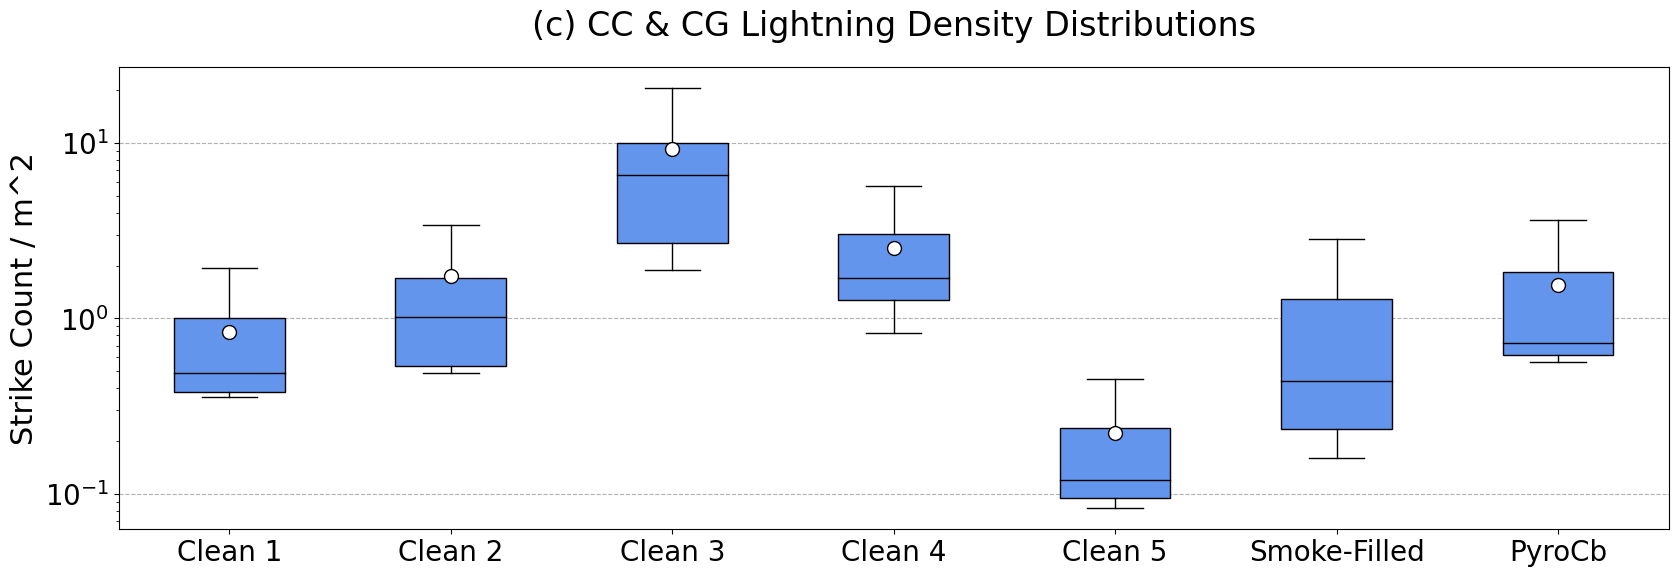

In [335]:
fig, ax = plt.subplots(figsize = (20,6))

ax.set_ylabel("Strike Count / m^2", color = "black", fontsize = 22)
plt.yticks(fontsize = 20, color = "black")
# plt.ylim(0, 25)
plt.yscale("log")
data = [clean1_total_density_flat, clean2_total_density_flat, clean3_total_density_flat, clean4_total_density_flat, 
        clean5_total_density_flat, smoke_total_density_flat, pyrocb_total_density_flat]

box1 = ax.boxplot(data, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"white", 
                   "markeredgecolor":"black",
                  "markersize":"10"}, medianprops=dict(color='black'), boxprops = dict(facecolor = "cornflowerblue"))
        
labels = ["Clean 1", "Clean 2", "Clean 3", "Clean 4", "Clean 5", "Smoke-Filled", "PyroCb"]  
ax.set_xticklabels(labels, fontsize = 20)

# x = np.arange(1, 8, 1)
# for i in range(0, 7, 1):
#     plt.annotate(len(data[i]), (x[i] - 0.07, 1000), rotation=90, fontsize = 18, color = "navy")

orangeline = mpatches.Patch(facecolor='darkorange', edgecolor = "darkorange", label=("PyroCb Third Quartile"))
timecount = mpatches.Patch(facecolor='navy', edgecolor = "navy", label=("Number of Time Intervals"))

# firstlegend = fig.legend(handles=[orangeline, timecount], loc='lower center', 
#             bbox_to_anchor=(0.5, -0.05),
#             ncol=2, fancybox=True, shadow=False, fontsize = 18, markerscale=3.,)


plt.gca().yaxis.grid(True, linestyle='--')
ax.set_title('(c) CC & CG Lightning Density Distributions', fontsize = 24, y=1.05)

# plt.savefig("boxplot_posneg_parallax_allcases.png",bbox_inches = "tight", dpi = 800)
plt.show()


/home/elenadworak/anaconda3/envs/xesmf_env/lib/python3.11/site-packages/numpy/core/_methods.py:181: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


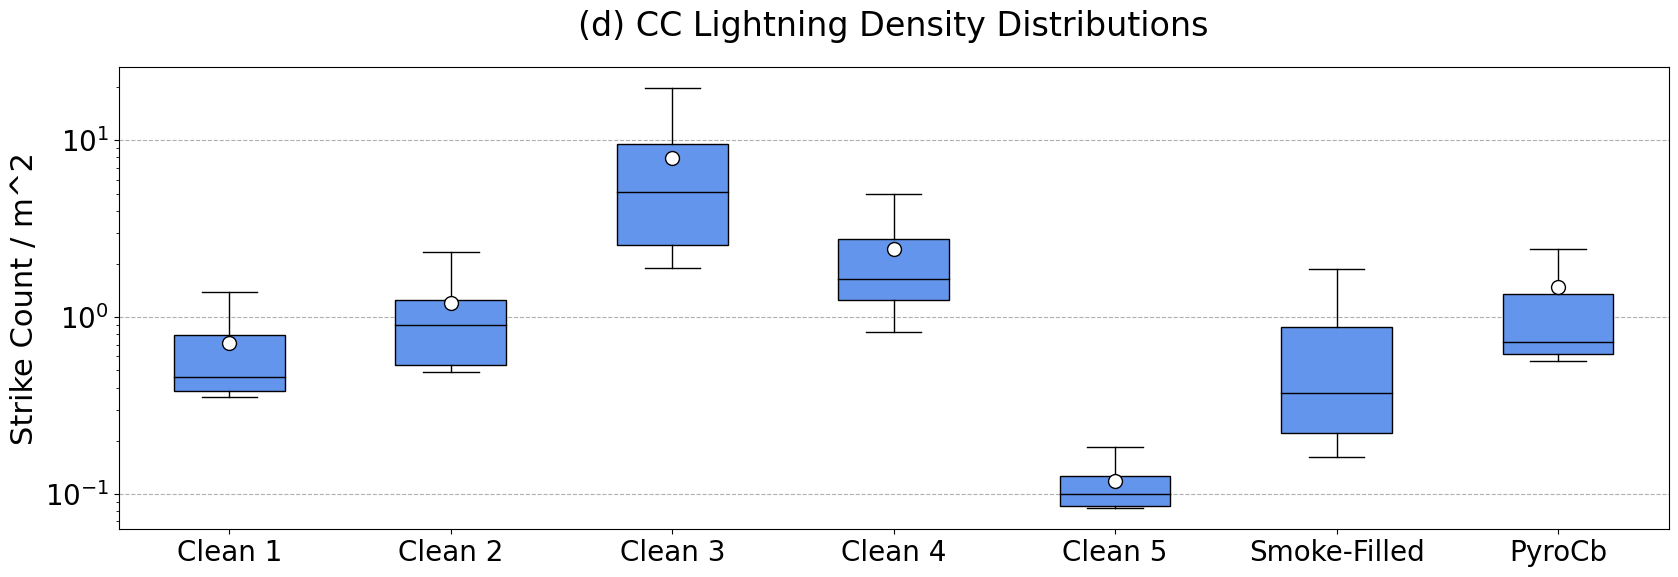

In [334]:
fig, ax = plt.subplots(figsize = (20,6))

ax.set_ylabel("Strike Count / m^2", color = "black", fontsize = 22)
plt.yticks(fontsize = 20, color = "black")
plt.yscale("log")
# plt.ylim(0, 25)
data = [clean1_cloud_density_flat, clean2_cloud_density_flat, clean3_cloud_density_flat, clean4_cloud_density_flat, 
        clean5_cloud_density_flat, smoke_cloud_density_flat, pyrocb_cloud_density_flat]

box1 = ax.boxplot(data, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"white", 
                   "markeredgecolor":"black",
                  "markersize":"10"}, medianprops=dict(color='black'), boxprops = dict(facecolor = "cornflowerblue"))
        
labels = ["Clean 1", "Clean 2", "Clean 3", "Clean 4", "Clean 5", "Smoke-Filled", "PyroCb"]  
ax.set_xticklabels(labels, fontsize = 20)

# x = np.arange(1, 8, 1)
# for i in range(0, 7, 1):
#     plt.annotate(len(data[i]), (x[i] - 0.07, 1000), rotation=90, fontsize = 18, color = "navy")

orangeline = mpatches.Patch(facecolor='darkorange', edgecolor = "darkorange", label=("PyroCb Third Quartile"))
timecount = mpatches.Patch(facecolor='navy', edgecolor = "navy", label=("Number of Time Intervals"))

# firstlegend = fig.legend(handles=[orangeline, timecount], loc='lower center', 
#             bbox_to_anchor=(0.5, -0.05),
#             ncol=2, fancybox=True, shadow=False, fontsize = 18, markerscale=3.,)


plt.gca().yaxis.grid(True, linestyle='--')
ax.set_title('(d) CC Lightning Density Distributions', fontsize = 24, y=1.05)

# plt.savefig("boxplot_posneg_parallax_allcases.png",bbox_inches = "tight", dpi = 800)
plt.show()


/home/elenadworak/anaconda3/envs/xesmf_env/lib/python3.11/site-packages/numpy/core/_methods.py:181: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


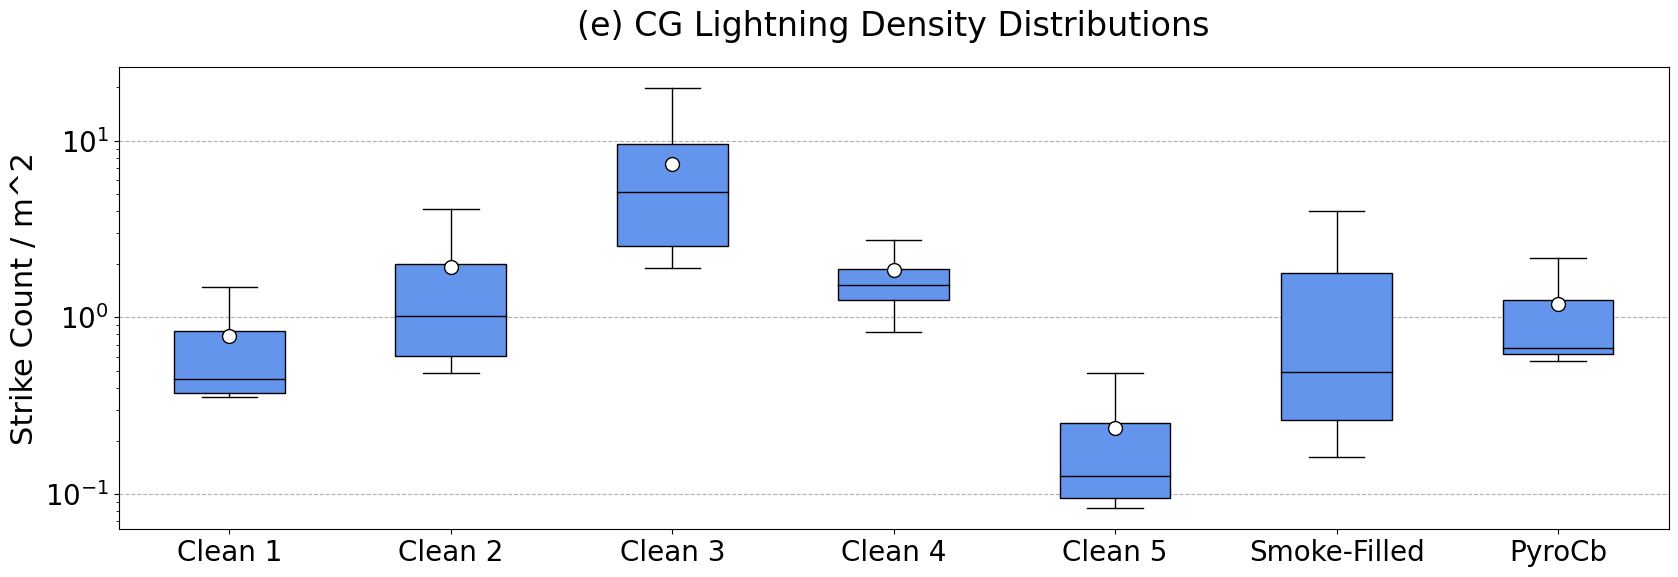

In [333]:
fig, ax = plt.subplots(figsize = (20,6))

ax.set_ylabel("Strike Count / m^2", color = "black", fontsize = 22)
plt.yticks(fontsize = 20, color = "black")
plt.yscale("log")
# plt.ylim(-100, 20)
data = [clean1_ground_density_flat, clean2_ground_density_flat, clean3_ground_density_flat, clean4_ground_density_flat, 
        clean5_ground_density_flat, smoke_ground_density_flat, pyrocb_ground_density_flat]

box1 = ax.boxplot(data, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"white", 
                   "markeredgecolor":"black",
                  "markersize":"10"}, medianprops=dict(color='black'), boxprops = dict(facecolor = "cornflowerblue"))
        
labels = ["Clean 1", "Clean 2", "Clean 3", "Clean 4", "Clean 5", "Smoke-Filled", "PyroCb"]  
ax.set_xticklabels(labels, fontsize = 20)

# x = np.arange(1, 8, 1)
# for i in range(0, 7, 1):
#     plt.annotate(len(data[i]), (x[i] - 0.07, 1000), rotation=90, fontsize = 18, color = "navy")

orangeline = mpatches.Patch(facecolor='darkorange', edgecolor = "darkorange", label=("PyroCb Third Quartile"))
timecount = mpatches.Patch(facecolor='navy', edgecolor = "navy", label=("Number of Time Intervals"))

# firstlegend = fig.legend(handles=[orangeline, timecount], loc='lower center', 
#             bbox_to_anchor=(0.5, -0.05),
#             ncol=2, fancybox=True, shadow=False, fontsize = 18, markerscale=3.,)


plt.gca().yaxis.grid(True, linestyle='--')
ax.set_title('(e) CG Lightning Density Distributions', fontsize = 24, y=1.05)

# plt.savefig("boxplot_posneg_parallax_allcases.png",bbox_inches = "tight", dpi = 800)
plt.show()


# FUCK THE MEGA PLOT

## total density

In [184]:
# colorbar 

# if x <= 20: "cornflowerblue"
# if (x > 20) & (x <= 60): "blue"
# if (x > 60) & (x <= 100): "orange"   
# if (x > 100) & (x <= 140): "darkorange"
# if (x > 140): "red"


colormap = LinearSegmentedColormap.from_list('custom', 
                                        [(0, "cornflowerblue"), 
                                        (0.2, "blue"), 
                                        (0.4, "orange"),
                                        (0.6, "darkorange"), 
                                        (1.0, 'red'),                                        
                                        ], N=5)
# 0-150 
# 30, 60, 90, 120, 150

from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

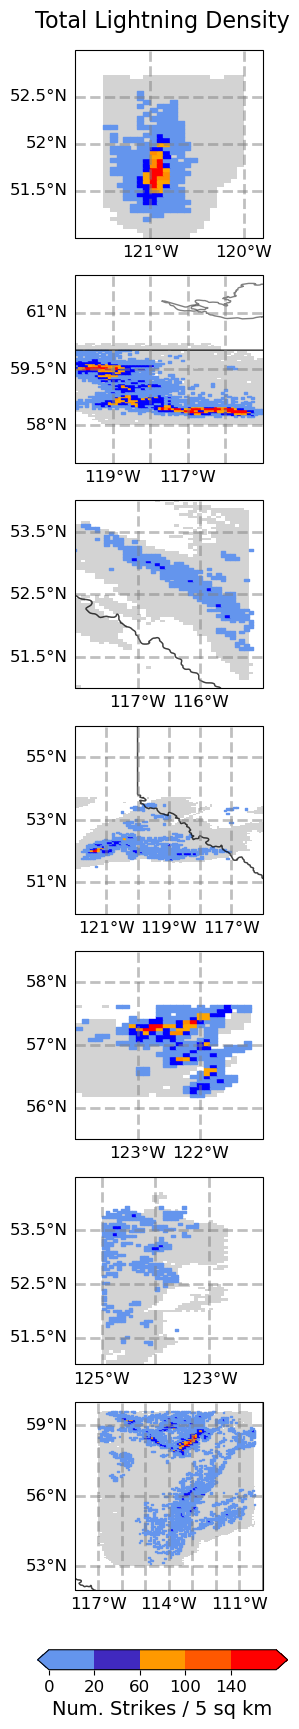

In [185]:
fig  = plt.figure(figsize=(5, 20)) 

patches_bt = [patches_bt_pyrocb, patches_bt_smoke, patches_bt_clean1, patches_bt_clean2, 
             patches_bt_clean3, patches_bt_clean4, patches_bt_clean5]
patches_lt = [patches_lt_pyrocb, patches_lt_smoke, patches_lt_clean1, patches_lt_clean2, 
             patches_lt_clean3, patches_lt_clean4, patches_lt_clean5]
color_lt = [color_lt_pyrocb, color_lt_smoke, color_lt_clean1, color_lt_clean2, 
             color_lt_clean3, color_lt_clean4, color_lt_clean5]
grid_corners = [pyrocb_grid_corners_df, smoke_grid_corners_df, clean1_grid_corners_df, clean1_grid_corners_df, 
               clean2_grid_corners_df, clean3_grid_corners_df, clean4_grid_corners_df, clean5_grid_corners_df]

# only want x-ticks on bottom of first row 
xticks = [[ -121, -120], [-119, -118, -117, -116], [-117, -116], [-121, -120, -119, -118, -117], 
          [-123, -122], [-125, -124, -123, -122, -121], [-117, -116, -115, -114, -113, -112, -111]]

# yticks on all 
yticks = [[51.5, 52, 52.5], [58, 59.5, 61], [51.5, 52.5, 53.5], [51, 53, 55], 
          [56, 57, 58], [51.5, 52.5, 53.5], [53, 56, 59]]

# 1 : 1 ratio 
x_lim = ([-121.8, -119.8], [-120, -115], [-118, -115], [-122, -116], 
         [-124, -121], [-125.5, -122], [-118, -110])

y_lim = ([51, 53], [57, 62], [51, 54], [50, 56], 
         [55.5, 58.5], [51, 54.5], [52, 60])
        
titles = ["PyroCb", "Smoke", "Clean 1", "Clean 2", "Clean 3", "Clean 4", "Clean 5"]

for i in range(0, 7):
    ax = fig.add_subplot(7, 1, i+1, projection=ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.BORDERS, linestyle = '-', alpha = 0.5)
    ax.add_feature(cartopy.feature.COASTLINE, linestyle = '-', alpha = 0.5)
    ax.add_feature(cartopy.feature.STATES, linestyle = '-', alpha = 0.5, edgecolor="black")
    
    # plt.ylabel(titles[i], fontsize = 14, rotation = 90, labelpad=20)
    plt.ylabel(titles[i])
    plt.gca().yaxis.label.set(rotation='vertical', ha='right', fontsize = 14)
    
    # shading 
    p_bt = PatchCollection(patches_bt[i], facecolor = "lightgrey", alpha=1)
    ax.add_collection(p_bt)
    
    p_lt = PatchCollection(patches_lt[i], alpha=1)
    ax.add_collection(p_lt)
    p_lt.set_color(color_lt[i])

    # Make figure larger
    plt.xlim(x_lim[i])
    plt.ylim(y_lim[i])

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=2, color='grey', alpha=0.5, linestyle='--')
    ax.set_axisbelow(True)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlines = True 
    gl.xlocator = mticker.FixedLocator(xticks[i])
    gl.ylocator = mticker.FixedLocator(yticks[i])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 12, 'color': 'black'}
    gl.ylabel_style = {'size': 12, 'color': 'black'}

    
# [left, bottom, width, height]
cax = plt.axes([0.25, 0.07, 0.5, 0.01])
cmappable = ScalarMappable(norm=Normalize(0,1), cmap=colormap)
cbar = plt.colorbar(cmappable, extend='both', orientation="horizontal",  cax = cax, ticks = [0, 28, 56, 84, 112]) # shrink = 0.3,

for t in cbar.ax.get_xticklabels():
        t.set_fontsize(12)
cbar.set_label(label= 'Num. Strikes / 5 sq km', fontsize = 14)
cmappable.set_clim(0, 140) 
cbar.ax.set_xticklabels(['0', '20', '60', '100', '140']) 

fig.suptitle("Total Lightning Density", fontsize = 16, y = 0.9)

plt.subplots_adjust(hspace = 0.2, wspace = 0.2)
plt.show()

## CC denisty

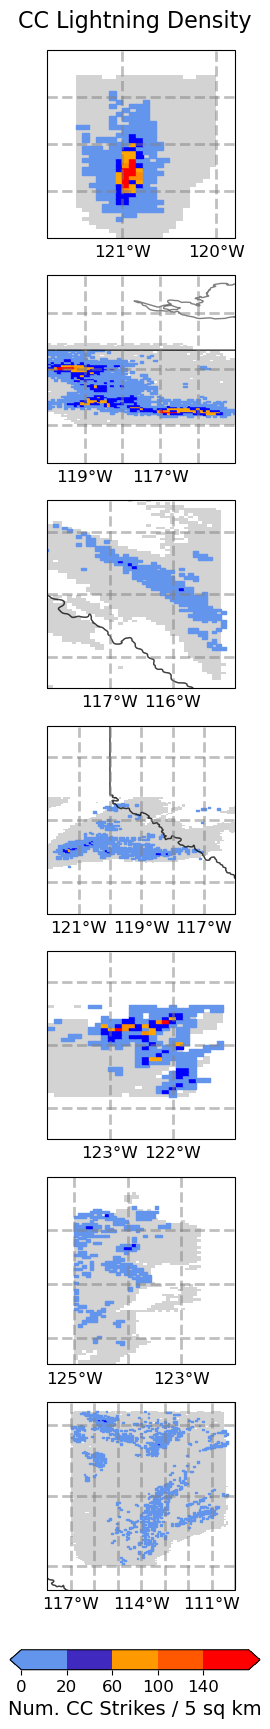

In [186]:
fig  = plt.figure(figsize=(5, 20)) 

patches_bt = [patches_bt_pyrocb, patches_bt_smoke, patches_bt_clean1, patches_bt_clean2, 
             patches_bt_clean3, patches_bt_clean4, patches_bt_clean5]
patches_lt = [patches_lt_pyrocb_cloud, patches_lt_smoke_cloud, patches_lt_clean1_cloud, patches_lt_clean2_cloud, 
             patches_lt_clean3_cloud, patches_lt_clean4_cloud, patches_lt_clean5_cloud]
color_lt = [color_lt_pyrocb_cloud, color_lt_smoke_cloud, color_lt_clean1_cloud, color_lt_clean2_cloud, 
             color_lt_clean3_cloud, color_lt_clean4_cloud, color_lt_clean5_cloud]
grid_corners = [pyrocb_grid_corners_df, smoke_grid_corners_df, clean1_grid_corners_df, clean1_grid_corners_df, 
               clean2_grid_corners_df, clean3_grid_corners_df, clean4_grid_corners_df, clean5_grid_corners_df]

# only want x-ticks on bottom of first row 
xticks = [[ -121, -120], [-119, -118, -117, -116], [-117, -116], [-121, -120, -119, -118, -117], 
          [-123, -122], [-125, -124, -123, -122, -121], [-117, -116, -115, -114, -113, -112, -111]]

# yticks on all 
yticks = [[51.5, 52, 52.5], [58, 59.5, 61], [51.5, 52.5, 53.5], [51, 53, 55], 
          [56, 57, 58], [51.5, 52.5, 53.5], [53, 56, 59]]

# 1 : 1 ratio 
x_lim = ([-121.8, -119.8], [-120, -115], [-118, -115], [-122, -116], 
         [-124, -121], [-125.5, -122], [-118, -110])

y_lim = ([51, 53], [57, 62], [51, 54], [50, 56], 
         [55.5, 58.5], [51, 54.5], [52, 60])
        
for i in range(0, 7):
    ax = fig.add_subplot(7, 1, i+1, projection=ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.BORDERS, linestyle = '-', alpha = 0.5)
    ax.add_feature(cartopy.feature.COASTLINE, linestyle = '-', alpha = 0.5)
    ax.add_feature(cartopy.feature.STATES, linestyle = '-', alpha = 0.5, edgecolor="black")
    
    # plt.ylabel(titles[i], fontsize = 14, rotation = 90, labelpad=20)
    plt.ylabel(titles[i])
    plt.gca().yaxis.label.set(rotation='vertical', ha='right', fontsize = 14)
    
    # shading 
    p_bt = PatchCollection(patches_bt[i], facecolor = "lightgrey", alpha=1)
    ax.add_collection(p_bt)
    
    p_lt = PatchCollection(patches_lt[i], alpha=1)
    ax.add_collection(p_lt)
    p_lt.set_color(color_lt[i])

    # Make figure larger
    plt.xlim(x_lim[i])
    plt.ylim(y_lim[i])

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=2, color='grey', alpha=0.5, linestyle='--')
    ax.set_axisbelow(True)
    gl.top_labels = False
    gl.right_labels = False
    gl.left_labels = False
    gl.xlines = True 
    gl.xlocator = mticker.FixedLocator(xticks[i])
    gl.ylocator = mticker.FixedLocator(yticks[i])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 12, 'color': 'black'}
    gl.ylabel_style = {'size': 12, 'color': 'black'}

    
# [left, bottom, width, height]
cax = plt.axes([0.25, 0.07, 0.5, 0.01])
cmappable = ScalarMappable(norm=Normalize(0,1), cmap=colormap)
cbar = plt.colorbar(cmappable, extend='both', orientation="horizontal",  cax = cax, ticks = [0, 28, 56, 84, 112]) # shrink = 0.3,

for t in cbar.ax.get_xticklabels():
        t.set_fontsize(12)
cbar.set_label(label= 'Num. CC Strikes / 5 sq km', fontsize = 14)
cmappable.set_clim(0, 140) 
cbar.ax.set_xticklabels(['0', '20', '60', '100', '140']) 

fig.suptitle("CC Lightning Density", fontsize = 16, y = 0.9)

plt.subplots_adjust(hspace = 0.2, wspace = 0.2)
plt.show()

## CG

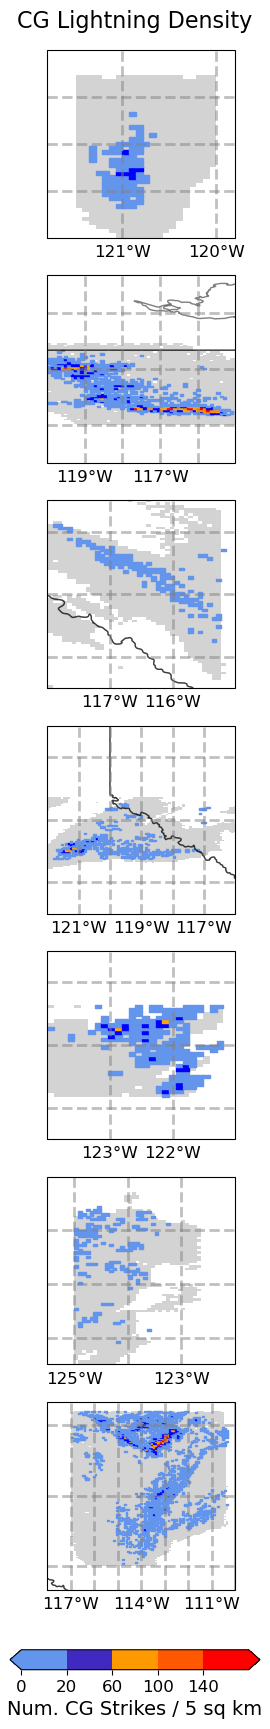

In [187]:
fig  = plt.figure(figsize=(5, 20)) 

patches_bt = [patches_bt_pyrocb, patches_bt_smoke, patches_bt_clean1, patches_bt_clean2, 
             patches_bt_clean3, patches_bt_clean4, patches_bt_clean5]
patches_lt = [patches_lt_pyrocb_ground, patches_lt_smoke_ground, patches_lt_clean1_ground, patches_lt_clean2_ground, 
             patches_lt_clean3_ground, patches_lt_clean4_ground, patches_lt_clean5_ground]
color_lt = [color_lt_pyrocb_ground, color_lt_smoke_ground, color_lt_clean1_ground, color_lt_clean2_ground, 
             color_lt_clean3_ground, color_lt_clean4_ground, color_lt_clean5_ground]
grid_corners = [pyrocb_grid_corners_df, smoke_grid_corners_df, clean1_grid_corners_df, clean1_grid_corners_df, 
               clean2_grid_corners_df, clean3_grid_corners_df, clean4_grid_corners_df, clean5_grid_corners_df]

# only want x-ticks on bottom of first row 
xticks = [[ -121, -120], [-119, -118, -117, -116], [-117, -116], [-121, -120, -119, -118, -117], 
          [-123, -122], [-125, -124, -123, -122, -121], [-117, -116, -115, -114, -113, -112, -111]]

# yticks on all 
yticks = [[51.5, 52, 52.5], [58, 59.5, 61], [51.5, 52.5, 53.5], [51, 53, 55], 
          [56, 57, 58], [51.5, 52.5, 53.5], [53, 56, 59]]

# 1 : 1 ratio 
x_lim = ([-121.8, -119.8], [-120, -115], [-118, -115], [-122, -116], 
         [-124, -121], [-125.5, -122], [-118, -110])

y_lim = ([51, 53], [57, 62], [51, 54], [50, 56], 
         [55.5, 58.5], [51, 54.5], [52, 60])
        
for i in range(0, 7):
    ax = fig.add_subplot(7, 1, i+1, projection=ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.BORDERS, linestyle = '-', alpha = 0.5)
    ax.add_feature(cartopy.feature.COASTLINE, linestyle = '-', alpha = 0.5)
    ax.add_feature(cartopy.feature.STATES, linestyle = '-', alpha = 0.5, edgecolor="black")
    
    # plt.ylabel(titles[i], fontsize = 14, rotation = 90, labelpad=20)
    plt.ylabel(titles[i])
    plt.gca().yaxis.label.set(rotation='vertical', ha='right', fontsize = 14)
    
    # shading 
    p_bt = PatchCollection(patches_bt[i], facecolor = "lightgrey", alpha=1)
    ax.add_collection(p_bt)
    
    p_lt = PatchCollection(patches_lt[i], alpha=1)
    ax.add_collection(p_lt)
    p_lt.set_color(color_lt[i])

    # Make figure larger
    plt.xlim(x_lim[i])
    plt.ylim(y_lim[i])

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=2, color='grey', alpha=0.5, linestyle='--')
    ax.set_axisbelow(True)
    gl.top_labels = False
    gl.right_labels = False
    gl.left_labels = False
    gl.xlines = True 
    gl.xlocator = mticker.FixedLocator(xticks[i])
    gl.ylocator = mticker.FixedLocator(yticks[i])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 12, 'color': 'black'}
    gl.ylabel_style = {'size': 12, 'color': 'black'}
    
# [left, bottom, width, height]
cax = plt.axes([0.25, 0.07, 0.5, 0.01])
cmappable = ScalarMappable(norm=Normalize(0,1), cmap=colormap)
cbar = plt.colorbar(cmappable, extend='both', orientation="horizontal",  cax = cax, ticks = [0, 28, 56, 84, 112]) # shrink = 0.3,

for t in cbar.ax.get_xticklabels():
        t.set_fontsize(12)
cbar.set_label(label= 'Num. CG Strikes / 5 sq km', fontsize = 14)
cmappable.set_clim(0, 140) 
cbar.ax.set_xticklabels(['0', '20', '60', '100', '140']) 

fig.suptitle("CG Lightning Density", fontsize = 16, y = 0.9)

plt.subplots_adjust(hspace = 0.2, wspace = 0.2)
plt.show()


## CC:CG

In [188]:
# if x <= 3: 
#     color_lt_clean5_cccg.append("cornflowerblue")
# if (x > 3) & (x <= 6): 
#     color_lt_clean5_cccg.append("blue")
# if (x > 6) & (x <= 9): 
#     color_lt_clean5_cccg.append("orange")   
# if (x > 9) & (x <= 12): 
#     color_lt_clean5_cccg.append("darkorange")
# if (x > 12): 
#     color_lt_clean5_cccg.append("red")



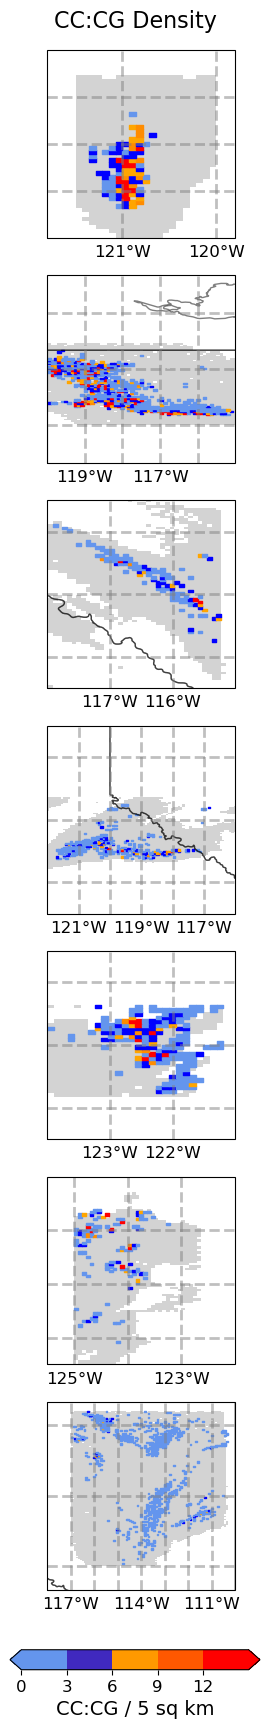

In [189]:
fig  = plt.figure(figsize=(5, 20)) 

patches_bt = [patches_bt_pyrocb, patches_bt_smoke, patches_bt_clean1, patches_bt_clean2, 
             patches_bt_clean3, patches_bt_clean4, patches_bt_clean5]
patches_lt = [patches_lt_pyrocb_cccg, patches_lt_smoke_cccg, patches_lt_clean1_cccg, patches_lt_clean2_cccg, 
             patches_lt_clean3_cccg, patches_lt_clean4_cccg, patches_lt_clean5_cccg]
color_lt = [color_lt_pyrocb_cccg, color_lt_smoke_cccg, color_lt_clean1_cccg, color_lt_clean2_cccg, 
             color_lt_clean3_cccg, color_lt_clean4_cccg, color_lt_clean5_cccg]
grid_corners = [pyrocb_grid_corners_df, smoke_grid_corners_df, clean1_grid_corners_df, clean1_grid_corners_df, 
               clean2_grid_corners_df, clean3_grid_corners_df, clean4_grid_corners_df, clean5_grid_corners_df]

# only want x-ticks on bottom of first row 
xticks = [[ -121, -120], [-119, -118, -117, -116], [-117, -116], [-121, -120, -119, -118, -117], 
          [-123, -122], [-125, -124, -123, -122, -121], [-117, -116, -115, -114, -113, -112, -111]]

# yticks on all 
yticks = [[51.5, 52, 52.5], [58, 59.5, 61], [51.5, 52.5, 53.5], [51, 53, 55], 
          [56, 57, 58], [51.5, 52.5, 53.5], [53, 56, 59]]

# 1 : 1 ratio 
x_lim = ([-121.8, -119.8], [-120, -115], [-118, -115], [-122, -116], 
         [-124, -121], [-125.5, -122], [-118, -110])

y_lim = ([51, 53], [57, 62], [51, 54], [50, 56], 
         [55.5, 58.5], [51, 54.5], [52, 60])
        
titles = ["PyroCb", "Smoke", "Clean 1", "Clean 2", "Clean 3", "Clean 4", "Clean 5"]

for i in range(0, 7):
    ax = fig.add_subplot(7, 1, i+1, projection=ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.BORDERS, linestyle = '-', alpha = 0.5)
    ax.add_feature(cartopy.feature.COASTLINE, linestyle = '-', alpha = 0.5)
    ax.add_feature(cartopy.feature.STATES, linestyle = '-', alpha = 0.5, edgecolor="black")
    
    # plt.ylabel(titles[i], fontsize = 14, rotation = 90, labelpad=20)
    plt.ylabel(titles[i])
    plt.gca().yaxis.label.set(rotation='vertical', ha='right', fontsize = 14)
    
    # shading 
    p_bt = PatchCollection(patches_bt[i], facecolor = "lightgrey", alpha=1)
    ax.add_collection(p_bt)
    
    p_lt = PatchCollection(patches_lt[i], alpha=1)
    ax.add_collection(p_lt)
    p_lt.set_color(color_lt[i])

    # Make figure larger
    plt.xlim(x_lim[i])
    plt.ylim(y_lim[i])

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=2, color='grey', alpha=0.5, linestyle='--')
    ax.set_axisbelow(True)
    gl.top_labels = False
    gl.right_labels = False
    gl.left_labels = False
    gl.xlines = True 
    gl.xlocator = mticker.FixedLocator(xticks[i])
    gl.ylocator = mticker.FixedLocator(yticks[i])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 12, 'color': 'black'}
    gl.ylabel_style = {'size': 12, 'color': 'black'}
    
# [left, bottom, width, height]
cax = plt.axes([0.25, 0.07, 0.5, 0.01])
cmappable = ScalarMappable(norm=Normalize(0,1), cmap=colormap)
cbar = plt.colorbar(cmappable, extend='both', orientation="horizontal",  cax = cax, ticks = [0, 2.4, 4.8, 7.2, 9.6]) # shrink = 0.3,

for t in cbar.ax.get_xticklabels():
        t.set_fontsize(12)
cbar.set_label(label= 'CC:CG / 5 sq km', fontsize = 14)
cmappable.set_clim(0, 12) 
cbar.ax.set_xticklabels(['0', '3', '6', '9', '12']) 

fig.suptitle("CC:CG Density", fontsize = 16, y = 0.9)

plt.subplots_adjust(hspace = 0.2, wspace = 0.2)
plt.show()

## perc pos

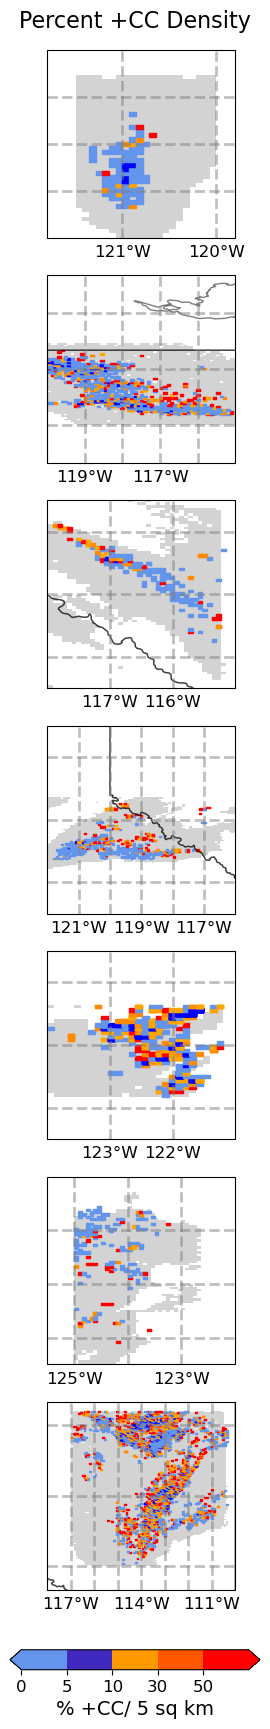

In [190]:
fig  = plt.figure(figsize=(5, 20)) 

patches_bt = [patches_bt_pyrocb, patches_bt_smoke, patches_bt_clean1, patches_bt_clean2, 
             patches_bt_clean3, patches_bt_clean4, patches_bt_clean5]
patches_lt = [patches_lt_pyrocb_percpos, patches_lt_smoke_percpos, patches_lt_clean1_percpos, patches_lt_clean2_percpos, 
             patches_lt_clean3_percpos, patches_lt_clean4_percpos, patches_lt_clean5_percpos]
color_lt = [color_lt_pyrocb_percpos, color_lt_smoke_percpos, color_lt_clean1_percpos, color_lt_clean2_percpos, 
             color_lt_clean3_percpos, color_lt_clean4_percpos, color_lt_clean5_percpos]
grid_corners = [pyrocb_grid_corners_df, smoke_grid_corners_df, clean1_grid_corners_df, clean1_grid_corners_df, 
               clean2_grid_corners_df, clean3_grid_corners_df, clean4_grid_corners_df, clean5_grid_corners_df]

# only want x-ticks on bottom of first row 
xticks = [[ -121, -120], [-119, -118, -117, -116], [-117, -116], [-121, -120, -119, -118, -117], 
          [-123, -122], [-125, -124, -123, -122, -121], [-117, -116, -115, -114, -113, -112, -111]]

# yticks on all 
yticks = [[51.5, 52, 52.5], [58, 59.5, 61], [51.5, 52.5, 53.5], [51, 53, 55], 
          [56, 57, 58], [51.5, 52.5, 53.5], [53, 56, 59]]

# 1 : 1 ratio 
x_lim = ([-121.8, -119.8], [-120, -115], [-118, -115], [-122, -116], 
         [-124, -121], [-125.5, -122], [-118, -110])

y_lim = ([51, 53], [57, 62], [51, 54], [50, 56], 
         [55.5, 58.5], [51, 54.5], [52, 60])
        
titles = ["PyroCb", "Smoke", "Clean 1", "Clean 2", "Clean 3", "Clean 4", "Clean 5"]

for i in range(0, 7):
    ax = fig.add_subplot(7, 1, i+1, projection=ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.BORDERS, linestyle = '-', alpha = 0.5)
    ax.add_feature(cartopy.feature.COASTLINE, linestyle = '-', alpha = 0.5)
    ax.add_feature(cartopy.feature.STATES, linestyle = '-', alpha = 0.5, edgecolor="black")
    
    # plt.ylabel(titles[i], fontsize = 14, rotation = 90, labelpad=20)
    plt.ylabel(titles[i])
    plt.gca().yaxis.label.set(rotation='vertical', ha='right', fontsize = 14)
    
    # shading 
    p_bt = PatchCollection(patches_bt[i], facecolor = "lightgrey", alpha=1)
    ax.add_collection(p_bt)
    
    p_lt = PatchCollection(patches_lt[i], alpha=1)
    ax.add_collection(p_lt)
    p_lt.set_color(color_lt[i])

    # Make figure larger
    plt.xlim(x_lim[i])
    plt.ylim(y_lim[i])

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=2, color='grey', alpha=0.5, linestyle='--')
    ax.set_axisbelow(True)
    gl.top_labels = False
    gl.right_labels = False
    gl.left_labels = False
    gl.xlines = True 
    gl.xlocator = mticker.FixedLocator(xticks[i])
    gl.ylocator = mticker.FixedLocator(yticks[i])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 12, 'color': 'black'}
    gl.ylabel_style = {'size': 12, 'color': 'black'}
    
# [left, bottom, width, height]
cax = plt.axes([0.25, 0.07, 0.5, 0.01])
cmappable = ScalarMappable(norm=Normalize(0,1), cmap=colormap)
cbar = plt.colorbar(cmappable, extend='both', orientation="horizontal",  cax = cax, ticks = [0, 20, 40, 60, 80]) # shrink = 0.3,

for t in cbar.ax.get_xticklabels():
        t.set_fontsize(12)
cbar.set_label(label= '% +CC/ 5 sq km', fontsize = 14)
cmappable.set_clim(0, 100) 
cbar.ax.set_xticklabels(['0', '5', '10', '30', '50']) 

fig.suptitle("Percent +CC Density", fontsize = 16, y = 0.9)

plt.subplots_adjust(hspace = 0.2, wspace = 0.2)
plt.show()

## 5 columns 

In [2]:
fig  = plt.figure(figsize=(15, 18)) 

patches_bt = [patches_bt_pyrocb, patches_bt_smoke, patches_bt_clean1, patches_bt_clean2, 
             patches_bt_clean3, patches_bt_clean4, patches_bt_clean5]
patches_lt = [patches_lt_pyrocb, patches_lt_smoke, patches_lt_clean1, patches_lt_clean2, 
             patches_lt_clean3, patches_lt_clean4, patches_lt_clean5]
color_lt = [color_lt_pyrocb, color_lt_smoke, color_lt_clean1, color_lt_clean2, 
             color_lt_clean3, color_lt_clean4, color_lt_clean5]
grid_corners = [pyrocb_grid_corners_df, smoke_grid_corners_df, clean1_grid_corners_df, clean1_grid_corners_df, 
               clean2_grid_corners_df, clean3_grid_corners_df, clean4_grid_corners_df, clean5_grid_corners_df]

# only want x-ticks on bottom of first row 
xticks = [[ -121, -120], [-119, -118, -117, -116], [-117, -116], [-121, -120, -119, -118, -117], 
          [-123, -122], [-125, -124, -123, -122, -121], [-117, -116, -115, -114, -113, -112, -111]]

# yticks on all 
yticks = [[51.5, 52, 52.5], [58, 59.5, 61], [51.5, 52.5, 53.5], [51, 53, 55], 
          [56, 57, 58], [51.5, 52.5, 53.5], [53, 56, 59]]

# 1 : 1 ratio 
x_lim = ([-121.8, -119.8], [-120, -115], [-118, -115], [-122, -116], 
         [-124, -121], [-125.5, -122], [-118, -110])

y_lim = ([51, 53], [57, 62], [51, 54], [50, 56], 
         [55.5, 58.5], [51, 54.5], [52, 60])


for i in range(0, 7):
    # 1, 4, 7, 10, 13
    ax = fig.add_subplot(7, 5, 5*i+1, projection=ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.BORDERS, linestyle = '-', alpha = 0.5)
    ax.add_feature(cartopy.feature.COASTLINE, linestyle = '-', alpha = 0.5)
    ax.add_feature(cartopy.feature.STATES, linestyle = '-', alpha = 0.5, edgecolor="black")
    
    # plt.ylabel(titles[i], fontsize = 14, rotation = 90, labelpad=20)
    # ax.set_ylabel(titles[i], fontsize = 16, rotation = 90, labelpad = 20)

    plt.gca().yaxis.label.set(rotation='vertical', ha='right', fontsize = 14)
    
    # shading 
    p_bt = PatchCollection(patches_bt[i], facecolor = "lightgrey", alpha=1)
    ax.add_collection(p_bt)
    
    p_lt = PatchCollection(patches_lt[i], alpha=1)
    ax.add_collection(p_lt)
    p_lt.set_color(color_lt[i])

    # Make figure larger
    plt.xlim(x_lim[i])
    plt.ylim(y_lim[i])

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=2, color='grey', alpha=0.5, linestyle='--')
    ax.set_axisbelow(True)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlines = True 
    gl.xlocator = mticker.FixedLocator(xticks[i])
    gl.ylocator = mticker.FixedLocator(yticks[i])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 12, 'color': 'black'}
    gl.ylabel_style = {'size': 12, 'color': 'black'}

    
ax.set_title("(a) Total Lightning", fontsize = 16, y = 8.3)


# ---------------------------------------------------------------------

patches_bt = [patches_bt_pyrocb, patches_bt_smoke, patches_bt_clean1, patches_bt_clean2, 
             patches_bt_clean3, patches_bt_clean4, patches_bt_clean5]
patches_lt = [patches_lt_pyrocb_cloud, patches_lt_smoke_cloud, patches_lt_clean1_cloud, patches_lt_clean2_cloud, 
             patches_lt_clean3_cloud, patches_lt_clean4_cloud, patches_lt_clean5_cloud]
color_lt = [color_lt_pyrocb_cloud, color_lt_smoke_cloud, color_lt_clean1_cloud, color_lt_clean2_cloud, 
             color_lt_clean3_cloud, color_lt_clean4_cloud, color_lt_clean5_cloud]
grid_corners = [pyrocb_grid_corners_df, smoke_grid_corners_df, clean1_grid_corners_df, clean1_grid_corners_df, 
               clean2_grid_corners_df, clean3_grid_corners_df, clean4_grid_corners_df, clean5_grid_corners_df]

        
for i in range(0, 7):
    ax = fig.add_subplot(7, 5, 5*i+2, projection=ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.BORDERS, linestyle = '-', alpha = 0.5)
    ax.add_feature(cartopy.feature.COASTLINE, linestyle = '-', alpha = 0.5)
    ax.add_feature(cartopy.feature.STATES, linestyle = '-', alpha = 0.5, edgecolor="black")
    
    plt.gca().yaxis.label.set(rotation='vertical', ha='right', fontsize = 14)
    
    # shading 
    p_bt = PatchCollection(patches_bt[i], facecolor = "lightgrey", alpha=1)
    ax.add_collection(p_bt)
    
    p_lt = PatchCollection(patches_lt[i], alpha=1)
    ax.add_collection(p_lt)
    p_lt.set_color(color_lt[i])

    # Make figure larger
    plt.xlim(x_lim[i])
    plt.ylim(y_lim[i])

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=2, color='grey', alpha=0.5, linestyle='--')
    ax.set_axisbelow(True)
    gl.top_labels = False
    gl.right_labels = False
    gl.left_labels = False
    gl.xlines = True 
    gl.xlocator = mticker.FixedLocator(xticks[i])
    gl.ylocator = mticker.FixedLocator(yticks[i])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 12, 'color': 'black'}
    gl.ylabel_style = {'size': 12, 'color': 'black'}

ax.set_title("(b) CC Lightning", fontsize = 16, y = 8.3)

# ---------------------------------------------------------------------


patches_bt = [patches_bt_pyrocb, patches_bt_smoke, patches_bt_clean1, patches_bt_clean2, 
             patches_bt_clean3, patches_bt_clean4, patches_bt_clean5]
patches_lt = [patches_lt_pyrocb_ground, patches_lt_smoke_ground, patches_lt_clean1_ground, patches_lt_clean2_ground, 
             patches_lt_clean3_ground, patches_lt_clean4_ground, patches_lt_clean5_ground]
color_lt = [color_lt_pyrocb_ground, color_lt_smoke_ground, color_lt_clean1_ground, color_lt_clean2_ground, 
             color_lt_clean3_ground, color_lt_clean4_ground, color_lt_clean5_ground]
grid_corners = [pyrocb_grid_corners_df, smoke_grid_corners_df, clean1_grid_corners_df, clean1_grid_corners_df, 
               clean2_grid_corners_df, clean3_grid_corners_df, clean4_grid_corners_df, clean5_grid_corners_df]

for i in range(0, 7):
    ax = fig.add_subplot(7, 5, 5*i+3, projection=ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.BORDERS, linestyle = '-', alpha = 0.5)
    ax.add_feature(cartopy.feature.COASTLINE, linestyle = '-', alpha = 0.5)
    ax.add_feature(cartopy.feature.STATES, linestyle = '-', alpha = 0.5, edgecolor="black")
    
    plt.gca().yaxis.label.set(rotation='vertical', ha='right', fontsize = 14)
    
    # shading 
    p_bt = PatchCollection(patches_bt[i], facecolor = "lightgrey", alpha=1)
    ax.add_collection(p_bt)
    
    p_lt = PatchCollection(patches_lt[i], alpha=1)
    ax.add_collection(p_lt)
    p_lt.set_color(color_lt[i])

    # Make figure larger
    plt.xlim(x_lim[i])
    plt.ylim(y_lim[i])

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=2, color='grey', alpha=0.5, linestyle='--')
    ax.set_axisbelow(True)
    gl.top_labels = False
    gl.right_labels = False
    gl.left_labels = False
    gl.xlines = True 
    gl.xlocator = mticker.FixedLocator(xticks[i])
    gl.ylocator = mticker.FixedLocator(yticks[i])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 12, 'color': 'black'}
    gl.ylabel_style = {'size': 12, 'color': 'black'}   
    
ax.set_title("(c) CG Lightning", fontsize = 16, y = 8.3)

# [left, bottom, width, height]
cax = plt.axes([0.16, 0.07, 0.4, 0.01])
cmappable = ScalarMappable(norm=Normalize(0,1), cmap=colormap)
cbar = plt.colorbar(cmappable, extend='both', orientation="horizontal",  cax = cax, ticks = [0, 28, 56, 84, 112]) # shrink = 0.3,

for t in cbar.ax.get_xticklabels():
        t.set_fontsize(14)
cbar.set_label(label= 'Num. Strikes / 25 sq km', fontsize = 16)
cmappable.set_clim(0, 140) 
cbar.ax.set_xticklabels(['0', '20', '60', '100', '140']) 



# ---------------------------------------------------------------------

patches_bt = [patches_bt_pyrocb, patches_bt_smoke, patches_bt_clean1, patches_bt_clean2, 
             patches_bt_clean3, patches_bt_clean4, patches_bt_clean5]
patches_lt = [patches_lt_pyrocb_cccg, patches_lt_smoke_cccg, patches_lt_clean1_cccg, patches_lt_clean2_cccg, 
             patches_lt_clean3_cccg, patches_lt_clean4_cccg, patches_lt_clean5_cccg]
color_lt = [color_lt_pyrocb_cccg, color_lt_smoke_cccg, color_lt_clean1_cccg, color_lt_clean2_cccg, 
             color_lt_clean3_cccg, color_lt_clean4_cccg, color_lt_clean5_cccg]
grid_corners = [pyrocb_grid_corners_df, smoke_grid_corners_df, clean1_grid_corners_df, clean1_grid_corners_df, 
               clean2_grid_corners_df, clean3_grid_corners_df, clean4_grid_corners_df, clean5_grid_corners_df]

        
for i in range(0, 7):
    ax = fig.add_subplot(7, 5, 5*i+4, projection=ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.BORDERS, linestyle = '-', alpha = 0.5)
    ax.add_feature(cartopy.feature.COASTLINE, linestyle = '-', alpha = 0.5)
    ax.add_feature(cartopy.feature.STATES, linestyle = '-', alpha = 0.5, edgecolor="black")
    
    plt.gca().yaxis.label.set(rotation='vertical', ha='right', fontsize = 14)
    
    # shading 
    p_bt = PatchCollection(patches_bt[i], facecolor = "lightgrey", alpha=1)
    ax.add_collection(p_bt)
    
    p_lt = PatchCollection(patches_lt[i], alpha=1)
    ax.add_collection(p_lt)
    p_lt.set_color(color_lt[i])

    # Make figure larger
    plt.xlim(x_lim[i])
    plt.ylim(y_lim[i])

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=2, color='grey', alpha=0.5, linestyle='--')
    ax.set_axisbelow(True)
    gl.top_labels = False
    gl.right_labels = False
    gl.left_labels = False
    gl.xlines = True 
    gl.xlocator = mticker.FixedLocator(xticks[i])
    gl.ylocator = mticker.FixedLocator(yticks[i])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 12, 'color': 'black'}
    gl.ylabel_style = {'size': 12, 'color': 'black'}

ax.set_title("(d) CC:CG", fontsize = 16, y = 8.3)

# [left, bottom, width, height]
cax = plt.axes([0.61, 0.07, 0.1, 0.01])
cmappable = ScalarMappable(norm=Normalize(0,1), cmap=colormap)
cbar = plt.colorbar(cmappable, extend='both', orientation="horizontal",  cax = cax, ticks = [0, 2.4, 4.8, 7.2, 9.6]) # shrink = 0.3,

for t in cbar.ax.get_xticklabels():
        t.set_fontsize(14)
cbar.set_label(label= 'CC:CG / 25 sq km', fontsize = 16)
cmappable.set_clim(0, 12) 
cbar.ax.set_xticklabels(['0', '3', '6', '9', '12']) 


# ---------------------------------------------------------------------

patches_bt = [patches_bt_pyrocb, patches_bt_smoke, patches_bt_clean1, patches_bt_clean2, 
             patches_bt_clean3, patches_bt_clean4, patches_bt_clean5]
patches_lt = [patches_lt_pyrocb_percpos, patches_lt_smoke_percpos, patches_lt_clean1_percpos, patches_lt_clean2_percpos, 
             patches_lt_clean3_percpos, patches_lt_clean4_percpos, patches_lt_clean5_percpos]
color_lt = [color_lt_pyrocb_percpos, color_lt_smoke_percpos, color_lt_clean1_percpos, color_lt_clean2_percpos, 
             color_lt_clean3_percpos, color_lt_clean4_percpos, color_lt_clean5_percpos]
grid_corners = [pyrocb_grid_corners_df, smoke_grid_corners_df, clean1_grid_corners_df, clean1_grid_corners_df, 
               clean2_grid_corners_df, clean3_grid_corners_df, clean4_grid_corners_df, clean5_grid_corners_df]

for i in range(0, 7):
    ax = fig.add_subplot(7, 5, 5*i+5, projection=ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.BORDERS, linestyle = '-', alpha = 0.5)
    ax.add_feature(cartopy.feature.COASTLINE, linestyle = '-', alpha = 0.5)
    ax.add_feature(cartopy.feature.STATES, linestyle = '-', alpha = 0.5, edgecolor="black")
    
    plt.gca().yaxis.label.set(rotation='vertical', ha='right', fontsize = 14)
    
    # shading 
    p_bt = PatchCollection(patches_bt[i], facecolor = "lightgrey", alpha=1)
    ax.add_collection(p_bt)
    
    p_lt = PatchCollection(patches_lt[i], alpha=1)
    ax.add_collection(p_lt)
    p_lt.set_color(color_lt[i])

    # Make figure larger
    plt.xlim(x_lim[i])
    plt.ylim(y_lim[i])

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=2, color='grey', alpha=0.5, linestyle='--')
    ax.set_axisbelow(True)
    gl.top_labels = False
    gl.right_labels = False
    gl.left_labels = False
    gl.xlines = True 
    gl.xlocator = mticker.FixedLocator(xticks[i])
    gl.ylocator = mticker.FixedLocator(yticks[i])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 12, 'color': 'black'}
    gl.ylabel_style = {'size': 12, 'color': 'black'}
    
# [left, bottom, width, height]
cax = plt.axes([0.76, 0.07, 0.1, 0.01])
cmappable = ScalarMappable(norm=Normalize(0,1), cmap=colormap)
cbar = plt.colorbar(cmappable, extend='both', orientation="horizontal",  cax = cax, ticks = [0, 20, 40, 60, 80]) # shrink = 0.3,

for t in cbar.ax.get_xticklabels():
        t.set_fontsize(14)
cbar.set_label(label= '% +CG/ 25 sq km', fontsize = 16)
cmappable.set_clim(0, 100) 
cbar.ax.set_xticklabels(['0', '5', '10', '30', '50']) 

ax.set_title("(e) Percent +CG", fontsize = 16, y = 8.3)

fig.text(0.095, 0.838, "(i) PyroCb", va='center', rotation='vertical', fontsize = 16)
fig.text(0.095, 0.725, "(ii) Smoke", va='center', rotation='vertical', fontsize = 16)
fig.text(0.095, 0.612, "(iii) Clean 1", va='center', rotation='vertical', fontsize = 16)
fig.text(0.095, 0.499, "(iv) Clean 2", va='center', rotation='vertical', fontsize = 16)
fig.text(0.095, 0.386, "(v) Clean 3", va='center', rotation='vertical', fontsize = 16)
fig.text(0.095, 0.273, "(vi) Clean 4", va='center', rotation='vertical', fontsize = 16)
fig.text(0.095, 0.16, "(vii) Clean 5", va='center', rotation='vertical', fontsize = 16)


plt.subplots_adjust(hspace = 0.2, wspace = -0.25) # h: height, w: width 
plt.suptitle("Lightning Density Spatial Analysis", weight= "bold", fontsize = 20, y = 0.93)
plt.show()



NameError: name 'patches_bt_pyrocb' is not defined

<Figure size 1500x1800 with 0 Axes>